<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Denmark/DANSKE/DANSKE_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "DANSKEDKDKK"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-25 11:16:07,720 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-25 11:16:07,721 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for DANSKEDKDKK
2019-08-25 11:19:07,775 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-25 11:25:30,587 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-25 11:28:59,457 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-25 11:32:18,292 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-25 11:35:36,344 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-25 11:38:46,427 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-25 11:42:15,749 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-25 11:45:16,804 - findatapy.market.datavendorweb - INFO - Downloading... 2018-

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-25 11:55:27,472 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_451__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_DANSKEDKDKK__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-DANSKEDKDKK__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-DANSKEDKDKK to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  2.42097  2.43598  2.40188  2.40788  3.982700
2018-01-02 09:00:00  2.40788  2.40898  2.39187  2.39387  2.843200
2018-01-02 10:00:00  2.39297  2.39298  2.38287  2.38887  3.383250
2018-01-02 11:00:00  2.38887  2.39788  2.38787  2.39588  2.282200
2018-01-02 12:00:00  2.39587  2.40597  2.39288  2.40597  3.218100
...                      ...      ...      ...      ...       ...
2018-12-28 11:00:00  1.28698  1.29498  1.28648  1.29198  2.871918
2018-12-28 12:00:00  1.29197  1.29198  1.28597  1.28947  2.483422
2018-12-28 13:00:00  1.28948  1.28998  1.28647  1.28897  1.653554
2018-12-28 14:00:00  1.28888  1.28998  1.28547  1.28797  3.485972
2018-12-28 15:00:00  1.28848  1.28848  1.28047  1.28648  3.397282

[1978 rows x 5 columns]

Open         High          Low        Close       Volume
count  1978.000000  1978.000000  1978.000000  1978.000000  1978.000000
mean      1.946097     1.952405     1.939545     1.946008     5.178613
std       0.398533     0.398205     0.399154     0.398684     2.854661
min       1.242970     1.255480     1.223980     1.247470     0.004320
25%       1.678730     1.685597     1.671473     1.679230     3.235216
50%       1.955825     1.966925     1.948920     1.953925     4.426770
75%       2.254948     2.260480     2.248870     2.255945     6.216252
max       2.517980     2.518970     2.514970     2.517980    22.767309

25

In [0]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  BBANDS_lowerband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2018-01-10 11:00:00  2.45588  2.46697  2.45587  2.46397  3.717500   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  2.448923  2.430607  2.419931  2.455906  2.448549  2.442914    2.445425    2.442375  2.420951  2.442665  2.461045  2.441357  2.449218  2.442665  2.459243  2.438976                2.470277                 2.442665                2.415053                2.484083                 2.442665                2.401247                2.497889                 2.442665                2.387441                2.511694                 2.442665                2.373635  2.448549  2.457876  2.439139                2.476161                 2.448549                2.420938                2.489967                 2.448549                2.407132                2.503773                 2.448549                2.393326                2.517579                 2.448549                2.379520   
2018-01-10 12:00:00  2.46397  2.46397  2.45087  2.45197  3.794800   10          2         10             31    12             0               0                 0      1        1     2        2             1           2  2.450447  2.435567  2.422808  2.455622  2.449310  2.443652    2.445425    2.442375  2.424705  2.445289  2.458808  2.446856  2.451286  2.445289  2.457970  2.439870                2.471933                 2.445289                2.418645                2.485255                 2.445289                2.405323                2.498577                 2.445289                2.392001                2.511899                 2.445289                2.378679  2.449310  2.454920  2.440219                2.475953                 2.449310                2.422666                2.489275                 2.449310                2.409344                2.502597                 2.449310                2.396022                2.515919                 2.449310                2.382700   
2018-01-10 13:00:00  2.4

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000    1928.000000  1928.000000   1928.000000     1928.000000       1928.000000  1928.000000  1928.000000  1928.000000  1928.000000   1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000  1928.000000             1928.000000              1928.000000             1928.000000             1928.000000              1928.000000             1928.000000             1928.000000              1928.000000             1928.000000             1928.000000              1928.000000             1928.000000  1928.000000  1928.000000  1928.000000             1928.000000              1928.000000             1928.000000             1928.000000              1928.000000             1928.000000             1928.000000   
mean      1.933618     1.939952     1.927043     1.933516     5.221404    15.886411     2.012448   186.486515      30.415975    10.884855      0.032676        0.028527          0.004149     6.635373     2.548237    27.210581     2.012448      1.984959    27.210581     1.935768     1.940423    -0.191875     1.933524     1.935613     1.936413     1.935545     1.935112     1.937978     1.935614     1.933523     1.935618     1.934919     1.935614     1.933813     1.939793                1.957651                 1.935614                1.913577                1.968670                 1.935614                1.902558                1.979689                 1.935614                1.891540                1.990707                 1.935614                1.880521     1.935613     1.933904     1.939166                1.957651                 1.935613                1.913576                1.968669                 1.935613                1.902558                1.979688   
std       0.395953     0.395646     0.396565     0.396093     2.872612     8.592249     1.405324   101.736663       0.860959     2.337443      0.177834        0.166516          0.064299     3.348676     1.104201    14.530652     1.405324      1.406222    14.530652     0.395536     0.394824     1.969965     0.396182     0.395361     0.394450     0.395241     0.395390     0.394999     0.395478     0.396157     0.395536     0.395643     0.395478     0.395998     0.394271                0.394078                 0.395478                0.397689                0.393686                 0.395478                0.399096                0.393500                 0.395478                0.400700                0.393521                 0.395478                0.402500     0.395361     0.395932     0.394451                0.393910                 0.395361                0.397624                0.393492                 0.395361                0.399056                0.393281   
min       1.242970     1.255480     1.223980     1.247470     0.004320     1.000000     0.000000    10.000

36

In [0]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-10 11:00:00  0.951294  0.958844  0.954221  0.957489  0.163124   10          2         10             31    11             0               0                 0      1        1     2        2             1           2  0.948743  0.944364  0.983339  0.950494  0.952661  0.945623    0.948360    0.949199  0.924309  0.945928  0.953584  0.943682  0.950069  0.945928  0.953710  0.948788                0.931027                 0.945928                0.933474                0.914194                 0.945928                0.927970                0.895842                 0.945928                0.922659                0.878344                 0.945928                0.917027  0.952661  0.953328  0.948394                0.946667                 0.952661                0.940612                0.929040                 0.952661                0.934563                0.909833                 0.952661                0.927290                0.891715                 0.952661   
2018-01-10 12:00:00  0.957639  0.956470  0.950348  0.948044  0.166519   10          2         10             31    12             0               0                 0      1        1     2        2             1           2  0.949962  0.948397  0.983912  0.950270  0.953270  0.946217    0.948360    0.949199  0.927208  0.948029  0.951821  0.948073  0.951720  0.948029  0.952706  0.949512                0.932309                 0.948029                0.936288                0.915077                 0.948029                0.931105                0.896346                 0.948029                0.926105                0.878489                 0.948029                0.920770  0.953270  0.950994  0.949267                0.946503                 0.953270                0.941979                0.928512                 0.953270                0.936282                0.908961                 0.953270                0.929344                0.890519                 0.953270   
2018-01-10 13:00:00  0.948228  0.962018  0.951130  0.962928  0.211298   10          2         10         

139161

In [0]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp8focyyw1
  JVM stdout: /tmp/tmp8focyyw1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp8focyyw1/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_xxca9k
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_120318_mod...  0.550827  0.923106              0.456641  0.573098  0.328442
1              DeepLearning_1_AutoML_20190825_120318  0.544810  0.889194              0.489362  0.569504  0.324335
2  DeepLearning_grid_1_AutoML_20190825_120318_mod...  0.533742  0.897203              0.489362  0.561488  0.315268
3  DeepLearning_grid_1_AutoML_20190825_120318_mod...  0.532775  0.692887              0.484043  0.499870  0.249870
4  DeepLearning_grid_1_AutoML_20190825_120318_mod...  0.516441  0.706661              0.462497  0.506821  0.256867
5  DeepLearning_grid_1_AutoML_20190825_120318_mod...  0.500000  0.693223              0.500000  0.500037  0.250037
6  DeepLearning_grid_1_AutoML_20190825_120318_mod...  0.500000  0.692925              0.500000  0.499889  0.249889
7  DeepLearning_grid_1_AutoML_20190825_120318_mod...  0.500000  0.693296              0.500000  0.500074  0.250074
8  DeepLearning_grid_1_AutoML_20190825_120318_mod...  0.500000  0.693098              0.500000  0.499976  0.249976
9  DeepLearning_grid_1_AutoML_20190825_120318_mod...  0.494036  7.890072              0.484043  0.695619  0.483886

variable  relative_importance  scaled_importance  percentage
0                  CDLPIERCING             1.000000           1.000000    0.003458
1              CDLLADDERBOTTOM             0.984310           0.984310    0.003403
2            CDL3WHITESOLDIERS             0.961018           0.961018    0.003323
3               CDL3LINESTRIKE             0.944138           0.944138    0.003265
4           CDLIDENTICAL3CROWS             0.932698           0.932698    0.003225
...                        ...                  ...                ...         ...
1027    BBANDS_upperband_8_1_2             0.242868           0.242868    0.000840
1028  BBANDS_middleband_30_0_5             0.242774           0.242774    0.000839
1029   BBANDS_lowerband_14_3_5             0.241852           0.241852    0.000836
1030   BBANDS_upperband_12_6_2             0.240989           0.240989    0.000833
1031                   MA_14_0             0.237238           0.237238    0.000820

[1032 rows x 4 columns]

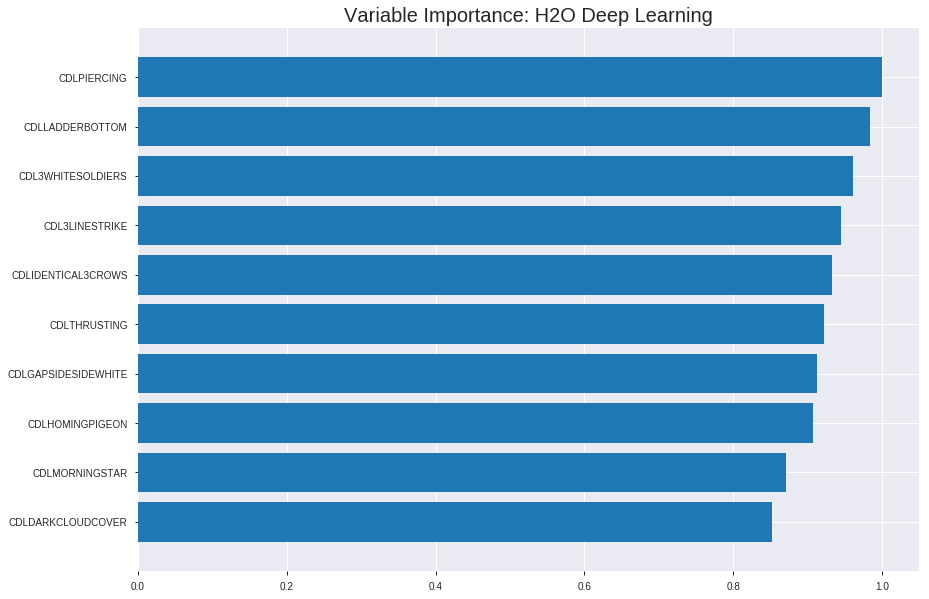

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_120318_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17010465817405798
RMSE: 0.412437459712449
LogLoss: 0.5084252585702929
Mean Per-Class Error: 0.24018329073573863
AUC: 0.849728454092561
pr_auc: 0.8535472597806862
Gini: 0.6994569081851221
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1782540134258963: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      371  298  0.4454   (298.0/669.0)
1      53   626  0.0781   (53.0/679.0)
Total  424  924  0.2604   (351.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.178254     0.781036  307
max f2                       0.068951     0.86541   357
max f0point5                 0.524469     0.786088  164
max accuracy                 0.271651     0.760386  266
max precision                0.999492     1         0
max recall                   0.00635814   1         394
max specificity              0.999492     1         0
max absolute_mcc             0.271651     0.526167  266
max min_per_class_accuracy   0.349612     0.748879  235
max mean_per_class_accuracy  0.271651     0.759817  266

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 40.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.995052           1.98527   1.98527            1                0.997278   1                           0.997278            0.0206186       0.0206186                  98.5272   98.5272
    2        0.0200297                   0.992749           1.98527   1.98527            1                0.994073   1                           0.995735            0.0191458       0.0397644                  98.5272   98.5272
    3        0.0304154                   0.98883            1.98527   1.98527            1                0.990593   1                           0.993979            0.0206186       0.0603829                  98.5272   98.5272
    4        0.0400593                   0.984566           1.98527   1.98527            1                0.98706    1                           0.992313            0.0191458       0.0795287                  98.5272   98.5272
    5        0.0504451                   0.97768            1.98527   1.98527            1                0.981969   1                           0.990184            0.0206186       0.100147                   98.5272   98.5272
    6        0.100148                    0.923098           1.98527   1.98527            1                0.951972   1                           0.971219            0.0986745       0.198822                   98.5272   98.5272
    7        0.150593                    0.836078           1.72252   1.89726            0.867647         0.875656   0.955665                    0.939208            0.0868925       0.285714                   72.2516   89.7255
    8        0.200297                    0.74561            1.71859   1.85292            0.865672         0.790554   0.933333                    0.90232             0.0854197       0.371134                   71.8594   85.2921
    9        0.300445                    0.568475           1.51469   1.74018            0.762963         0.647533   0.876543                    0.817391            0.151694        0.522828                   51.4689   74.0177
    10       0.399852                    0.454129           1.25931   1.62063            0.634328         0.509823   0.816327                    0.740927            0.125184        0.648012                   25.9315   62.0631
    11       0.5                         0.352793           0.970578  1.49043            0.488889         0.403056   0.750742                    0.673252            0.0972018       0.745214                   -2.94224  49.0427
    12       0.600148                    0.250939           1.05881   1.4184             0.533333         0.301842   0.714462                    0.611274            0.106038        0.851252                   5.8812    41.8402
    13       0.699555                    0.155765           0.770404  1.32632            0.38806          0.2077     0.668081                    0.553926            0.0765832       0.927835                   -22.9596  32.6322
    14       0.799703                    0.0774376          0.338232  1.20258            0.17037          0.114698   0.605751                    0.498921            0.0338733       0.961708                   -66.1768  20.2582
    15       0.899852                    0.0282545          0.279409  1.09984            0.140741         0.0519779  0.553998                    0.449179            0.0279823       0.989691                   -72.0591  9.98377
    16       1                           1.72301e-05        0.10294   1                  0.0518519        0.0102722  0.503709                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3625416153298151
RMSE: 0.6021142875981396
LogLoss: 1.091303318123029
Mean Per-Class Error: 0.48029265673244737
AUC: 0.460625587327158
pr_auc: 0.48475230723122703
Gini: -0.07874882534568395
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.004729335935477016: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    190  0.9948   (190.0/191.0)
1      0    195  0        (0.0/195.0)
Total  1    385  0.4922   (190.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00472934   0.672414  384
max f2                       0.00472934   0.83691   384
max f0point5                 0.00472934   0.56196   384
max accuracy                 0.598184     0.515544  37
max precision                0.995456     1         0
max recall                   0.00472934   1         384
max specificity              0.995456     1         0
max absolute_mcc             0.0418368    0.117286  352
max min_per_class_accuracy   0.197775     0.47644   192
max mean_per_class_accuracy  0.598184     0.519707  37

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 25.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.827698           0.989744  0.989744           0.5              0.895451   0.5                         0.895451            0.0102564       0.0102564                  -1.02564  -1.02564
    2        0.0207254                   0.785436           0.494872  0.742308           0.25             0.814425   0.375                       0.854938            0.00512821      0.0153846                  -50.5128  -25.7692
    3        0.0310881                   0.748799           0.989744  0.824786           0.5              0.765064   0.416667                    0.82498             0.0102564       0.025641                   -1.02564  -17.5214
    4        0.0414508                   0.695215           0.989744  0.866026           0.5              0.732763   0.4375                      0.801925            0.0102564       0.0358974                  -1.02564  -13.3974
    5        0.0518135                   0.652052           0.989744  0.890769           0.5              0.670972   0.45                        0.775735            0.0102564       0.0461538                  -1.02564  -10.9231
    6        0.101036                    0.590748           1.45857   1.16739            0.736842         0.614824   0.589744                    0.697342            0.0717949       0.117949                   45.857    16.739
    7        0.150259                    0.466509           0.729285  1.02387            0.368421         0.522944   0.517241                    0.640212            0.0358974       0.153846                   -27.0715  2.38727
    8        0.202073                    0.395851           0.494872  0.888231           0.25             0.430597   0.448718                    0.586464            0.025641        0.179487                   -50.5128  -11.1769
    9        0.300518                    0.314303           1.09393   0.955615           0.552632         0.352709   0.482759                    0.509889            0.107692        0.287179                   9.39271   -4.43855
    10       0.401554                    0.249438           1.16739   1.0089             0.589744         0.278056   0.509677                    0.451557            0.117949        0.405128                   16.739    0.889992
    11       0.5                         0.196685           0.729285  0.953846           0.368421         0.222606   0.481865                    0.406479            0.0717949       0.476923                   -27.0715  -4.61538
    12       0.601036                    0.155378           0.862853  0.93855            0.435897         0.174132   0.474138                    0.36742             0.0871795       0.564103                   -13.7147  -6.145
    13       0.699482                    0.118761           0.989744  0.945755           0.5              0.13491    0.477778                    0.334697            0.0974359       0.661538                   -1.02564  -5.4245
    14       0.800518                    0.0842834          1.01512   0.95451            0.512821         0.0990215  0.482201                    0.304951            0.102564        0.764103                   1.51216   -4.549
    15       0.898964                    0.0461696          1.14602   0.975482           0.578947         0.0621965  0.492795                    0.278367            0.112821        0.876923                   14.6019   -2.45178
    16       1                           0.00440115         1.21815   1                  0.615385         0.0314544  0.505181            


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:08:45  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:08:50  7.713 sec         138 obs/sec       0.495549  1             668        0.671416         4.31893             -0.803297      0.526622        0.333834           0.992636         0.488872                         0.703433           15.4081               -0.979487        0.5               0                    0.943709           0.494819
    2019-08-25 12:09:17  34.038 sec        142 obs/sec       3.02967   6             4084       0.625894         1.893               -0.567057      0.531267        0.526978           1.13444          0.496291                         0.701432           4.76863               -0.968237        0.505168          0.487791             0.494872           0.492228
    2019-08-25 12:09:45  1 min  1.893 sec  150 obs/sec       6.05341   12            8160       0.569267         1.21516             -0.296329      0.614912        0.576031           1.55986          0.477745                         0.6852             2.29314               -0.878196        0.446825          0.478294             1.48462            0.492228
    2019-08-25 12:10:11  1 min 27.851 sec  156 obs/sec       9.03709   18            12182      0.587023         1.43038             -0.378458      0.615765        0.655658           1.98527          0.468101                         0.698564           3.31048               -0.952177        0.506645          0.522787             0.989744           0.489637
    2019-08-25 12:10:36  1 min 53.102 sec  162 obs/sec       12.0779   24            16281      0.554396         1.1302              -0.229487      0.645037        0.654596           1.84347          0.484421                         0.610876           1.51975               -0.492839        0.491019          0.50581              0.989744           0.489637
    2019-08-25 12:11:04  2 min 21.065 sec  167 obs/sec       15.6306   31            21070      0.530916         0.961215            -0.127548      0.689211        0.6444             1.84347          0.399852                         0.703464           3.70125               -0.979661        0.448745          0.478604             0.989744           0.492228
    2019-08-25 12:11:31  2 min 47.910 sec  171 obs/sec       19.1432   38            25805      0.490771         0.731056            0.0365233      0.712855        0.690412           1.55986          0.382789                         0.618665           1.20403               -0.531149        0.470506          0.472041             1.48462            0.489637
    2019-08-25 12:11:57  3 min 14.578 sec  175 obs/sec       22.724    45            30632      0.43475          0.560732            0.243926       0.792537        0.773074           1.84347          0.290801                         0.659652           1.60336               -0.740751        0.424084          0.461277             0.989744           0.494819
    2019-08-25 12:12:23

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLPIERCING               1.0                    1.0                  0.003457744558327381
CDLLADDERBOTTOM           0.9843103289604187     0.9843103289604187   0.0034034936836683217
CDL3WHITESOLDIERS         0.9610176086425781     0.9610176086425781   0.0033229534067406668
CDL3LINESTRIKE            0.9441377520561218     0.9441377520561218   0.003264587174483501
CDLIDENTICAL3CROWS        0.9326980710029602     0.9326980710029602   0.0032250316795729306
---                       ---                    ---                  ---
BBANDS_upperband_8_1_2    0.242868110537529      0.242868110537529    0.0008397758876023937
BBANDS_middleband_30_0_5  0.24277441203594208    0.24277441203594208  0.000839451902118408
BBANDS_lowerband_14_3_5   0.24185237288475037    0.24185237288475037  0.0008362637262608101
BBANDS_upperband_12_6_2   0.24098949134349823    0.24098949134349823  0.0008332801023070644
MA_14_0                   0.23723828792572021    0.23723828792572021  0.0008203093991020634


See the whole table with table.as_data_frame()


('accuracy', 0.5595854922279793)

('F1', 0.6906474820143885)

('auc', 0.5508274231678487)

('logloss', 0.9231061688754268)

('mean_per_class_error', 0.44541156243283897)

('rmse', 0.5730984769035825)

('mse', 0.3284418642292061)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)



ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3284418642292061
RMSE: 0.5730984769035825
LogLoss: 0.9231061688754268
Mean Per-Class Error: 0.44541156243283897
AUC: 0.5508274231678487
pr_auc: 0.555076724717225
Gini: 0.10165484633569744
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05833714824344155: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      11   83   0.883    (83.0/94.0)
1      3    96   0.0303   (3.0/99.0)
Total  14   179  0.4456   (86.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0583371    0.690647  178
max f2                       0.0339831    0.84471   189
max f0point5                 0.0583371    0.588957  178
max accuracy                 0.168851     0.559585  133
max precision                0.521341     0.75      11
max recall                   0.0339831    1         189
max specificity              0.765857     0.989362  0
max absolute_mcc             0.0583371    0.16711   178
max min_per_class_accuracy   0.224703     0.5       96
max mean_per_class_accuracy  0.168851     0.554588  133

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 24.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.756634           0.974747  0.974747           0.5              0.761483   0.5                         0.761483            0.010101        0.010101                   -2.52525  -2.52525
    2        0.0207254                   0.619491           0.974747  0.974747           0.5              0.70959    0.5                         0.735536            0.010101        0.020202                   -2.52525  -2.52525
    3        0.0310881                   0.586913           0.974747  0.974747           0.5              0.599248   0.5                         0.690107            0.010101        0.030303                   -2.52525  -2.52525
    4        0.0414508                   0.574336           1.94949   1.21843            1                0.585524   0.625                       0.663961            0.020202        0.0505051                  94.9495   21.8434
    5        0.0518135                   0.53166            1.94949   1.36465            1                0.553515   0.7                         0.641872            0.020202        0.0707071                  94.9495   36.4646
    6        0.103627                    0.45393            1.1697    1.26717            0.6              0.485697   0.65                        0.563785            0.0606061       0.131313                   16.9697   26.7172
    7        0.150259                    0.407818           0.866442  1.14281            0.444444         0.43418    0.586207                    0.523563            0.040404        0.171717                   -13.3558  14.2807
    8        0.202073                    0.362045           1.36465   1.19969            0.7              0.38207    0.615385                    0.487283            0.0707071       0.242424                   36.4646   19.9689
    9        0.300518                    0.305981           0.82084   1.07558            0.421053         0.334212   0.551724                    0.437139            0.0808081       0.323232                   -17.916   7.55834
    10       0.398964                    0.251445           1.02605   1.06336            0.526316         0.271577   0.545455                    0.396286            0.10101         0.424242                   2.605     6.33609
    11       0.502591                    0.224703           0.779798  1.00489            0.4              0.238694   0.515464                    0.363793            0.0808081       0.505051                   -22.0202  0.48943
    12       0.601036                    0.192945           1.33386   1.05878            0.684211         0.205412   0.543103                    0.337851            0.131313        0.636364                   33.3865   5.87774
    13       0.699482                    0.163083           1.12865   1.06861            0.578947         0.178535   0.548148                    0.315429            0.111111        0.747475                   12.8655   6.8612
    14       0.797927                    0.119097           0.718235  1.02538            0.368421         0.144848   0.525974                    0.294383            0.0707071       0.818182                   -28.1765  2.53837
    15       0.896373                    0.0766547          1.12865   1.03673            0.578947         0.0971191  0.531792                    0.272718            0.111111        0.929293                   12.8655   3.67256
    16       1                           0.0135674          0.682323  1                  0.35             0.0491082  0.512953                 

This function is available for GLM models only


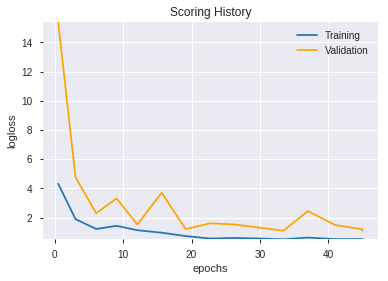

--2019-08-25 12:33:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.0.224
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.0.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  61.1MB/s    in 5.7s    

2019-08-25 12:33:42 (61.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unkno

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_120318_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_120318_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [0]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_123356_model_7  0.548248  0.807764              0.478723  0.535924  0.287214
1  DeepLearning_grid_1_AutoML_20190825_123356_model_9  0.541908  0.692471              0.467548  0.499661  0.249661
2  DeepLearning_grid_1_AutoML_20190825_123356_model_6  0.532237  0.695902              0.494681  0.501195  0.251196
3  DeepLearning_grid_1_AutoML_20190825_123356_model_5  0.522136  0.701212              0.483774  0.503843  0.253858
4  DeepLearning_grid_1_AutoML_20190825_123356_model_2  0.507629  0.840714              0.483774  0.548087  0.300400
5               DeepLearning_1_AutoML_20190825_123356  0.503976  0.760457              0.483505  0.521077  0.271521
6  DeepLearning_grid_1_AutoML_20190825_123356_model_3  0.493445  0.786113              0.473404  0.531450  0.282439
7  DeepLearning_grid_1_AutoML_20190825_123356_model_4  0.488287  0.959633              0.473404  0.575437  0.331128
8  DeepLearning_grid_1_AutoML_20190825_123356_model_1  0.482484  0.923719              0.472867  0.561039  0.314765
9  DeepLearning_grid_1_AutoML_20190825_123356_model_8  0.480873  0.694423              0.489362  0.500638  0.250638

variable  relative_importance  scaled_importance  percentage
0          CDLSHORTLINE             1.000000           1.000000    0.021997
1        STOCHRSI_fastk             0.977479           0.977479    0.021501
2          weekday_name             0.975377           0.975377    0.021455
3            aroonup_20             0.975183           0.975183    0.021451
4                  hour             0.973741           0.973741    0.021419
5                SAREXT             0.960683           0.960683    0.021132
6              CORREL_8             0.958490           0.958490    0.021084
7                BETA_8             0.948675           0.948675    0.020868
8     CDLSTALLEDPATTERN             0.946531           0.946531    0.020820
9          is_month_end             0.946171           0.946171    0.020813
10               Volume             0.932781           0.932781    0.020518
11   CDLIDENTICAL3CROWS             0.929976           0.929976    0.020456
12            CORREL_14             0.928562           0.928562    0.020425
13         CDLTHRUSTING             0.925405           0.925405    0.020356
14   CDLSEPARATINGLINES             0.918870           0.918870    0.020212
15            CORREL_20             0.913156           0.913156    0.020086
16         HT_TRENDMODE             0.911320           0.911320    0.020046
17          CDLHIGHWAVE             0.909927           0.909927    0.020015
18                  SUB             0.908491           0.908491    0.019984
19       CDLSPINNINGTOP             0.908067           0.908067    0.019974
20       CDLMATCHINGLOW             0.908027           0.908027    0.019974
21           CDL3INSIDE             0.906724           0.906724    0.019945
22            CDLTAKURI             0.905951           0.905951    0.019928
23            CORREL_12             0.905866           0.905866    0.019926
24              CDLDOJI             0.904723           0.904723    0.019901
25       CDLEVENINGSTAR             0.903913           0.903913    0.019883
26       CDLMORNINGSTAR             0.901863           0.901863    0.019838
27     CDLDRAGONFLYDOJI             0.900600           0.900600    0.019810
28       CDL3LINESTRIKE             0.895249           0.895249    0.019692
29          CDLDOJISTAR             0.893160           0.893160    0.019646
30       is_month_start             0.892617           0.892617    0.019635
31      CDLSHOOTINGSTAR             0.892138           0.892138    0.019624
32  CDLGAPSIDESIDEWHITE             0.891044           0.891044    0.019600
33         CDLTASUKIGAP             0.888110           0.888110    0.019535
34        CDLHANGINGMAN             0.888018           0.888018    0.019533
35      CDLADVANCEBLOCK             0.887867           0.887867    0.019530
36    CDL3WHITESOLDIERS             0.887297           0.887297    0.019518
37       CDLRICKSHAWMAN             0.886029           0.886029    0.019490
38               TRANGE             0.885544           0.885544    0.019479
39            CDLHAMMER             0.885203           0.885203    0.019471
40          CDLPIERCING             0.884844           0.884844    0.019464
41  CDLXSIDEGAP3METHODS             0.884046           0.884046    0.019446
42      CDLHOMINGPIGEON             0.883283           0.883283    0.019429
43    CDLGRAVESTONEDOJI             0.883112           0.883112    0.019425
44    CDLLONGLEGGEDDOJI             0.879297           0.879297    0.019342
45    CDLINVERTEDHAMMER             0.869596           0.869596    0.019128
46                  BOP             0.861790           0.861790    0.018956
47    CDLDARKCLOUDCOVER             0.859592           0.859592    0.018908
48                VAR_8             0.851615           0.851615    0.018733
49      CDLLADDERBOTTOM             0.845553           0.845553    0.018599

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_123356_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21767502704982275
RMSE: 0.4665565636124121
LogLoss: 0.6163778944152015
Mean Per-Class Error: 0.3255700042487524
AUC: 0.7466852026742924
pr_auc: 0.7462959056687345
Gini: 0.4933704053485848
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5198321568762484: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      254  415   0.6203   (415.0/669.0)
1      60   619   0.0884   (60.0/679.0)
Total  314  1034  0.3524   (475.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.519832     0.722709  253
max f2                       0.285441     0.854712  334
max f0point5                 0.708994     0.678766  143
max accuracy                 0.684473     0.674332  165
max precision                0.999513     1         0
max recall                   0.176214     1         359
max specificity              0.999513     1         0
max absolute_mcc             0.684473     0.348949  165
max min_per_class_accuracy   0.680237     0.667158  168
max mean_per_class_accuracy  0.684473     0.67443   165

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 62.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.990996           1.98527   1.98527            1                0.996543  1                           0.996543            0.0206186       0.0206186                  98.5272   98.5272
    2        0.0200297                   0.977626           1.83256   1.91174            0.923077         0.982575  0.962963                    0.989818            0.017673        0.0382916                  83.2559   91.1744
    3        0.0304154                   0.969891           1.84347   1.88843            0.928571         0.973179  0.95122                     0.984136            0.0191458       0.0574374                  84.3467   88.843
    4        0.0400593                   0.960145           1.98527   1.91174            1                0.965689  0.962963                    0.979695            0.0191458       0.0765832                  98.5272   91.1744
    5        0.0504451                   0.938209           1.84347   1.89769            0.928571         0.949994  0.955882                    0.97358             0.0191458       0.095729                   84.3467   89.7687
    6        0.100148                    0.859941           1.60007   1.74998            0.80597          0.896591  0.881481                    0.935371            0.0795287       0.175258                   60.007    74.9981
    7        0.150593                    0.794561           1.57654   1.69188            0.794118         0.821913  0.852217                    0.897365            0.0795287       0.254786                   57.654    69.1882
    8        0.200297                    0.762793           1.42228   1.62498            0.716418         0.777133  0.818519                    0.86753             0.0706922       0.325479                   42.2285   62.4982
    9        0.300445                    0.730082           1.23528   1.49508            0.622222         0.743929  0.753086                    0.82633             0.123711        0.44919                    23.5281   49.5082
    10       0.399852                    0.704786           1.12598   1.40332            0.567164         0.717312  0.706865                    0.799227            0.111929        0.561119                   12.5975   40.3319
    11       0.5                         0.679811           1.05881   1.33432            0.533333         0.692856  0.672107                    0.777921            0.106038        0.667158                   5.8812    33.4315
    12       0.600148                    0.643093           0.970578  1.27362            0.488889         0.661932  0.641533                    0.758566            0.0972018       0.764359                   -2.94224  27.3617
    13       0.699555                    0.587777           0.814851  1.20843            0.410448         0.618541  0.608696                    0.738668            0.0810015       0.845361                   -18.5149  20.8427
    14       0.799703                    0.476113           0.867638  1.16575            0.437037         0.535261  0.587199                    0.713195            0.0868925       0.932253                   -13.2362  16.5749
    15       0.899852                    0.299331           0.529406  1.09493            0.266667         0.398245  0.551525                    0.678143            0.0530191       0.985272                   -47.0594  9.49277
    16       1                           0.000289043        0.147057  1                  0.0740741        0.132686  0.503709                    0.623517          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.31751751898357977
RMSE: 0.5634869288489128
LogLoss: 0.9022502842199129
Mean Per-Class Error: 0.4849644247550007
AUC: 0.4736474694589878
pr_auc: 0.4834476693102259
Gini: -0.05270506108202444
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14837815216372321: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    182  0.9529   (182.0/191.0)
1      4    191  0.0205   (4.0/195.0)
Total  13   373  0.4819   (186.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.148378     0.672535  372
max f2                       0.00781653   0.83691   384
max f0point5                 0.148378     0.566094  372
max accuracy                 0.148378     0.518135  372
max precision                0.892839     0.56      24
max recall                   0.00781653   1         384
max specificity              0.999323     0.994764  0
max absolute_mcc             0.759987     0.105927  83
max min_per_class_accuracy   0.690501     0.497382  192
max mean_per_class_accuracy  0.675347     0.515036  211

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 62.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.98545            0         0                  0                0.990539  0                           0.990539            0               0                          -100      -100
    2        0.0207254                   0.97158            0.989744  0.494872           0.5              0.979619  0.25                        0.985079            0.0102564       0.0102564                  -1.02564  -50.5128
    3        0.0310881                   0.950537           1.48462   0.824786           0.75             0.960454  0.416667                    0.97687             0.0153846       0.025641                   48.4615   -17.5214
    4        0.0414508                   0.936097           1.48462   0.989744           0.75             0.941608  0.5                         0.968055            0.0153846       0.0410256                  48.4615   -1.02564
    5        0.0518135                   0.918726           0.989744  0.989744           0.5              0.927944  0.5                         0.960033            0.0102564       0.0512821                  -1.02564  -1.02564
    6        0.101036                    0.816704           1.04184   1.01512            0.526316         0.861826  0.512821                    0.912188            0.0512821       0.102564                   4.18354   1.51216
    7        0.150259                    0.778671           1.14602   1.058              0.578947         0.79876   0.534483                    0.875031            0.0564103       0.158974                   14.6019   5.80018
    8        0.202073                    0.763922           0.197949  0.837475           0.1              0.77176   0.423077                    0.848551            0.0102564       0.169231                   -80.2051  -16.2525
    9        0.300518                    0.732789           1.09393   0.921485           0.552632         0.74795   0.465517                    0.815596            0.107692        0.276923                   9.39271   -7.85146
    10       0.401554                    0.711495           1.11663   0.970587           0.564103         0.720553  0.490323                    0.791682            0.112821        0.389744                   11.6634   -2.94127
    11       0.5                         0.690348           1.09393   0.994872           0.552632         0.699967  0.502591                    0.773624            0.107692        0.497436                   9.39271   -0.512821
    12       0.601036                    0.662109           0.964366  0.989744           0.487179         0.674859  0.5                         0.757021            0.0974359       0.594872                   -3.56345  -1.02564
    13       0.699482                    0.595377           0.88556   0.975081           0.447368         0.630077  0.492593                    0.739155            0.0871795       0.682051                   -11.444   -2.49193
    14       0.800518                    0.456641           0.964366  0.973728           0.487179         0.537687  0.491909                    0.713727            0.0974359       0.779487                   -3.56345  -2.62717
    15       0.898964                    0.287932           1.04184   0.981187           0.526316         0.371456  0.495677                    0.676245            0.102564        0.882051                   4.18354   -1.88133
    16       1                           0.0063517          1.16739   1                  0.589744         0.170926  0.505181                    0.62518


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:38:38  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:38:43  6.192 sec         218 obs/sec       0.810831  1             1093       0.546567         0.838886            -0.195007      0.549833        0.544539           1.13444          0.477745                         0.569574           0.903027              -0.297796        0.491663          0.505546             0.989744           0.494819
    2019-08-25 12:38:56  19.380 sec        451 obs/sec       5.70326   7             7688       0.567035         0.902132            -0.286184      0.667392        0.677596           1.98527          0.431009                         0.598097           1.039                 -0.431032        0.481917          0.508145             0.989744           0.492228
    2019-08-25 12:39:08  31.654 sec        505 obs/sec       10.5645   13            14241      0.466557         0.616378            0.129252       0.746685        0.746296           1.98527          0.352374                         0.563487           0.90225               -0.270206        0.473647          0.483448             0                  0.481865
    2019-08-25 12:39:20  43.779 sec        532 obs/sec       15.4918   19            20883      0.493861         0.688421            0.0243523      0.814474        0.810312           1.98527          0.300445                         0.609942           1.12667               -0.488278        0.472976          0.499903             0.989744           0.481865
    2019-08-25 12:39:32  55.623 sec        549 obs/sec       20.3316   25            27407      0.505695         0.741785            -0.0229668     0.853196        0.824468           1.98527          0.265579                         0.624813           1.28024               -0.561732        0.497892          0.509018             0.989744           0.494819
    2019-08-25 12:39:44  1 min  7.483 sec  560 obs/sec       25.2292   31            34009      0.483675         0.668811            0.0641829      0.869619        0.866716           1.98527          0.227003                         0.620107           1.36599               -0.538296        0.478239          0.490776             0.989744           0.494819
    2019-08-25 12:39:45  1 min  8.710 sec  560 obs/sec       25.2292   31            34009      0.466557         0.616378            0.129252       0.746685        0.746296           1.98527          0.352374                         0.563487           0.90225               -0.270206        0.473647          0.483448             0                  0.481865

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDLSHORTLINE       1.0                    1.0                  0.02199661020828231
STOCHRSI_fastk     0.9774788022041321     0.9774788022041321   0.021501220198942978
weekday_name       0.9753774404525757     0.9753774404525757   0.0214549973635874
aroonup_20         0.9751827120780945     0.9751827120780945   0.021450713999437442
hour               0.9737414717674255     0.9737414717674255   0.021419011598107194
---                ---                    ---                  ---
CDLINVERTEDHAMMER  0.8695961833000183     0.8695961833000183   0.01912816828266052
BOP                0.861789882183075      0.861789882183075    0.018956456119822638
CDLDARKCLOUDCOVER  0.859591543674469      0.859591543674469    0.018908100124542974
VAR_8              0.8516154885292053     0.8516154885292053   0.018732653948512847
CDLLADDERBOTTOM    0.8455525040626526     0.8455525040626526   0.018599288842503215


See the whole table with table.as_data_frame()


('accuracy', 0.5595854922279793)

('F1', 0.6875000000000001)

('auc', 0.5482484418654632)

('logloss', 0.8077635641557058)

('mean_per_class_error', 0.44487427466150864)

('rmse', 0.5359237761650827)

('mse', 0.2872142938590416)

deeplearning prediction progress: |███████████████████████████████████████| 100%



ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2872142938590416
RMSE: 0.5359237761650827
LogLoss: 0.8077635641557058
Mean Per-Class Error: 0.44487427466150864
AUC: 0.5482484418654632
pr_auc: 0.547296507888423
Gini: 0.09649688373092635
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0795091855969013: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      4    90   0.9574   (90.0/94.0)
1      0    99   0        (0.0/99.0)
Total  4    189  0.4663   (90.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0795092    0.6875    188
max f2                       0.0795092    0.846154  188
max f0point5                 0.631403     0.582677  133
max accuracy                 0.646294     0.559585  129
max precision                0.861362     0.714286  13
max recall                   0.0795092    1         188
max specificity              0.984271     0.989362  0
max absolute_mcc             0.0795092    0.149298  188
max min_per_class_accuracy   0.679784     0.525253  95
max mean_per_class_accuracy  0.646294     0.555126  129

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 63.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.974282           0.974747  0.974747           0.5              0.979964  0.5                         0.979964            0.010101        0.010101                   -2.52525  -2.52525
    2        0.0207254                   0.970703           0.974747  0.974747           0.5              0.972672  0.5                         0.976318            0.010101        0.020202                   -2.52525  -2.52525
    3        0.0310881                   0.94912            0.974747  0.974747           0.5              0.969232  0.5                         0.973956            0.010101        0.030303                   -2.52525  -2.52525
    4        0.0414508                   0.926514           0.974747  0.974747           0.5              0.938776  0.5                         0.965161            0.010101        0.040404                   -2.52525  -2.52525
    5        0.0518135                   0.892826           1.94949   1.1697             1                0.91229   0.6                         0.954587            0.020202        0.0606061                  94.9495   16.9697
    6        0.103627                    0.809106           1.1697    1.1697             0.6              0.843982  0.6                         0.899284            0.0606061       0.121212                   16.9697   16.9697
    7        0.150259                    0.763712           0.866442  1.07558            0.444444         0.783668  0.551724                    0.863403            0.040404        0.161616                   -13.3558  7.55834
    8        0.202073                    0.743348           1.36465   1.1497             0.7              0.749138  0.589744                    0.834105            0.0707071       0.232323                   36.4646   14.9702
    9        0.300518                    0.724811           0.923445  1.07558            0.473684         0.73429   0.551724                    0.801407            0.0909091       0.323232                   -7.6555   7.55834
    10       0.398964                    0.706906           0.923445  1.03804            0.473684         0.715494  0.532468                    0.780208            0.0909091       0.414141                   -7.6555   3.80428
    11       0.502591                    0.679339           1.07222   1.04509            0.55             0.691943  0.536082                    0.762009            0.111111        0.525253                   7.22222   4.50901
    12       0.601036                    0.662599           1.02605   1.04197            0.526316         0.670391  0.534483                    0.747002            0.10101         0.626263                   2.605     4.19714
    13       0.699482                    0.62798            1.23126   1.06861            0.631579         0.649268  0.548148                    0.733247            0.121212        0.747475                   23.126    6.8612
    14       0.797927                    0.573112           0.82084   1.03804            0.421053         0.606821  0.532468                    0.717649            0.0808081       0.828283                   -17.916   3.80428
    15       0.896373                    0.314356           0.923445  1.02546            0.473684         0.471724  0.526012                    0.69064             0.0909091       0.919192                   -7.6555   2.54569
    16       1                           3.50504e-05        0.779798  1                  0.4              0.149618  0.512953                    0.634576      

This function is available for GLM models only


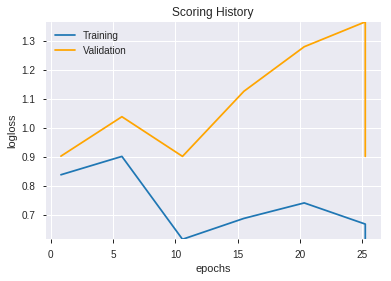

--2019-08-25 12:42:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_123356_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_123356_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSHORTLINE',
 'STOCHRSI_fastk',
 'weekday_name',
 'aroonup_20',
 'hour',
 'SAREXT',
 'CORREL_8',
 'BETA_8',
 'CDLSTALLEDPATTERN',
 'is_month_end',
 'Volume',
 'CDLIDENTICAL3CROWS',
 'CORREL_14',
 'CDLTHRUSTING',
 'CDLSEPARATINGLINES',
 'CORREL_20',
 'HT_TRENDMODE',
 'CDLHIGHWAVE',
 'SUB',
 'CDLSPINNINGTOP',
 'CDLMATCHINGLOW',
 'CDL3INSIDE',
 'CDLTAKURI',
 'CORREL_12',
 'CDLDOJI',
 'CDLEVENINGSTAR',
 'CDLMORNINGSTAR',
 'CDLDRAGONFLYDOJI',
 'CDL3LINESTRIKE',
 'CDLDOJISTAR',
 'is_month_start',
 'CDLSHOOTINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLTASUKIGAP',
 'CDLHANGINGMAN',
 'CDLADVANCEBLOCK',
 'CDL3WHITESOLDIERS',
 'CDLRICKSHAWMAN',
 'TRANGE',
 'CDLHAMMER',
 'CDLPIERCING',
 'CDLXSIDEGAP3METHODS',
 'CDLHOMINGPIGEON',
 'CDLGRAVESTONEDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLINVERTEDHAMMER',
 'BOP',
 'CDLDARKCLOUDCOVER',
 'VAR_8',
 'CDLLADDERBOTTOM']

In [0]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_124230_model_1  0.496561  0.692568              0.473136  0.499711  0.249711

variable  relative_importance  scaled_importance  percentage
0    CDLIDENTICAL3CROWS             0.009132           1.000000    0.046962
1          CDLSHORTLINE             0.008767           0.960042    0.045086
2        CDL3LINESTRIKE             0.007217           0.790342    0.037116
3        CDLSPINNINGTOP             0.007192           0.787559    0.036986
4           CDLHIGHWAVE             0.007172           0.785420    0.036885
5                BETA_8             0.007054           0.772457    0.036276
6               CDLDOJI             0.007044           0.771319    0.036223
7        CDLRICKSHAWMAN             0.006716           0.735443    0.034538
8     CDLLONGLEGGEDDOJI             0.006655           0.728736    0.034223
9           CDLDOJISTAR             0.006349           0.695208    0.032649
10           aroonup_20             0.006092           0.667119    0.031329
11             CORREL_8             0.006015           0.658639    0.030931
12               TRANGE             0.005748           0.629411    0.029559
13            CDLTAKURI             0.005287           0.578988    0.027191
14          CDLPIERCING             0.005243           0.574136    0.026963
15       CDLEVENINGSTAR             0.005204           0.569857    0.026762
16      CDLLADDERBOTTOM             0.005201           0.569593    0.026749
17    CDL3WHITESOLDIERS             0.005101           0.558549    0.026231
18         is_month_end             0.004894           0.535878    0.025166
19                 hour             0.004201           0.460058    0.021605
20       CDLMATCHINGLOW             0.003808           0.416985    0.019583
21      CDLADVANCEBLOCK             0.003767           0.412562    0.019375
22               Volume             0.003580           0.392074    0.018413
23     CDLDRAGONFLYDOJI             0.003569           0.390840    0.018355
24                  SUB             0.003518           0.385202    0.018090
25       CDLMORNINGSTAR             0.003184           0.348619    0.016372
26       is_month_start             0.003163           0.346355    0.016266
27           CDL3INSIDE             0.003118           0.341488    0.016037
28         CDLTHRUSTING             0.003091           0.338429    0.015893
29       STOCHRSI_fastk             0.003010           0.329561    0.015477
30         CDLTASUKIGAP             0.002986           0.327002    0.015357
31        CDLHANGINGMAN             0.002927           0.320574    0.015055
32               SAREXT             0.002826           0.309428    0.014531
33  CDLXSIDEGAP3METHODS             0.002809           0.307562    0.014444
34  CDLGAPSIDESIDEWHITE             0.002719           0.297795    0.013985
35            CORREL_14             0.002458           0.269196    0.012642
36    CDLSTALLEDPATTERN             0.002250           0.246373    0.011570
37                VAR_8             0.002205           0.241410    0.011337
38            CORREL_12             0.001973           0.216006    0.010144
39         weekday_name             0.001914           0.209578    0.009842
40   CDLSEPARATINGLINES             0.001805           0.197665    0.009283
41            CDLHAMMER             0.001754           0.192039    0.009019
42                  BOP             0.001618           0.177201    0.008322
43      CDLSHOOTINGSTAR             0.001526           0.167103    0.007848
44         HT_TRENDMODE             0.001037           0.113562    0.005333
45    CDLGRAVESTONEDOJI             0.000638           0.069862    0.003281
46            CORREL_20             0.000327           0.035801    0.001681
47      CDLHOMINGPIGEON             0.000322           0.035222    0.001654
48    CDLDARKCLOUDCOVER             0.000187           0.020435    0.000960
49    CDLINVERTEDHAMMER             0.000082           0.009012    0.000423

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_124230_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24867842489657588
RMSE: 0.4986766737040904
LogLoss: 0.690501161754749
Null degrees of freedom: 1347
Residual degrees of freedom: 1297
Null deviance: 1868.6506141329141
Residual deviance: 1861.5911320908033
AIC: 1963.5911320908033
AUC: 0.5754560804489147
pr_auc: 0.572864353719169
Gini: 0.15091216089782944
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48019341817129946: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      41   628   0.9387   (628.0/669.0)
1      14   665   0.0206   (14.0/679.0)
Total  55   1293  0.4763   (642.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.480193     0.674442  357
max f2                       0.464883     0.836825  392
max f0point5                 0.495914     0.571668  289
max accuracy                 0.503954     0.558605  193
max precision                0.556318     1         0
max recall                   0.464883     1         392
max specificity              0.556318     1         0
max absolute_mcc             0.503864     0.118536  195
max min_per_class_accuracy   0.505588     0.554559  167
max mean_per_class_accuracy  0.503954     0.557827  193

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain         cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -----------  -----------------
    1        0.0103858                   0.520736           1.70166   1.70166            0.857143         0.53221   0.857143                    0.53221             0.017673        0.017673                   70.1662      70.1662
    2        0.0200297                   0.517859           0.610853  1.17646            0.307692         0.51906   0.592593                    0.525878            0.00589102      0.0235641                  -38.9147     17.6458
    3        0.0304154                   0.516487           0.992636  1.11369            0.5              0.517269  0.560976                    0.522939            0.0103093       0.0338733                  -0.736377    11.3689
    4        0.0400593                   0.515627           1.52713   1.21322            0.769231         0.515993  0.611111                    0.521267            0.0147275       0.0486009                  52.7133      21.3222
    5        0.0504451                   0.515067           0.992636  1.16781            0.5              0.515307  0.588235                    0.52004             0.0103093       0.0589102                  -0.736377    16.7807
    6        0.100148                    0.512954           1.42228   1.2941             0.716418         0.51382   0.651852                    0.516953            0.0706922       0.129602                   42.2285      29.4104
    7        0.150593                    0.511034           1.16781   1.2518             0.588235         0.511982  0.630542                    0.515288            0.0589102       0.188513                   16.7807      25.1797
    8        0.200297                    0.50997            1.03708   1.19852            0.522388         0.510454  0.603704                    0.514088            0.0515464       0.240059                   3.70826      19.8516
    9        0.300445                    0.508146           0.999989  1.13234            0.503704         0.50902   0.57037                     0.512399            0.100147        0.340206                   -0.00109093  13.2341
    10       0.399852                    0.506788           1.06671   1.11603            0.537313         0.507427  0.562152                    0.511163            0.106038        0.446244                   6.67136      11.6025
    11       0.5                         0.505579           1.08822   1.11046            0.548148         0.506153  0.559347                    0.510159            0.108984        0.555228                   8.82234      11.0457
    12       0.600148                    0.504032           0.985283  1.08957            0.496296         0.504878  0.548826                    0.509278            0.0986745       0.653903                   -1.47166     8.95686
    13       0.699555                    0.502244           0.918559  1.06527            0.462687         0.503232  0.536585                    0.508419            0.0913108       0.745214                   -8.14411     6.52681
    14       0.799703                    0.499232           0.882343  1.04236            0.444444         0.500714  0.525046                    0.507454            0.0883652       0.833579                   -11.7657     4.23601
    15       0.899852                    0.492328           0.867638  1.02291            0.437037         0.496912  0.515251                    0.506281            0.0868925       0.920471                   -13.2362     2.29145
    16       1                           0.453258           0.794109  1                  0.4              0.48



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2510029822692015
RMSE: 0.5010019783086704
LogLoss: 0.6951542867548819
Null degrees of freedom: 385
Residual degrees of freedom: 335
Null deviance: 535.0715182997042
Residual deviance: 536.6591093747688
AIC: 638.6591093747688
AUC: 0.4656732447308363
pr_auc: 0.492925840930102
Gini: -0.06865351053832736
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4584214153996698: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    191  1        (191.0/191.0)
1      0    195  0        (0.0/195.0)
Total  0    386  0.4948   (191.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458421     0.671256  385
max f2                       0.458421     0.836192  385
max f0point5                 0.458421     0.560667  385
max accuracy                 0.510445     0.512953  92
max precision                0.525484     0.75      3
max recall                   0.458421     1         385
max specificity              0.531452     0.994764  0
max absolute_mcc             0.493675     0.15933   341
max min_per_class_accuracy   0.506465     0.482051  191
max mean_per_class_accuracy  0.510445     0.51564   92

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.522925           1.48462   1.48462            0.75             0.528084  0.75                        0.528084            0.0153846       0.0153846                  48.4615   48.4615
    2        0.0207254                   0.519009           0.989744  1.23718            0.5              0.520768  0.625                       0.524426            0.0102564       0.025641                   -1.02564  23.7179
    3        0.0310881                   0.517896           0.494872  0.989744           0.25             0.518425  0.5                         0.522426            0.00512821      0.0307692                  -50.5128  -1.02564
    4        0.0414508                   0.517552           0.989744  0.989744           0.5              0.517752  0.5                         0.521257            0.0102564       0.0410256                  -1.02564  -1.02564
    5        0.0518135                   0.51724            1.48462   1.08872            0.75             0.517414  0.55                        0.520489            0.0153846       0.0564103                  48.4615   8.87179
    6        0.101036                    0.513722           0.729285  0.913609           0.368421         0.514955  0.461538                    0.517793            0.0358974       0.0923077                  -27.0715  -8.63905
    7        0.150259                    0.511669           1.2502    1.02387            0.631579         0.51294   0.517241                    0.516203            0.0615385       0.153846                   25.0202   2.38727
    8        0.202073                    0.511063           0.989744  1.01512            0.5              0.511404  0.512821                    0.514973            0.0512821       0.205128                   -1.02564  1.51216
    9        0.300518                    0.509222           1.04184   1.02387            0.526316         0.510194  0.517241                    0.513407            0.102564        0.307692                   4.18354   2.38727
    10       0.401554                    0.507632           0.862853  0.983358           0.435897         0.5085    0.496774                    0.512172            0.0871795       0.394872                   -13.7147  -1.66419
    11       0.5                         0.506438           0.88556   0.964103           0.447368         0.50696   0.487047                    0.511146            0.0871795       0.482051                   -11.444   -3.58974
    12       0.601036                    0.504957           0.862853  0.947082           0.435897         0.505695  0.478448                    0.51023             0.0871795       0.569231                   -13.7147  -5.29178
    13       0.699482                    0.502646           1.09393   0.967749           0.552632         0.503944  0.488889                    0.509345            0.107692        0.676923                   9.39271   -3.22507
    14       0.800518                    0.499548           0.812097  0.948104           0.410256         0.500876  0.478964                    0.508276            0.0820513       0.758974                   -18.7903  -5.18961
    15       0.898964                    0.492416           1.04184   0.958368           0.526316         0.496846  0.48415                     0.507024            0.102564        0.861538                   4.18354   -4.16316
    16       1                           0.458421           1.37041   1                  0.692308         0.481906  0.505181                    0.504487


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 12:42:31  0.000 sec   2            2.4       51            1.381             1.39031
    2019-08-25 12:42:31  0.028 sec   4            1.5       51            1.37869           1.39238
    2019-08-25 12:42:31  0.049 sec   6            0.92      51            1.37578           1.39527
    2019-08-25 12:42:31  0.083 sec   8            0.57      51            1.37234           1.39916
    2019-08-25 12:42:31  0.103 sec   10           0.35      51            1.36861           1.40422

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.538860103626943)

('F1', 0.687719298245614)

('auc', 0.4965613582634859)

('logloss', 0.6925682392014029)

('mean_per_class_error', 0.47136256178809366)

('rmse', 0.4997113469147782)

('mse', 0.2497114302353818)

glm prediction progress: |████████████████████████████████████████████████| 100%



ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2497114302353818
RMSE: 0.4997113469147782
LogLoss: 0.6925682392014029
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 267.49124794756074
Residual deviance: 267.3313403317415
AIC: 369.3313403317415
AUC: 0.4965613582634859
pr_auc: 0.5076925278533025
Gini: -0.006877283473028184
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47765081028386835: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      6    88   0.9362   (88.0/94.0)
1      1    98   0.0101   (1.0/99.0)
Total  7    186  0.4611   (89.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477651     0.687719  185
max f2                       0.471051     0.846154  188
max f0point5                 0.477651     0.581257  185
max accuracy                 0.479753     0.53886   183
max precision                0.513656     0.571429  13
max recall                   0.471051     1         188
max specificity              0.525358     0.989362  0
max absolute_mcc             0.471051     0.149298  188
max min_per_class_accuracy   0.506709     0.510638  96
max mean_per_class_accuracy  0.509038     0.528637  56

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 50.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.518737           0         0                  0                0.522453  0                           0.522453            0               0                          -100      -100
    2        0.0207254                   0.518059           1.94949   0.974747           1                0.51839   0.5                         0.520421            0.020202        0.020202                   94.9495   -2.52525
    3        0.0310881                   0.517371           0.974747  0.974747           0.5              0.517864  0.5                         0.519569            0.010101        0.030303                   -2.52525  -2.52525
    4        0.0414508                   0.516637           0         0.731061           0                0.517     0.375                       0.518927            0               0.030303                   -100      -26.8939
    5        0.0518135                   0.51478            1.94949   0.974747           1                0.515899  0.5                         0.518321            0.020202        0.0505051                  94.9495   -2.52525
    6        0.103627                    0.512294           0.974747  0.974747           0.5              0.513286  0.5                         0.515803            0.0505051       0.10101                    -2.52525  -2.52525
    7        0.150259                    0.511473           1.08305   1.00836            0.555556         0.511903  0.517241                    0.514593            0.0505051       0.151515                   8.30527   0.835946
    8        0.202073                    0.510431           1.1697    1.04973            0.6              0.510991  0.538462                    0.513669            0.0606061       0.212121                   16.9697   4.9728
    9        0.300518                    0.508963           1.12865   1.07558            0.578947         0.50958   0.551724                    0.51233             0.111111        0.323232                   12.8655   7.55834
    10       0.398964                    0.507677           0.82084   1.01272            0.421053         0.508317  0.519481                    0.51134             0.0808081       0.40404                    -17.916   1.27246
    11       0.502591                    0.506709           1.07222   1.02499            0.55             0.507072  0.525773                    0.51046             0.111111        0.515152                   7.22222   2.49922
    12       0.601036                    0.50527            0.61563   0.957941           0.315789         0.505802  0.491379                    0.509697            0.0606061       0.575758                   -38.437   -4.20585
    13       0.699482                    0.503146           1.12865   0.981968           0.578947         0.50448   0.503704                    0.508963            0.111111        0.686869                   12.8655   -1.80322
    14       0.797927                    0.500741           1.02605   0.987407           0.526316         0.502037  0.506494                    0.508108            0.10101         0.787879                   2.605     -1.25935
    15       0.896373                    0.486963           1.12865   1.00292            0.578947         0.496268  0.514451                    0.506808            0.111111        0.89899                    12.8655   0.291937
    16       1                           0.461103           0.974747  1                  0.5              0.477632  0.512953                    0.503784   

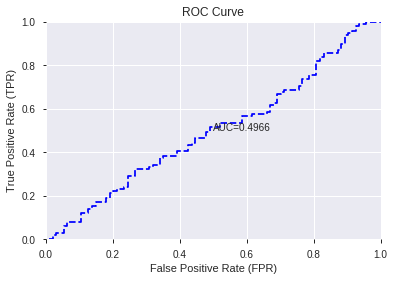

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


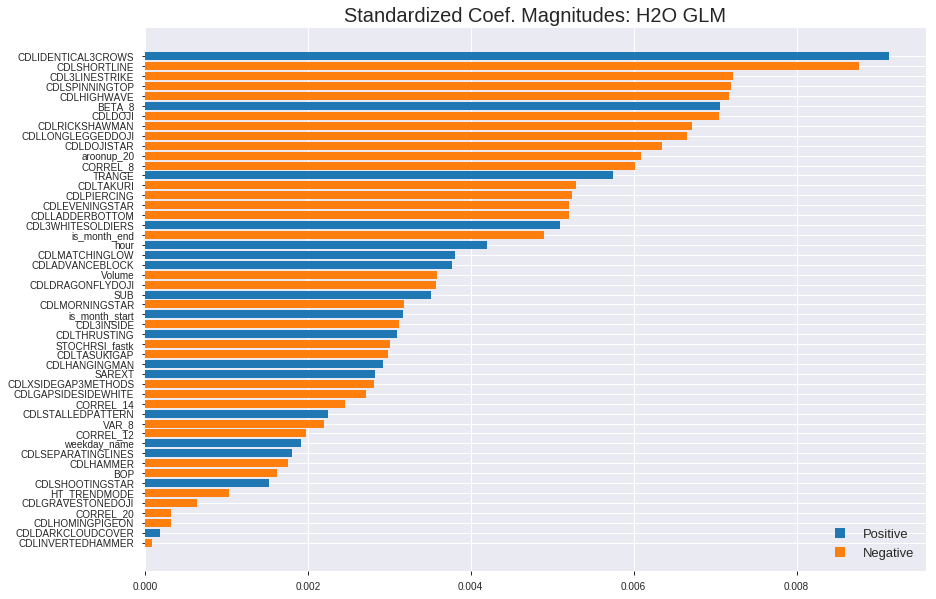

'log_likelihood'
--2019-08-25 12:42:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.50.26
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.50.26|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_124230_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_124230_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLIDENTICAL3CROWS',
 'CDLSHORTLINE',
 'CDL3LINESTRIKE',
 'CDLSPINNINGTOP',
 'CDLHIGHWAVE',
 'BETA_8',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJISTAR',
 'aroonup_20',
 'CORREL_8',
 'TRANGE',
 'CDLTAKURI',
 'CDLPIERCING',
 'CDLEVENINGSTAR',
 'CDLLADDERBOTTOM',
 'CDL3WHITESOLDIERS',
 'is_month_end',
 'hour',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'Volume',
 'CDLDRAGONFLYDOJI',
 'SUB',
 'CDLMORNINGSTAR',
 'is_month_start',
 'CDL3INSIDE',
 'CDLTHRUSTING',
 'STOCHRSI_fastk',
 'CDLTASUKIGAP',
 'CDLHANGINGMAN',
 'SAREXT',
 'CDLXSIDEGAP3METHODS',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_14',
 'CDLSTALLEDPATTERN',
 'VAR_8',
 'CORREL_12',
 'weekday_name',
 'CDLSEPARATINGLINES',
 'CDLHAMMER',
 'BOP',
 'CDLSHOOTINGSTAR',
 'HT_TRENDMODE',
 'CDLGRAVESTONEDOJI',
 'CORREL_20',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLINVERTEDHAMMER']

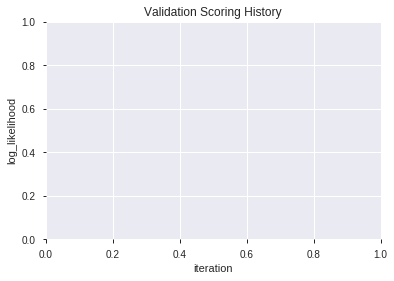

In [0]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

In [0]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_124242_model_7  0.522136  0.713072              0.500000  0.509157  0.259241
1  XGBoost_grid_1_AutoML_20190825_124242_model_5  0.516226  0.732773              0.500000  0.516228  0.266491
2  XGBoost_grid_1_AutoML_20190825_124242_model_6  0.507952  0.702080              0.478723  0.504284  0.254303
3               XGBoost_3_AutoML_20190825_124242  0.503654  0.700547              0.489362  0.503653  0.253667
4  XGBoost_grid_1_AutoML_20190825_124242_model_3  0.500107  0.706210              0.494681  0.506314  0.256354
5  XGBoost_grid_1_AutoML_20190825_124242_model_2  0.492156  0.702449              0.500000  0.504501  0.254521
6               XGBoost_1_AutoML_20190825_124242  0.491726  0.714495              0.494681  0.509957  0.260056
7  XGBoost_grid_1_AutoML_20190825_124242_model_1  0.490329  0.704608              0.494681  0.505555  0.255585
8               XGBoost_2_AutoML_20190825_124242  0.484634  0.712184              0.472598  0.509128  0.259211
9  XGBoost_grid_1_AutoML_20190825_124242_model_4  0.471739  0.710342              0.500000  0.508357  0.258427

variable  relative_importance  scaled_importance  percentage
0              SAREXT           541.196411           1.000000    0.095287
1                 BOP           535.449097           0.989380    0.094275
2              Volume           527.156677           0.974058    0.092815
3           CORREL_20           475.010315           0.877704    0.083634
4           CORREL_14           468.597473           0.865855    0.082505
5              BETA_8           466.705658           0.862359    0.082172
6               VAR_8           397.749023           0.734944    0.070031
7           CORREL_12           390.474060           0.721502    0.068750
8              TRANGE           375.509583           0.693851    0.066115
9            CORREL_8           343.059906           0.633892    0.060402
10         aroonup_20           272.591492           0.503683    0.047995
11     STOCHRSI_fastk           253.937088           0.469214    0.044710
12                SUB           235.031128           0.434281    0.041381
13               hour           172.158066           0.318106    0.030311
14       weekday_name            81.084274           0.149824    0.014276
15       CDLSHORTLINE            44.475197           0.082179    0.007831
16     CDLSPINNINGTOP            42.618362           0.078748    0.007504
17       HT_TRENDMODE            41.708897           0.077068    0.007344
18        CDLHIGHWAVE             7.693110           0.014215    0.001355
19            CDLDOJI             4.991632           0.009223    0.000879
20  CDLLONGLEGGEDDOJI             2.437842           0.004505    0.000429

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_124242_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16243183341907808
RMSE: 0.4030283283084181
LogLoss: 0.5108577498594498
Mean Per-Class Error: 0.11723914751976339
AUC: 0.9476027570660274
pr_auc: 0.9470181772861839
Gini: 0.8952055141320547
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4978675127029419: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      579  90   0.1345   (90.0/669.0)
1      69   610  0.1016   (69.0/679.0)
Total  648  700  0.118    (159.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497868     0.884699  201
max f2                       0.432437     0.913889  250
max f0point5                 0.544704     0.892917  163
max accuracy                 0.505361     0.882789  195
max precision                0.815398     1         0
max recall                   0.295017     1         352
max specificity              0.815398     1         0
max absolute_mcc             0.50172      0.765656  198
max min_per_class_accuracy   0.507159     0.878924  194
max mean_per_class_accuracy  0.505361     0.882761  195

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.760681           1.98527    1.98527            1                0.777007  1                           0.777007            0.0206186       0.0206186                  98.5272   98.5272
    2        0.0200297                   0.746276           1.98527    1.98527            1                0.753499  1                           0.765688            0.0191458       0.0397644                  98.5272   98.5272
    3        0.0304154                   0.730451           1.98527    1.98527            1                0.738671  1                           0.756463            0.0206186       0.0603829                  98.5272   98.5272
    4        0.0400593                   0.721032           1.98527    1.98527            1                0.725703  1                           0.749058            0.0191458       0.0795287                  98.5272   98.5272
    5        0.0504451                   0.714644           1.98527    1.98527            1                0.717522  1                           0.742565            0.0206186       0.100147                   98.5272   98.5272
    6        0.100148                    0.68419            1.95564    1.97057            0.985075         0.69901   0.992593                    0.720949            0.0972018       0.197349                   95.5642   97.0567
    7        0.150593                    0.65946            1.95608    1.96571            0.985294         0.672276  0.990148                    0.704645            0.0986745       0.296024                   95.6077   96.5713
    8        0.200297                    0.633958           1.92601    1.95586            0.970149         0.645747  0.985185                    0.690029            0.095729        0.391753                   92.6011   95.5861
    9        0.300445                    0.598513           1.83822    1.91665            0.925926         0.616127  0.965432                    0.665395            0.184094        0.575847                   83.8215   91.6646
    10       0.399852                    0.556929           1.65933    1.85268            0.835821         0.578085  0.93321                     0.643689            0.164948        0.740795                   65.9332   85.2675
    11       0.5                         0.510146           1.32351    1.74669            0.666667         0.533479  0.879822                    0.621615            0.132548        0.873343                   32.3515   74.6686
    12       0.600148                    0.46016            0.72058    1.57546            0.362963         0.483835  0.793572                    0.598623            0.0721649       0.945508                   -27.942   57.5457
    13       0.699555                    0.406487           0.370387   1.40422            0.186567         0.434541  0.707317                    0.575307            0.0368189       0.982327                   -62.9613  40.4217
    14       0.799703                    0.36491            0.147057   1.24678            0.0740741        0.384947  0.628015                    0.551468            0.0147275       0.997054                   -85.2943  24.6781
    15       0.899852                    0.311091           0.0147057  1.10966            0.00740741       0.338928  0.558945                    0.527813            0.00147275      0.998527                   -98.5294  10.9658
    16       1                           0.165841           0.0147057  1                  0.00740741       0.271476  0.503709                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.265921062000992
RMSE: 0.5156753455430966
LogLoss: 0.7274503264333063
Mean Per-Class Error: 0.4719828164854343
AUC: 0.483527990334273
pr_auc: 0.49121043767612665
Gini: -0.032944019331453966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22475853562355042: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    191  1        (191.0/191.0)
1      0    195  0        (0.0/195.0)
Total  0    386  0.4948   (191.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.224759     0.671256  385
max f2                       0.224759     0.836192  385
max f0point5                 0.224759     0.560667  385
max accuracy                 0.548918     0.528497  210
max precision                0.724735     0.75      11
max recall                   0.224759     1         385
max specificity              0.766847     0.994764  0
max absolute_mcc             0.633971     0.11138   71
max min_per_class_accuracy   0.560061     0.507853  193
max mean_per_class_accuracy  0.548918     0.528017  210

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 54.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.728638           0.989744  0.989744           0.5              0.748797  0.5                         0.748797            0.0102564       0.0102564                  -1.02564  -1.02564
    2        0.0207254                   0.726056           1.48462   1.23718            0.75             0.72736   0.625                       0.738079            0.0153846       0.025641                   48.4615   23.7179
    3        0.0310881                   0.723559           1.97949   1.48462            1                0.725373  0.75                        0.733843            0.0205128       0.0461538                  97.9487   48.4615
    4        0.0414508                   0.707101           0         1.11346            0                0.71359   0.5625                      0.72878             0               0.0461538                  -100      11.3462
    5        0.0518135                   0.696389           0.494872  0.989744           0.25             0.701423  0.5                         0.723309            0.00512821      0.0512821                  -50.5128  -1.02564
    6        0.101036                    0.670965           0.833468  0.913609           0.421053         0.679554  0.461538                    0.701992            0.0410256       0.0923077                  -16.6532  -8.63905
    7        0.150259                    0.647229           0.625101  0.819098           0.315789         0.656063  0.413793                    0.686946            0.0307692       0.123077                   -37.4899  -18.0902
    8        0.202073                    0.632171           0.791795  0.812097           0.4              0.637983  0.410256                    0.674392            0.0410256       0.164103                   -20.8205  -18.7903
    9        0.300518                    0.606995           1.09393   0.904421           0.552632         0.62059   0.456897                    0.656767            0.107692        0.271795                   9.39271   -9.55791
    10       0.401554                    0.58566            1.11663   0.957816           0.564103         0.59576   0.483871                    0.641417            0.112821        0.384615                   11.6634   -4.21836
    11       0.5                         0.560203           1.2502    1.01538            0.631579         0.571211  0.512953                    0.627594            0.123077        0.507692                   25.0202   1.53846
    12       0.601036                    0.530505           0.913609  0.998276           0.461538         0.545782  0.50431                     0.613841            0.0923077       0.6                        -8.63905  -0.172414
    13       0.699482                    0.500641           1.04184   1.00441            0.526316         0.515181  0.507407                    0.599955            0.102564        0.702564                   4.18354   0.440646
    14       0.800518                    0.459811           0.964366  0.999353           0.487179         0.482362  0.504854                    0.585114            0.0974359       0.8                        -3.56345  -0.0647249
    15       0.898964                    0.399546           0.833468  0.981187           0.421053         0.430452  0.495677                    0.568177            0.0820513       0.882051                   -16.6532  -1.88133
    16       1                           0.224759           1.16739   1                  0.589744         0.340515  0.505181                    0.5


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:43:01  6.380 sec   0                  0.5              0.693147            0.5             0                  1                0.496291                         0.5                0.693147              0.5               0                    1                  0.494819
    2019-08-25 12:43:01  6.444 sec   5                  0.4862           0.665857            0.782663        0.778069           1.98527          0.281899                         0.502098           0.697363              0.465727          0.484707             0.989744           0.492228
    2019-08-25 12:43:01  6.495 sec   10                 0.473714         0.641623            0.834981        0.82302            1.98527          0.253709                         0.50378            0.700786              0.475983          0.49873              1.48462            0.494819
    2019-08-25 12:43:01  6.551 sec   15                 0.463247         0.62158             0.859323        0.851124           1.98527          0.227003                         0.502091           0.697349              0.509491          0.539245             1.97949            0.494819
    2019-08-25 12:43:02  6.618 sec   20                 0.45311          0.602417            0.883137        0.876242           1.98527          0.209199                         0.502897           0.699157              0.523909          0.521669             1.48462            0.494819
    2019-08-25 12:43:02  6.698 sec   25                 0.443744         0.584832            0.895789        0.893952           1.98527          0.175816                         0.505333           0.704325              0.518351          0.516194             1.48462            0.494819
    2019-08-25 12:43:02  6.764 sec   30                 0.434841         0.56836             0.910366        0.911397           1.98527          0.158012                         0.508082           0.710141              0.504121          0.508647             0.494872           0.492228
    2019-08-25 12:43:02  6.838 sec   35                 0.426455         0.552994            0.92224         0.923869           1.98527          0.145401                         0.510227           0.714908              0.496469          0.503636             0.494872           0.494819
    2019-08-25 12:43:02  6.901 sec   40                 0.418582         0.538766            0.935992        0.937232           1.98527          0.129822                         0.513265           0.721559              0.480843          0.48884              0.494872           0.494819
    2019-08-25 12:43:02  6.975 sec   45                 0.410596         0.524346            0.94109         0.940398           1.98527          0.12908                          0.514154           0.723919              0.484401          0.489062             0.494872           0.494819
    2019-08-25 12:43:02  7.044 sec   50                 0.403028         0.510858            0.947603        0.947018           1.98527          0.117953                         0.515675           0.72745               0.483528          0.49121              0.989744           0.494819

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ----------------------
SAREXT             541.1964111328125      1.0                  0.0952871766302227
BOP                535.4490966796875      0.9893803537220527   0.09427526051958544
Volume             527.1566772460938      0.9740579693473368   0.09281523377327572
CORREL_20          475.01031494140625     0.8777041110585565   0.08363394665950927
CORREL_14          468.59747314453125     0.8658547313048144   0.08250485271795586
---                ---                    ---                  ---
CDLSPINNINGTOP     42.61836242675781      0.07874842025938535  0.007503714630607059
HT_TRENDMODE       41.70889663696289      0.0770679475676111   0.0073435871324037
CDLHIGHWAVE        7.693110466003418      0.01421500643343233  0.0013545078288222183
CDLDOJI            4.991631507873535      0.00922332706794052  0.0008788647954411623
CDLLONGLEGGEDDOJI  2.4378418922424316     0.00450454186704533  0.00042922507652338153


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5492227979274611)

('F1', 0.678082191780822)

('auc', 0.5221362561788094)

('logloss', 0.7130722134567529)

('mean_per_class_error', 0.44987105093488067)

('rmse', 0.5091573772733319)

('mse', 0.25924123483185796)

xgboost prediction progress: |████████████████████████████████████████████| 100%



ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25924123483185796
RMSE: 0.5091573772733319
LogLoss: 0.7130722134567529
Mean Per-Class Error: 0.44987105093488067
AUC: 0.5221362561788094
pr_auc: 0.5342238440920778
Gini: 0.044272512357618865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2812137007713318: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    94   1        (94.0/94.0)
1      0    99   0        (0.0/99.0)
Total  0    193  0.487    (94.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281214     0.678082  192
max f2                       0.281214     0.840407  192
max f0point5                 0.281214     0.568312  192
max accuracy                 0.552879     0.549223  89
max precision                0.684354     0.666667  17
max recall                   0.281214     1         192
max specificity              0.749787     0.989362  0
max absolute_mcc             0.716644     0.102108  4
max min_per_class_accuracy   0.546396     0.535354  94
max mean_per_class_accuracy  0.552879     0.550129  89

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 54.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.735655           0.974747  0.974747           0.5              0.746248  0.5                         0.746248            0.010101        0.010101                   -2.52525  -2.52525
    2        0.0207254                   0.718346           0         0.487374           0                0.731164  0.25                        0.738706            0               0.010101                   -100      -51.2626
    3        0.0310881                   0.708548           0.974747  0.649832           0.5              0.713227  0.333333                    0.730213            0.010101        0.020202                   -2.52525  -35.0168
    4        0.0414508                   0.703119           1.94949   0.974747           1                0.706987  0.5                         0.724406            0.020202        0.040404                   94.9495   -2.52525
    5        0.0518135                   0.696283           1.94949   1.1697             1                0.699696  0.6                         0.719464            0.020202        0.0606061                  94.9495   16.9697
    6        0.103627                    0.677942           1.36465   1.26717            0.7              0.6869    0.65                        0.703182            0.0707071       0.131313                   36.4646   26.7172
    7        0.150259                    0.645581           0.866442  1.14281            0.444444         0.66271   0.586207                    0.690622            0.040404        0.171717                   -13.3558  14.2807
    8        0.202073                    0.621833           0.779798  1.04973            0.4              0.638428  0.538462                    0.677239            0.040404        0.212121                   -22.0202  4.9728
    9        0.300518                    0.599817           1.12865   1.07558            0.578947         0.611253  0.551724                    0.655623            0.111111        0.323232                   12.8655   7.55834
    10       0.398964                    0.576259           1.12865   1.08868            0.578947         0.587704  0.558442                    0.638864            0.111111        0.434343                   12.8655   8.8679
    11       0.502591                    0.545339           0.974747  1.06519            0.5              0.558284  0.546392                    0.622249            0.10101         0.535354                   -2.52525  6.5188
    12       0.601036                    0.516705           0.923445  1.04197            0.473684         0.533159  0.534483                    0.607657            0.0909091       0.626263                   -7.6555   4.19714
    13       0.699482                    0.493067           0.82084   1.01085            0.421053         0.505283  0.518519                    0.593249            0.0808081       0.707071                   -17.916   1.08492
    14       0.797927                    0.468063           0.718235  0.974747           0.368421         0.479232  0.5                         0.579182            0.0707071       0.777778                   -28.1765  -2.52525
    15       0.896373                    0.4083             1.12865   0.991651           0.578947         0.439047  0.508671                    0.563791            0.111111        0.888889                   12.8655   -0.834939
    16       1                           0.281214           1.07222   1                  0.55             0.352665  0.512953                    0.541913     

This function is available for GLM models only


--2019-08-25 12:43:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_124242_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_124242_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SAREXT',
 'BOP',
 'Volume',
 'CORREL_20',
 'CORREL_14',
 'BETA_8',
 'VAR_8',
 'CORREL_12',
 'TRANGE',
 'CORREL_8',
 'aroonup_20',
 'STOCHRSI_fastk',
 'SUB',
 'hour',
 'weekday_name',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'HT_TRENDMODE',
 'CDLHIGHWAVE',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_124313_model_1  0.525038  0.692655              0.478723  0.499759  0.249759

variable  relative_importance  scaled_importance    percentage
0                 aroondown_30         7.750798e-03           1.000000  1.170722e-02
1                 aroondown_24         7.542386e-03           0.973111  1.139243e-02
2           CDLIDENTICAL3CROWS         6.761977e-03           0.872423  1.021365e-02
3                 aroondown_14         6.540142e-03           0.843802  9.878582e-03
4                 CDLSHORTLINE         6.284007e-03           0.810756  9.491702e-03
...                        ...                  ...                ...           ...
1027   BBANDS_lowerband_20_1_2         5.966284e-07           0.000077  9.011796e-07
1028                     TSF_8         2.495429e-07           0.000032  3.769230e-07
1029   BBANDS_lowerband_20_2_2         2.096817e-07           0.000027  3.167145e-07
1030   BBANDS_lowerband_24_3_4         1.421810e-07           0.000018  2.147578e-07
1031  BBANDS_middleband_12_5_5         3.683928e-08           0.000005  5.564402e-08

[1032 rows x 4 columns]

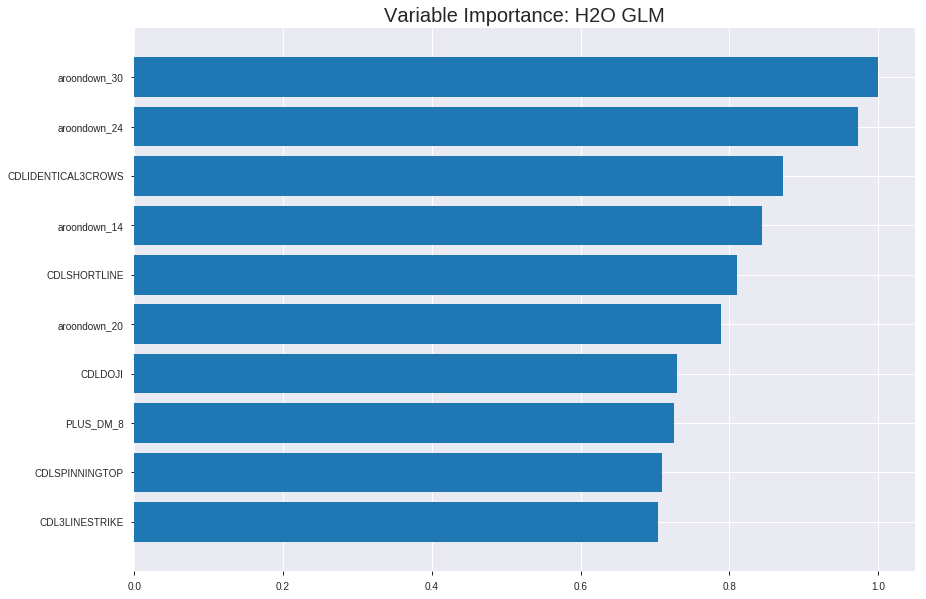

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_124313_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24654920646183154
RMSE: 0.4965372155859332
LogLoss: 0.6862239599125806
Null degrees of freedom: 1347
Residual degrees of freedom: 315
Null deviance: 1868.6506141329141
Residual deviance: 1850.059795924317
AIC: 3916.059795924317
AUC: 0.588271682395856
pr_auc: 0.580973185607464
Gini: 0.17654336479171207
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4321405619027035: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    661   0.988    (661.0/669.0)
1      0    679   0        (0.0/679.0)
Total  8    1340  0.4904   (661.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432141     0.67261   391
max f2                       0.432141     0.837032  391
max f0point5                 0.503395     0.576644  204
max accuracy                 0.50381      0.573442  202
max precision                0.600765     1         0
max recall                   0.432141     1         391
max specificity              0.600765     1         0
max absolute_mcc             0.512784     0.150521  164
max min_per_class_accuracy   0.504234     0.571001  201
max mean_per_class_accuracy  0.50381      0.573413  202

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103858                   0.5649             1.41805   1.41805            0.714286         0.575959  0.714286                    0.575959            0.0147275       0.0147275                  41.8052    41.8052
    2        0.0200297                   0.559896           1.22171   1.32351            0.615385         0.562598  0.666667                    0.569526            0.011782        0.0265096                  22.1706    32.3515
    3        0.0304154                   0.553333           1.27625   1.30737            0.642857         0.556355  0.658537                    0.565029            0.0132548       0.0397644                  27.6247    30.7375
    4        0.0400593                   0.549442           1.52713   1.36028            0.769231         0.551533  0.685185                    0.56178             0.0147275       0.0544919                  52.7133    36.0279
    5        0.0504451                   0.547057           0.992636  1.28459            0.5              0.54846   0.647059                    0.559037            0.0103093       0.0648012                  -0.736377  28.4588
    6        0.100148                    0.536806           1.18524   1.23528            0.597015         0.540849  0.622222                    0.55001             0.0589102       0.123711                   18.5237    23.5281
    7        0.150593                    0.529108           1.197     1.22246            0.602941         0.532744  0.615764                    0.544226            0.0603829       0.184094                   19.7003    22.2458
    8        0.200297                    0.524356           1.2445    1.22793            0.626866         0.526841  0.618519                    0.539912            0.0618557       0.24595                    24.4499    22.7928
    9        0.300445                    0.5172             1.11763   1.19116            0.562963         0.520661  0.6                         0.533495            0.111929        0.357879                   11.7635    19.1163
    10       0.399852                    0.510368           1.02227   1.14917            0.514925         0.514157  0.57885                     0.528687            0.10162         0.459499                   2.22672    14.9174
    11       0.5                         0.504159           1.11763   1.14286            0.562963         0.507322  0.575668                    0.524408            0.111929        0.571429                   11.7635    14.2857
    12       0.600148                    0.498123           0.794109  1.08466            0.4              0.501151  0.546354                    0.520527            0.0795287       0.650957                   -20.5891   8.46606
    13       0.699555                    0.490766           0.963005  1.06737            0.485075         0.494376  0.537646                    0.516811            0.095729        0.746686                   -3.69947   6.73734
    14       0.799703                    0.482034           0.941166  1.05157            0.474074         0.486621  0.529685                    0.51303             0.0942563       0.840943                   -5.88338   5.15683
    15       0.899852                    0.470586           0.82352   1.02619            0.414815         0.476689  0.5169                      0.508986            0.0824742       0.923417                   -17.648    2.61878
    16       1                           0.407641           0.764698  1                  0.385185         0.456298  0.503709                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25674600182558605
RMSE: 0.506701097122935
LogLoss: 0.7068059231443103
Null degrees of freedom: 385
Residual degrees of freedom: -647
Null deviance: 535.0715182997042
Residual deviance: 545.6541726674076
AIC: 2611.6541726674077
AUC: 0.45743052758759567
pr_auc: 0.4769594354994049
Gini: -0.08513894482480866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4233826876994885: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    190  0.9948   (190.0/191.0)
1      0    195  0        (0.0/195.0)
Total  1    385  0.4922   (190.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423383     0.672414  384
max f2                       0.423383     0.83691   384
max f0point5                 0.423383     0.56196   384
max accuracy                 0.425809     0.507772  382
max precision                0.649048     1         0
max recall                   0.423383     1         384
max specificity              0.649048     1         0
max absolute_mcc             0.556336     0.103169  179
max min_per_class_accuracy   0.553082     0.465969  192
max mean_per_class_accuracy  0.595253     0.506779  36

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 54.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.622715           0.989744  0.989744           0.5              0.631367  0.5                         0.631367            0.0102564       0.0102564                  -1.02564  -1.02564
    2        0.0207254                   0.616092           0.494872  0.742308           0.25             0.619178  0.375                       0.625273            0.00512821      0.0153846                  -50.5128  -25.7692
    3        0.0310881                   0.610266           1.48462   0.989744           0.75             0.612857  0.5                         0.621134            0.0153846       0.0307692                  48.4615   -1.02564
    4        0.0414508                   0.605644           0         0.742308           0                0.60737   0.375                       0.617693            0               0.0307692                  -100      -25.7692
    5        0.0518135                   0.601419           0.494872  0.692821           0.25             0.602642  0.35                        0.614683            0.00512821      0.0358974                  -50.5128  -30.7179
    6        0.101036                    0.593819           1.45857   1.06588            0.736842         0.597354  0.538462                    0.606241            0.0717949       0.107692                   45.857    6.58777
    7        0.150259                    0.588042           0.833468  0.989744           0.421053         0.590667  0.5                         0.601139            0.0410256       0.148718                   -16.6532  -1.02564
    8        0.202073                    0.581067           0.890769  0.964366           0.45             0.584382  0.487179                    0.596842            0.0461538       0.194872                   -10.9231  -3.56345
    9        0.300518                    0.569546           0.88556   0.93855            0.447368         0.575065  0.474138                    0.589708            0.0871795       0.282051                   -11.444   -6.145
    10       0.401554                    0.562193           0.812097  0.906733           0.410256         0.56597   0.458065                    0.583735            0.0820513       0.364103                   -18.7903  -9.32672
    11       0.5                         0.552763           1.04184   0.933333           0.526316         0.557182  0.471503                    0.578507            0.102564        0.466667                   4.18354   -6.66667
    12       0.601036                    0.544464           0.913609  0.930018           0.461538         0.548759  0.469828                    0.573506            0.0923077       0.558974                   -8.63905  -6.99823
    13       0.699482                    0.533365           1.09393   0.953086           0.552632         0.538338  0.481481                    0.568557            0.107692        0.666667                   9.39271   -4.69136
    14       0.800518                    0.519102           1.16739   0.980134           0.589744         0.526548  0.495146                    0.563255            0.117949        0.784615                   16.739    -1.98656
    15       0.898964                    0.486214           0.989744  0.981187           0.5              0.506595  0.495677                    0.55705             0.0974359       0.882051                   -1.02564  -1.88133
    16       1                           0.422377           1.16739   1                  0.589744         0.455444  0.505181                    0.546


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 12:43:16  0.000 sec   2            3.4       1033          1.37245           1.41361
    2019-08-25 12:43:18  1.640 sec   4            2.5       1033          1.36914           1.41894
    2019-08-25 12:43:20  3.272 sec   6            1.8       1033          1.36515           1.42582
    2019-08-25 12:43:21  4.890 sec   8            1.3       1033          1.36049           1.43456
    2019-08-25 12:43:23  6.498 sec   10           0.95      1033          1.35518           1.44543

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5440414507772021)

('F1', 0.6875000000000001)

('auc', 0.5250376101439932)

('logloss', 0.6926554728262776)

('mean_per_class_error', 0.4572856221792392)

('rmse', 0.49975906450210766)

('mse', 0.2497591225520218)

glm prediction progress: |████████████████████████████████████████████████| 100%



ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2497591225520218
RMSE: 0.49975906450210766
LogLoss: 0.6926554728262776
Null degrees of freedom: 192
Residual degrees of freedom: -840
Null deviance: 267.49124794756074
Residual deviance: 267.3650125109431
AIC: 2333.365012510943
AUC: 0.5250376101439932
pr_auc: 0.5422210836153192
Gini: 0.05007522028798639
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47221685347368736: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      4    90   0.9574   (90.0/94.0)
1      0    99   0        (0.0/99.0)
Total  4    189  0.4663   (90.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472217     0.6875    188
max f2                       0.472217     0.846154  188
max f0point5                 0.472217     0.578947  188
max accuracy                 0.529492     0.544041  148
max precision                0.620025     1         0
max recall                   0.472217     1         188
max specificity              0.620025     1         0
max absolute_mcc             0.587295     0.165041  11
max min_per_class_accuracy   0.548833     0.505051  94
max mean_per_class_accuracy  0.557667     0.542714  67

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 54.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.607768           0.974747  0.974747           0.5              0.614526  0.5                         0.614526            0.010101        0.010101                   -2.52525  -2.52525
    2        0.0207254                   0.600715           0.974747  0.974747           0.5              0.604872  0.5                         0.609699            0.010101        0.020202                   -2.52525  -2.52525
    3        0.0310881                   0.594676           1.94949   1.29966            1                0.599455  0.666667                    0.606284            0.020202        0.040404                   94.9495   29.9663
    4        0.0414508                   0.590953           1.94949   1.46212            1                0.592535  0.75                        0.602847            0.020202        0.0606061                  94.9495   46.2121
    5        0.0518135                   0.58845            1.94949   1.5596             1                0.590001  0.8                         0.600278            0.020202        0.0808081                  94.9495   55.9596
    6        0.103627                    0.57631            0.779798  1.1697             0.4              0.582324  0.6                         0.591301            0.040404        0.121212                   -22.0202  16.9697
    7        0.150259                    0.57068            0.866442  1.07558            0.444444         0.573485  0.551724                    0.585772            0.040404        0.161616                   -13.3558  7.55834
    8        0.202073                    0.568004           0.974747  1.04973            0.5              0.56929   0.538462                    0.581546            0.0505051       0.212121                   -2.52525  4.9728
    9        0.300518                    0.562001           0.923445  1.00836            0.473684         0.564649  0.517241                    0.57601             0.0909091       0.30303                    -7.6555   0.835946
    10       0.398964                    0.55385            1.33386   1.08868            0.684211         0.557369  0.558442                    0.571411            0.131313        0.434343                   33.3865   8.8679
    11       0.502591                    0.548699           0.682323  1.00489            0.35             0.551475  0.515464                    0.5673              0.0707071       0.505051                   -31.7677  0.48943
    12       0.601036                    0.54311            0.923445  0.991553           0.473684         0.54565   0.508621                    0.563754            0.0909091       0.59596                    -7.6555   -0.844653
    13       0.699482                    0.535483           1.12865   1.01085            0.578947         0.540195  0.518519                    0.560438            0.111111        0.707071                   12.8655   1.08492
    14       0.797927                    0.526972           1.12865   1.02538            0.578947         0.531188  0.525974                    0.556829            0.111111        0.818182                   12.8655   2.53837
    15       0.896373                    0.509806           0.923445  1.01419            0.473684         0.519912  0.520231                    0.552775            0.0909091       0.909091                   -7.6555   1.41881
    16       1                           0.457519           0.877273  1                  0.45             0.484242  0.512953                    0.545673      

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


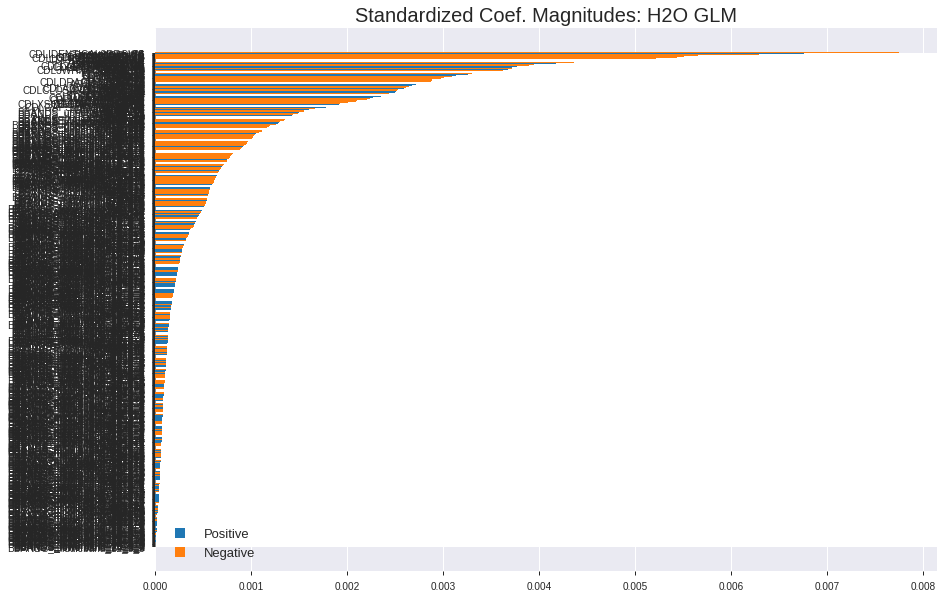

'log_likelihood'
--2019-08-25 12:43:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_124313_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_124313_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

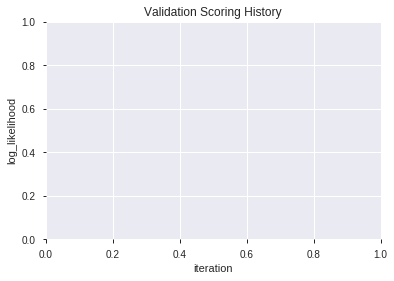

In [0]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [0]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [0]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [0]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_124350_model_3  0.577369  0.692206              0.461691  0.499344  0.249345
1  XGBoost_grid_1_AutoML_20190825_124350_model_5  0.559209  0.713667              0.483774  0.507829  0.257890
2               XGBoost_3_AutoML_20190825_124350  0.534386  0.704219              0.467548  0.505071  0.255096
3  XGBoost_grid_1_AutoML_20190825_124350_model_1  0.520954  0.712884              0.484043  0.509283  0.259369
4  XGBoost_grid_1_AutoML_20190825_124350_model_7  0.513325  0.726775              0.472867  0.514928  0.265151
5  XGBoost_grid_1_AutoML_20190825_124350_model_2  0.513110  0.697086              0.473404  0.501934  0.251938
6  XGBoost_grid_1_AutoML_20190825_124350_model_6  0.506985  0.714377              0.433484  0.509703  0.259797
7  XGBoost_grid_1_AutoML_20190825_124350_model_4  0.503116  0.703746              0.500000  0.505021  0.255047
8               XGBoost_1_AutoML_20190825_124350  0.501397  0.723890              0.494681  0.513862  0.264054
9               XGBoost_2_AutoML_20190825_124350  0.497099  0.708408              0.456641  0.507185  0.257237

variable  relative_importance  scaled_importance  percentage
0                     MFI_20            89.739517           1.000000    0.018524
1                     BETA_8            88.959320           0.991306    0.018363
2                     Volume            76.194641           0.849065    0.015728
3                        BOP            75.482704           0.841131    0.015582
4                     TRANGE            62.407150           0.695426    0.012882
..                       ...                  ...                ...         ...
284                 SAR_0.08             1.390309           0.015493    0.000287
285                 TRIMA_20             1.320559           0.014715    0.000273
286  BBANDS_lowerband_12_7_3             1.313707           0.014639    0.000271
287               MACDFIX_12             1.172425           0.013065    0.000242
288                ROCR100_8             0.388048           0.004324    0.000080

[289 rows x 4 columns]

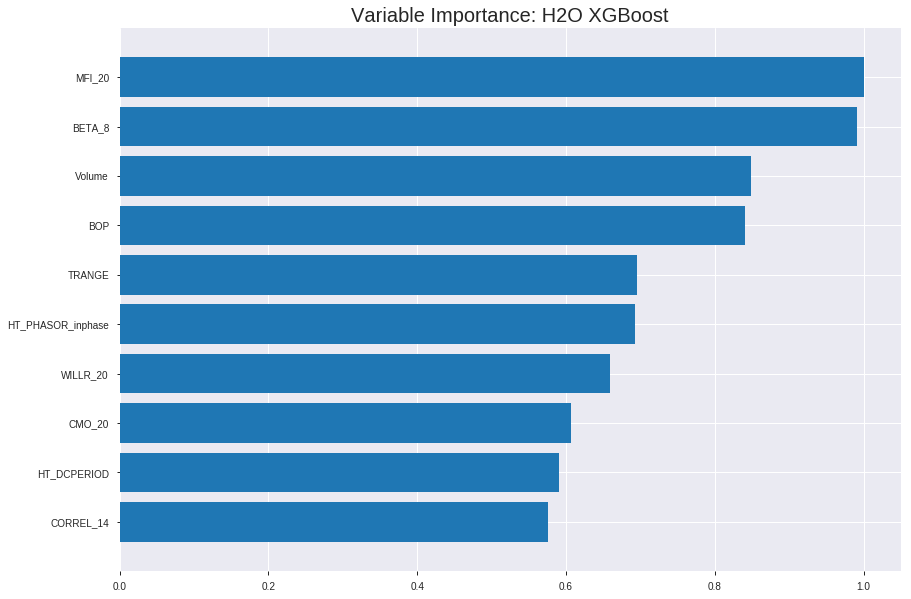

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_124350_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17250351818996118
RMSE: 0.4153354285273063
LogLoss: 0.5328787179580039
Mean Per-Class Error: 0.12255889365130734
AUC: 0.945753559155621
pr_auc: 0.9477741262193567
Gini: 0.891507118311242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48966074734926224: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      573  96   0.1435   (96.0/669.0)
1      69   610  0.1016   (69.0/679.0)
Total  642  706  0.1224   (165.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489661     0.880866  209
max f2                       0.447419     0.911248  248
max f0point5                 0.534273     0.902896  172
max accuracy                 0.489661     0.877596  209
max precision                0.798599     1         0
max recall                   0.304738     1         362
max specificity              0.798599     1         0
max absolute_mcc             0.489661     0.755714  209
max min_per_class_accuracy   0.50009      0.875934  201
max mean_per_class_accuracy  0.489661     0.877441  209

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.758706           1.98527    1.98527            1                0.776746  1                           0.776746            0.0206186       0.0206186                  98.5272   98.5272
    2        0.0200297                   0.73414            1.98527    1.98527            1                0.74366   1                           0.760816            0.0191458       0.0397644                  98.5272   98.5272
    3        0.0304154                   0.720806           1.98527    1.98527            1                0.726063  1                           0.748949            0.0206186       0.0603829                  98.5272   98.5272
    4        0.0400593                   0.709444           1.98527    1.98527            1                0.714389  1                           0.740629            0.0191458       0.0795287                  98.5272   98.5272
    5        0.0504451                   0.698243           1.98527    1.98527            1                0.704435  1                           0.733177            0.0206186       0.100147                   98.5272   98.5272
    6        0.100148                    0.668555           1.98527    1.98527            1                0.682045  1                           0.707801            0.0986745       0.198822                   98.5272   98.5272
    7        0.150593                    0.642523           1.98527    1.98527            1                0.654527  1                           0.689955            0.100147        0.298969                   98.5272   98.5272
    8        0.200297                    0.620798           1.83712    1.94851            0.925373         0.630145  0.981481                    0.675114            0.0913108       0.39028                    83.7118   94.8508
    9        0.300445                    0.580832           1.88233    1.92645            0.948148         0.599545  0.97037                     0.649924            0.188513        0.578792                   88.2332   92.645
    10       0.399852                    0.542698           1.71859    1.87477            0.865672         0.562321  0.944341                    0.628145            0.170839        0.749632                   71.8594   87.4775
    11       0.5                         0.501666           1.22057    1.74374            0.614815         0.522219  0.878338                    0.606929            0.122239        0.87187                    22.0575   74.3741
    12       0.600148                    0.464789           0.691169   1.5681             0.348148         0.481448  0.789864                    0.585989            0.0692194       0.94109                    -30.8831  56.8095
    13       0.699555                    0.426262           0.32594    1.39159            0.164179         0.44488   0.700954                    0.565938            0.0324006       0.97349                    -67.406   39.1585
    14       0.799703                    0.390088           0.191174   1.24126            0.0962963        0.408966  0.625232                    0.54628             0.0191458       0.992636                   -80.8826  24.1256
    15       0.899852                    0.341462           0.0588229  1.10966            0.0296296        0.369981  0.558945                    0.526659            0.00589102      0.998527                   -94.1177  10.9658
    16       1                           0.18882            0.0147057  1                  0.00740741       0.296924  0.503709                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2659187031992469
RMSE: 0.5156730584384324
LogLoss: 0.727550351066277
Mean Per-Class Error: 0.46568666935159087
AUC: 0.5094106591488791
pr_auc: 0.5065744356815092
Gini: 0.018821318297758127
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38094836473464966: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    188  0.9843   (188.0/191.0)
1      0    195  0        (0.0/195.0)
Total  3    383  0.487    (188.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.380948     0.67474    382
max f2                       0.380948     0.838349   382
max f0point5                 0.425569     0.565319   377
max accuracy                 0.579023     0.536269   265
max precision                0.74308      0.666667   8
max recall                   0.380948     1          382
max specificity              0.765986     0.994764   0
max absolute_mcc             0.380948     0.0894256  382
max min_per_class_accuracy   0.61846      0.502618   193
max mean_per_class_accuracy  0.579023     0.534313   265

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 60.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.760971           0.989744  0.989744           0.5              0.763541  0.5                         0.763541            0.0102564       0.0102564                  -1.02564  -1.02564
    2        0.0207254                   0.74529            1.48462   1.23718            0.75             0.756395  0.625                       0.759968            0.0153846       0.025641                   48.4615   23.7179
    3        0.0310881                   0.734634           0.494872  0.989744           0.25             0.739029  0.5                         0.752988            0.00512821      0.0307692                  -50.5128  -1.02564
    4        0.0414508                   0.730147           0.494872  0.866026           0.25             0.732256  0.4375                      0.747805            0.00512821      0.0358974                  -50.5128  -13.3974
    5        0.0518135                   0.724163           0.989744  0.890769           0.5              0.727221  0.45                        0.743688            0.0102564       0.0461538                  -1.02564  -10.9231
    6        0.101036                    0.704447           0.937652  0.913609           0.473684         0.714708  0.461538                    0.72957             0.0461538       0.0923077                  -6.23482  -8.63905
    7        0.150259                    0.686335           1.35439   1.058              0.684211         0.694625  0.534483                    0.718122            0.0666667       0.158974                   35.4386   5.80018
    8        0.202073                    0.67916            1.28667   1.11663            0.65             0.682906  0.564103                    0.709093            0.0666667       0.225641                   28.6667   11.6634
    9        0.300518                    0.656219           0.729285  0.989744           0.368421         0.668736  0.5                         0.695872            0.0717949       0.297436                   -27.0715  -1.02564
    10       0.401554                    0.638664           0.964366  0.983358           0.487179         0.646274  0.496774                    0.683393            0.0974359       0.394872                   -3.56345  -1.66419
    11       0.5                         0.618593           1.09393   1.00513            0.552632         0.626956  0.507772                    0.672281            0.107692        0.502564                   9.39271   0.512821
    12       0.601036                    0.600709           1.16739   1.0324             0.589744         0.609349  0.521552                    0.661702            0.117949        0.620513                   16.739    3.2405
    13       0.699482                    0.574279           1.09393   1.04106            0.552632         0.587566  0.525926                    0.651268            0.107692        0.728205                   9.39271   4.10636
    14       0.800518                    0.534862           0.761341  1.00576            0.384615         0.556953  0.508091                    0.639364            0.0769231       0.805128                   -23.8659  0.575886
    15       0.898964                    0.482609           0.937652  0.9983             0.473684         0.508207  0.504323                    0.625001            0.0923077       0.897436                   -6.23482  -0.169955
    16       1                           0.361493           1.01512   1                  0.512821         0.439965  0.505181                    0.60630


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:44:06  4.629 sec   0                  0.5              0.693147            0.5             0                  1                0.496291                         0.5                0.693147              0.5               0                    1                  0.494819
    2019-08-25 12:44:07  5.187 sec   5                  0.489165         0.671668            0.757395        0.746593           1.58822          0.339763                         0.501236           0.695639              0.496845          0.494233             0.395897           0.489637
    2019-08-25 12:44:07  5.408 sec   10                 0.481046         0.655771            0.796366        0.798386           1.84347          0.307122                         0.502873           0.698987              0.482561          0.47875              0.989744           0.487047
    2019-08-25 12:44:07  5.664 sec   15                 0.468917         0.632368            0.856194        0.863173           1.98527          0.217359                         0.50228            0.697873              0.508847          0.500901             0                  0.479275
    2019-08-25 12:44:07  5.917 sec   20                 0.462067         0.619203            0.869204        0.872416           1.98527          0.209199                         0.503715           0.700958              0.520217          0.510595             0.494872           0.476684
    2019-08-25 12:44:08  6.183 sec   25                 0.451827         0.599957            0.896837        0.898228           1.98527          0.190653                         0.507909           0.70991               0.518566          0.517939             0.494872           0.494819
    2019-08-25 12:44:08  6.450 sec   30                 0.443468         0.584356            0.910293        0.910978           1.98527          0.169881                         0.50903            0.712395              0.523292          0.521972             0.494872           0.494819
    2019-08-25 12:44:08  6.708 sec   35                 0.435891         0.570281            0.920366        0.924587           1.98527          0.167656                         0.511725           0.718406              0.510968          0.508428             0.494872           0.481865
    2019-08-25 12:44:09  6.975 sec   40                 0.428535         0.55678             0.92956         0.931844           1.98527          0.151335                         0.512354           0.719809              0.508793          0.507269             0                  0.479275
    2019-08-25 12:44:09  7.250 sec   45                 0.42096          0.543087            0.939313        0.942632           1.98527          0.132047                         0.516112           0.728399              0.497919          0.50081              1.48462            0.479275
    2019-08-25 12:44:09  7.508 sec   50                 0.415335         0.532879            0.945754        0.947774           1.98527          0.122404                         0.515673           0.72755               0.509411          0.506574             0.989744           0.487047

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
MFI_20                   89.73951721191406      1.0                    0.01852448112835692
BETA_8                   88.95932006835938      0.9913059801546257     0.018363428921801726
Volume                   76.19464111328125      0.8490645312181982     0.015728479885308733
BOP                      75.48270416259766      0.8411311594684662     0.01558151829004658
TRANGE                   62.40715026855469      0.6954255182940671     0.012882396889816277
---                      ---                    ---                    ---
SAR_0.08                 1.3903093338012695     0.015492721345025114   0.0002869946241828102
TRIMA_20                 1.3205585479736328     0.014715463031244299   0.000272596317217319
BBANDS_lowerband_12_7_3  1.313706636428833      0.014639109694858285   0.00027118191127834917
MACDFIX_12               1.1724252700805664     0.013064760169279271   0.00024201790320232304
ROCR100_8                0.3880481719970703     0.0043241615739999986  8.010284947352914e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5751295336787565)

('F1', 0.6859205776173284)

('auc', 0.5773694390715668)

('logloss', 0.6922056731000686)

('mean_per_class_error', 0.4235439501396948)

('rmse', 0.4993440722679279)

('mse', 0.24934450250911758)

xgboost prediction progress: |████████████████████████████████████████████| 100%



ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24934450250911758
RMSE: 0.4993440722679279
LogLoss: 0.6922056731000686
Mean Per-Class Error: 0.4235439501396948
AUC: 0.5773694390715668
pr_auc: 0.5747992808805179
Gini: 0.15473887814313358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4543774724006653: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      11   83   0.883    (83.0/94.0)
1      4    95   0.0404   (4.0/99.0)
Total  15   178  0.4508   (87.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454377     0.685921  177
max f2                       0.406292     0.84471   189
max f0point5                 0.518665     0.596798  146
max accuracy                 0.597222     0.57513   86
max precision                0.683225     0.727273  21
max recall                   0.406292     1         189
max specificity              0.75565      0.989362  0
max absolute_mcc             0.631885     0.160792  50
max min_per_class_accuracy   0.588158     0.56383   96
max mean_per_class_accuracy  0.597222     0.576456  86

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 58.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.739387           0.974747  0.974747           0.5              0.754557  0.5                         0.754557            0.010101        0.010101                   -2.52525  -2.52525
    2        0.0207254                   0.736255           0.974747  0.974747           0.5              0.737787  0.5                         0.746172            0.010101        0.020202                   -2.52525  -2.52525
    3        0.0310881                   0.726267           0.974747  0.974747           0.5              0.734234  0.5                         0.742193            0.010101        0.030303                   -2.52525  -2.52525
    4        0.0414508                   0.722026           1.94949   1.21843            1                0.723762  0.625                       0.737585            0.020202        0.0505051                  94.9495   21.8434
    5        0.0518135                   0.712424           0.974747  1.1697             0.5              0.718542  0.6                         0.733776            0.010101        0.0606061                  -2.52525  16.9697
    6        0.103627                    0.690997           1.5596    1.36465            0.8              0.700286  0.7                         0.717031            0.0808081       0.141414                   55.9596   36.4646
    7        0.150259                    0.669774           0.866442  1.21003            0.444444         0.676246  0.62069                     0.704374            0.040404        0.181818                   -13.3558  21.0031
    8        0.202073                    0.655829           1.36465   1.24968            0.7              0.663727  0.641026                    0.693951            0.0707071       0.252525                   36.4646   24.9676
    9        0.300518                    0.625771           0.923445  1.14281            0.473684         0.637106  0.586207                    0.675329            0.0909091       0.343434                   -7.6555   14.2807
    10       0.398964                    0.607235           1.02605   1.114              0.526316         0.61844   0.571429                    0.661292            0.10101         0.444444                   2.605     11.3997
    11       0.502591                    0.588158           1.1697    1.12548            0.6              0.597435  0.57732                     0.648125            0.121212        0.565657                   16.9697   12.5482
    12       0.601036                    0.568439           0.82084   1.07558            0.421053         0.580661  0.551724                    0.637075            0.0808081       0.646465                   -17.916   7.55834
    13       0.699482                    0.543677           0.923445  1.05417            0.473684         0.555077  0.540741                    0.625535            0.0909091       0.737374                   -7.6555   5.41713
    14       0.797927                    0.505372           1.02605   1.0507             0.526316         0.525462  0.538961                    0.613188            0.10101         0.838384                   2.605     5.07018
    15       0.896373                    0.458723           0.82084   1.02546            0.421053         0.476946  0.526012                    0.598225            0.0808081       0.919192                   -17.916   2.54569
    16       1                           0.362424           0.779798  1                  0.4              0.43166   0.512953                    0.580964      

This function is available for GLM models only


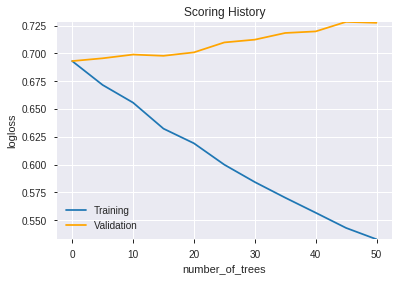

--2019-08-25 12:44:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.38.236
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.38.236|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_124350_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_124350_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [0]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_124435_model_1  0.544487  1.040219              0.435633  0.555635  0.308731
1  DeepLearning_grid_1_AutoML_20190825_124435_model_6  0.529228  0.698964              0.484043  0.502727  0.252734
2  DeepLearning_grid_1_AutoML_20190825_124435_model_7  0.523748  0.817458              0.478723  0.536417  0.287743
3  DeepLearning_grid_1_AutoML_20190825_124435_model_2  0.511928  0.923724              0.478723  0.555341  0.308404
4               DeepLearning_1_AutoML_20190825_124435  0.505910  0.830331              0.500000  0.543638  0.295543
5  DeepLearning_grid_1_AutoML_20190825_124435_model_3  0.501612  0.856841              0.473404  0.539767  0.291348
6  DeepLearning_grid_1_AutoML_20190825_124435_model_8  0.494305  0.693985              0.489093  0.500415  0.250416
7  DeepLearning_grid_1_AutoML_20190825_124435_model_5  0.493660  0.711540              0.489362  0.508665  0.258740
8  DeepLearning_grid_1_AutoML_20190825_124435_model_4  0.476897  0.926359              0.468085  0.574721  0.330304
9  DeepLearning_grid_1_AutoML_20190825_124435_model_9  0.473028  0.693742              0.489362  0.500295  0.250295

variable  relative_importance  scaled_importance  percentage
0     CDL3WHITESOLDIERS             1.000000           1.000000    0.025696
1        CDL3LINESTRIKE             0.957062           0.957062    0.024593
2        CDLEVENINGSTAR             0.942406           0.942406    0.024216
3     CDLSTALLEDPATTERN             0.919247           0.919247    0.023621
4        CDLMORNINGSTAR             0.918845           0.918845    0.023611
5                SAREXT             0.908470           0.908470    0.023344
6           CDLPIERCING             0.889496           0.889496    0.022857
7       CDLHOMINGPIGEON             0.889061           0.889061    0.022845
8          CDLTHRUSTING             0.888463           0.888463    0.022830
9   CDLGAPSIDESIDEWHITE             0.887137           0.887137    0.022796
10         HT_TRENDMODE             0.852480           0.852480    0.021906
11   CDLIDENTICAL3CROWS             0.852034           0.852034    0.021894
12    CDLDARKCLOUDCOVER             0.851313           0.851313    0.021876
13      CDLLADDERBOTTOM             0.844136           0.844136    0.021691
14       STOCHRSI_fastk             0.836443           0.836443    0.021493
15       is_month_start             0.835339           0.835339    0.021465
16           aroonup_20             0.820382           0.820382    0.021081
17         CDLTASUKIGAP             0.815041           0.815041    0.020943
18      CDLADVANCEBLOCK             0.811935           0.811935    0.020864
19                 hour             0.811432           0.811432    0.020851
20   CDLSEPARATINGLINES             0.792212           0.792212    0.020357
21          CDLDOJISTAR             0.787928           0.787928    0.020247
22            CDLTAKURI             0.787766           0.787766    0.020243
23               Volume             0.783112           0.783112    0.020123
24         is_month_end             0.778281           0.778281    0.019999
25           CDL3INSIDE             0.770541           0.770541    0.019800
26            CORREL_14             0.769211           0.769211    0.019766
27         weekday_name             0.766447           0.766447    0.019695
28      CDLSHOOTINGSTAR             0.752037           0.752037    0.019324
29        CDLHANGINGMAN             0.751889           0.751889    0.019321
30            CORREL_20             0.741549           0.741549    0.019055
31         CDLSHORTLINE             0.740334           0.740334    0.019024
32               BETA_8             0.732534           0.732534    0.018823
33             CORREL_8             0.732230           0.732230    0.018816
34     CDLDRAGONFLYDOJI             0.727225           0.727225    0.018687
35  CDLXSIDEGAP3METHODS             0.707986           0.707986    0.018193
36       CDLMATCHINGLOW             0.692641           0.692641    0.017798
37    CDLINVERTEDHAMMER             0.687789           0.687789    0.017674
38                  SUB             0.682996           0.682996    0.017550
39                VAR_8             0.682495           0.682495    0.017538
40            CDLHAMMER             0.679251           0.679251    0.017454
41    CDLGRAVESTONEDOJI             0.673137           0.673137    0.017297
42                  BOP             0.670784           0.670784    0.017237
43               TRANGE             0.667068           0.667068    0.017141
44            CORREL_12             0.663726           0.663726    0.017055
45       CDLSPINNINGTOP             0.645731           0.645731    0.016593
46       CDLRICKSHAWMAN             0.644719           0.644719    0.016567
47          CDLHIGHWAVE             0.633125           0.633125    0.016269
48    CDLLONGLEGGEDDOJI             0.627283           0.627283    0.016119
49              CDLDOJI             0.613501           0.613501    0.015765

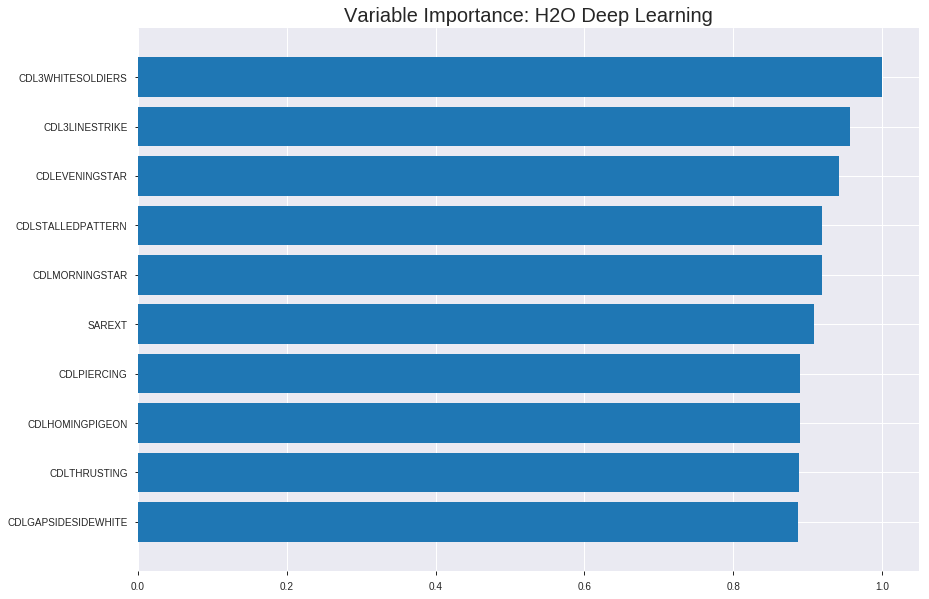

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_124435_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22812992577730692
RMSE: 0.4776294858750943
LogLoss: 0.7669724720891415
Mean Per-Class Error: 0.323118716304422
AUC: 0.7321954161906082
pr_auc: 0.7057621960854342
Gini: 0.4643908323812165
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20774011912798818: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      310  359  0.5366   (359.0/669.0)
1      99   580  0.1458   (99.0/679.0)
Total  409  939  0.3398   (458.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.20774      0.716934  301
max f2                       4.4132e-05   0.835384  399
max f0point5                 0.434341     0.688623  194
max accuracy                 0.38501      0.676558  217
max precision                0.88741      0.883333  25
max recall                   4.4132e-05   1         399
max specificity              0.999912     0.994021  0
max absolute_mcc             0.434341     0.360309  194
max min_per_class_accuracy   0.35788      0.672646  230
max mean_per_class_accuracy  0.38501      0.676881  217

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 38.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.998834           1.41805   1.41805            0.714286         0.999912   0.714286                    0.999912            0.0147275       0.0147275                  41.8052   41.8052
    2        0.0200297                   0.95811            1.83256   1.61763            0.923077         0.977832   0.814815                    0.989281            0.017673        0.0324006                  83.2559   61.7629
    3        0.0304154                   0.929652           1.84347   1.69474            0.928571         0.948536   0.853659                    0.975368            0.0191458       0.0515464                  84.3467   69.4745
    4        0.0400593                   0.891673           1.83256   1.72792            0.923077         0.907364   0.87037                     0.958997            0.017673        0.0692194                  83.2559   72.7922
    5        0.0504451                   0.874891           1.70166   1.72252            0.857143         0.88393    0.867647                    0.943542            0.017673        0.0868925                  70.1662   72.2516
    6        0.100148                    0.782571           1.48155   1.60292            0.746269         0.823652   0.807407                    0.884041            0.0736377       0.16053                    48.1547   60.2924
    7        0.150593                    0.708052           1.51815   1.57453            0.764706         0.745453   0.793103                    0.837618            0.0765832       0.237113                   51.815    57.4526
    8        0.200297                    0.633417           1.36302   1.52204            0.686567         0.669844   0.766667                    0.795985            0.0677467       0.30486                    36.3023   52.2042
    9        0.300445                    0.527088           1.41175   1.48528            0.711111         0.578659   0.748148                    0.723543            0.141384        0.446244                   41.1749   48.5278
    10       0.399852                    0.433958           1.28895   1.43647            0.649254         0.481393   0.723562                    0.663342            0.12813         0.574374                   28.8946   43.6468
    11       0.5                         0.358278           0.970578  1.34315            0.488889         0.395555   0.676558                    0.609706            0.0972018       0.671576                   -2.94224  34.3152
    12       0.600148                    0.286583           0.92646   1.27362            0.466667         0.321577   0.641533                    0.561625            0.0927835       0.764359                   -7.35395  27.3617
    13       0.699555                    0.204513           0.918559  1.22316            0.462687         0.241534   0.616119                    0.51614             0.0913108       0.85567                    -8.14411  22.3164
    14       0.799703                    0.13012            0.573523  1.14181            0.288889         0.166831   0.575139                    0.472395            0.0574374       0.913108                   -42.6477  14.1808
    15       0.899852                    0.0506767          0.426466  1.06219            0.214815         0.0927877  0.535037                    0.430147            0.0427099       0.955817                   -57.3534  6.21944
    16       1                           6.73202e-11        0.441172  1                  0.222222         0.0173339  0.503709                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3417989283321482
RMSE: 0.5846357227643109
LogLoss: 1.1900778328639128
Mean Per-Class Error: 0.4633105114780507
AUC: 0.47960800107396967
pr_auc: 0.49500375699294236
Gini: -0.04078399785206066
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.962418519699765e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    190  0.9948   (190.0/191.0)
1      0    195  0        (0.0/195.0)
Total  1    385  0.4922   (190.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.96242e-05  0.672414  384
max f2                       2.96242e-05  0.83691   384
max f0point5                 2.96242e-05  0.56196   384
max accuracy                 0.64507      0.533679  80
max precision                0.64507      0.592593  80
max recall                   2.96242e-05  1         384
max specificity              1            0.994764  0
max absolute_mcc             0.046076     0.153112  347
max min_per_class_accuracy   0.377595     0.482051  191
max mean_per_class_accuracy  0.64507      0.536689  80

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 39.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.989991           0.494872  0.494872           0.25             0.999486   0.25                        0.999486            0.00512821      0.00512821                 -50.5128  -50.5128
    2        0.0207254                   0.960901           0.494872  0.494872           0.25             0.978458   0.25                        0.988972            0.00512821      0.0102564                  -50.5128  -50.5128
    3        0.0310881                   0.907495           0.494872  0.494872           0.25             0.93505    0.25                        0.970998            0.00512821      0.0153846                  -50.5128  -50.5128
    4        0.0414508                   0.888705           1.48462   0.742308           0.75             0.897987   0.375                       0.952745            0.0153846       0.0307692                  48.4615   -25.7692
    5        0.0518135                   0.874429           0.989744  0.791795           0.5              0.88177    0.4                         0.93855             0.0102564       0.0410256                  -1.02564  -20.8205
    6        0.101036                    0.78649            1.2502    1.01512            0.631579         0.835157   0.512821                    0.888179            0.0615385       0.102564                   25.0202   1.51216
    7        0.150259                    0.713114           1.04184   1.02387            0.526316         0.749191   0.517241                    0.842648            0.0512821       0.153846                   4.18354   2.38727
    8        0.202073                    0.664141           1.48462   1.14201            0.75             0.685915   0.576923                    0.80246             0.0769231       0.230769                   48.4615   14.2012
    9        0.300518                    0.525324           0.833468  1.04094            0.421053         0.585947   0.525862                    0.731534            0.0820513       0.312821                   -16.6532  4.09372
    10       0.401554                    0.444831           0.913609  1.0089             0.461538         0.485519   0.509677                    0.669633            0.0923077       0.405128                   -8.63905  0.889992
    11       0.5                         0.371539           0.781377  0.964103           0.394737         0.412058   0.487047                    0.618919            0.0769231       0.482051                   -21.8623  -3.58974
    12       0.601036                    0.281713           1.01512   0.972679           0.512821         0.332245   0.491379                    0.570728            0.102564        0.584615                   1.51216   -2.7321
    13       0.699482                    0.195888           0.989744  0.975081           0.5              0.226867   0.492593                    0.522333            0.0974359       0.682051                   -1.02564  -2.49193
    14       0.800518                    0.124697           0.761341  0.948104           0.384615         0.161169   0.478964                    0.476749            0.0769231       0.758974                   -23.8659  -5.18961
    15       0.898964                    0.0480275          0.989744  0.952664           0.5              0.085531   0.481268                    0.433907            0.0974359       0.85641                    -1.02564  -4.73361
    16       1                           4.97774e-06        1.42117   1                  0.717949         0.0231019  0.505181         


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:44:36  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:44:41  5.386 sec   2556 obs/sec      10        1             13480      0.559064         0.979488            -0.250278      0.592891        0.581434           1.55986          0.440653                         0.593197           1.25309               -0.407683        0.510458          0.51863              0.989744           0.492228
    2019-08-25 12:44:46  10.601 sec  2591 obs/sec      20        2             26960      0.522478         0.8883              -0.0919928     0.6414          0.613272           1.55986          0.439911                         0.578068           1.19308               -0.336795        0.51423           0.504937             0.494872           0.494819
    2019-08-25 12:44:51  15.651 sec  2630 obs/sec      30        3             40440      0.500883         0.852142            -0.00358953    0.677519        0.644118           1.41805          0.420623                         0.587843           1.2117                -0.382387        0.494617          0.491404             0.494872           0.494819
    2019-08-25 12:45:01  25.164 sec  2716 obs/sec      50        5             67400      0.477629         0.766972            0.0874301      0.732195        0.705762           1.41805          0.339763                         0.584636           1.19008               -0.367343        0.479608          0.495004             0.494872           0.492228
    2019-08-25 12:45:10  34.330 sec  2783 obs/sec      70        7             94360      0.461035         0.695258            0.149739       0.754486        0.721718           1.41805          0.316766                         0.596736           1.22828               -0.424527        0.477863          0.488829             0.494872           0.492228
    2019-08-25 12:45:19  43.082 sec  2849 obs/sec      90        9             121320     0.435515         0.636482            0.241265       0.799358        0.767965           1.70166          0.281899                         0.587253           1.32017               -0.379612        0.491126          0.50651              0.989744           0.492228
    2019-08-25 12:45:19  43.165 sec  2849 obs/sec      90        9             121320     0.477629         0.766972            0.0874301      0.732195        0.705762           1.41805          0.339763                         0.584636           1.19008               -0.367343        0.479608          0.495004             0.494872           0.492228

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
CDL3WHITESOLDIERS  1.0                    1.0                  0.025696208020637618
CDL3LINESTRIKE     0.9570620656013489     0.9570620656013489   0.02459286592635339
CDLEVENINGSTAR     0.9424057006835938     0.9424057006835938   0.02421625292460038
CDLSTALLEDPATTERN  0.9192473888397217     0.9192473888397217   0.023621172126053445
CDLMORNINGSTAR     0.9188447594642639     0.9188447594642639   0.023610826077866465
---                ---                    ---                  ---
CDLSPINNINGTOP     0.6457312107086182     0.6457312107086182   0.016592843515786836
CDLRICKSHAWMAN     0.6447190046310425     0.6447190046310425   0.016566833657857695
CDLHIGHWAVE        0.633124589920044      0.633124589920044    0.016268901165566337
CDLLONGLEGGEDDOJI  0.6272825598716736     0.6272825598716736   0.016118783146180597
CDLDOJI            0.6135011315345764     0.6135011315345764   0.015764652696809038


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5751295336787565)

('F1', 0.7028985507246375)

('auc', 0.5444874274661509)

('logloss', 1.0402186252683154)

('mean_per_class_error', 0.43536428110896197)

('rmse', 0.5556353031350778)

('mse', 0.30873059009000975)

deeplearning prediction progress: |███████████████████████████████████████| 100%


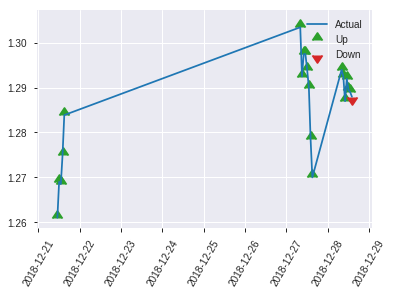


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.30873059009000975
RMSE: 0.5556353031350778
LogLoss: 1.0402186252683154
Mean Per-Class Error: 0.43536428110896197
AUC: 0.5444874274661509
pr_auc: 0.5174211197472444
Gini: 0.08897485493230173
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03822284222285329: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      14   80   0.8511   (80.0/94.0)
1      2    97   0.0202   (2.0/99.0)
Total  16   177  0.4249   (82.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0382228    0.702899  176
max f2                       0.0277418    0.847751  181
max f0point5                 0.0382228    0.600991  176
max accuracy                 0.0464181    0.57513   174
max precision                0.541179     0.616667  59
max recall                   0.00804796   1         188
max specificity              1            0.989362  0
max absolute_mcc             0.0382228    0.233361  176
max min_per_class_accuracy   0.37734      0.531915  96
max mean_per_class_accuracy  0.0464181    0.564636  174

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 40.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.997068           0         0                  0                1          0                           1                   0               0                          -100      -100
    2        0.0207254                   0.940906           1.94949   0.974747           1                0.987607   0.5                         0.993803            0.020202        0.020202                   94.9495   -2.52525
    3        0.0310881                   0.905884           0         0.649832           0                0.924998   0.333333                    0.970868            0               0.020202                   -100      -35.0168
    4        0.0414508                   0.841488           0.974747  0.731061           0.5              0.874536   0.375                       0.946785            0.010101        0.030303                   -2.52525  -26.8939
    5        0.0518135                   0.819879           0.974747  0.779798           0.5              0.838077   0.4                         0.925044            0.010101        0.040404                   -2.52525  -22.0202
    6        0.103627                    0.760588           0.779798  0.779798           0.4              0.781199   0.4                         0.853121            0.040404        0.0808081                  -22.0202  -22.0202
    7        0.150259                    0.705422           0.649832  0.739464           0.333333         0.736772   0.37931                     0.817013            0.030303        0.111111                   -35.0168  -26.0536
    8        0.202073                    0.660153           1.36465   0.899767           0.7              0.686195   0.461538                    0.78347             0.0707071       0.181818                   36.4646   -10.0233
    9        0.300518                    0.54259            1.74428   1.17642            0.894737         0.593506   0.603448                    0.72124             0.171717        0.353535                   74.4285   17.6419
    10       0.398964                    0.445305           0.82084   1.08868            0.421053         0.500432   0.558442                    0.666755            0.0808081       0.434343                   -17.916   8.8679
    11       0.502591                    0.37734            0.974747  1.06519            0.5              0.41108    0.546392                    0.614038            0.10101         0.535354                   -2.52525  6.5188
    12       0.601036                    0.326612           1.02605   1.05878            0.526316         0.358048   0.543103                    0.572109            0.10101         0.636364                   2.605     5.87774
    13       0.699482                    0.242083           0.718235  1.01085            0.368421         0.277983   0.518519                    0.530714            0.0707071       0.707071                   -28.1765  1.08492
    14       0.797927                    0.193652           1.23126   1.03804            0.631579         0.213678   0.532468                    0.491599            0.121212        0.828283                   23.126    3.80428
    15       0.896373                    0.0490769          1.23126   1.05926            0.631579         0.122675   0.543353                    0.451081            0.121212        0.949495                   23.126    5.92632
    16       1                           1.46303e-05        0.487374  1                  0.25             0.0221284  0.512953                 

This function is available for GLM models only


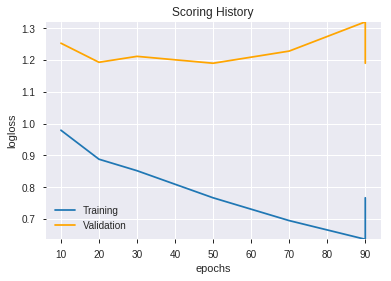

--2019-08-25 12:52:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_124435_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_124435_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDL3WHITESOLDIERS',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGSTAR',
 'SAREXT',
 'CDLPIERCING',
 'CDLHOMINGPIGEON',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'HT_TRENDMODE',
 'CDLIDENTICAL3CROWS',
 'CDLDARKCLOUDCOVER',
 'CDLLADDERBOTTOM',
 'STOCHRSI_fastk',
 'is_month_start',
 'aroonup_20',
 'CDLTASUKIGAP',
 'CDLADVANCEBLOCK',
 'hour',
 'CDLSEPARATINGLINES',
 'CDLDOJISTAR',
 'CDLTAKURI',
 'Volume',
 'is_month_end',
 'CDL3INSIDE',
 'CORREL_14',
 'weekday_name',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'CORREL_20',
 'CDLSHORTLINE',
 'BETA_8',
 'CORREL_8',
 'CDLDRAGONFLYDOJI',
 'CDLXSIDEGAP3METHODS',
 'CDLMATCHINGLOW',
 'CDLINVERTEDHAMMER',
 'SUB',
 'VAR_8',
 'CDLHAMMER',
 'CDLGRAVESTONEDOJI',
 'BOP',
 'TRANGE',
 'CORREL_12',
 'CDLSPINNINGTOP',
 'CDLRICKSHAWMAN',
 'CDLHIGHWAVE',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI']

In [0]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_125252_model_1  0.496561  0.692568              0.473136  0.499711  0.249711

variable  relative_importance  scaled_importance  percentage
0    CDLIDENTICAL3CROWS             0.009132           1.000000    0.046962
1          CDLSHORTLINE             0.008767           0.960042    0.045086
2        CDL3LINESTRIKE             0.007217           0.790342    0.037116
3        CDLSPINNINGTOP             0.007192           0.787559    0.036986
4           CDLHIGHWAVE             0.007172           0.785420    0.036885
5                BETA_8             0.007054           0.772457    0.036276
6               CDLDOJI             0.007044           0.771319    0.036223
7        CDLRICKSHAWMAN             0.006716           0.735443    0.034538
8     CDLLONGLEGGEDDOJI             0.006655           0.728736    0.034223
9           CDLDOJISTAR             0.006349           0.695208    0.032649
10           aroonup_20             0.006092           0.667119    0.031329
11             CORREL_8             0.006015           0.658639    0.030931
12               TRANGE             0.005748           0.629411    0.029559
13            CDLTAKURI             0.005287           0.578988    0.027191
14          CDLPIERCING             0.005243           0.574136    0.026963
15       CDLEVENINGSTAR             0.005204           0.569857    0.026762
16      CDLLADDERBOTTOM             0.005201           0.569593    0.026749
17    CDL3WHITESOLDIERS             0.005101           0.558549    0.026231
18         is_month_end             0.004894           0.535878    0.025166
19                 hour             0.004201           0.460058    0.021605
20       CDLMATCHINGLOW             0.003808           0.416985    0.019583
21      CDLADVANCEBLOCK             0.003767           0.412562    0.019375
22               Volume             0.003580           0.392074    0.018413
23     CDLDRAGONFLYDOJI             0.003569           0.390840    0.018355
24                  SUB             0.003518           0.385202    0.018090
25       CDLMORNINGSTAR             0.003184           0.348619    0.016372
26       is_month_start             0.003163           0.346355    0.016266
27           CDL3INSIDE             0.003118           0.341488    0.016037
28         CDLTHRUSTING             0.003091           0.338429    0.015893
29       STOCHRSI_fastk             0.003010           0.329561    0.015477
30         CDLTASUKIGAP             0.002986           0.327002    0.015357
31        CDLHANGINGMAN             0.002927           0.320574    0.015055
32               SAREXT             0.002826           0.309428    0.014531
33  CDLXSIDEGAP3METHODS             0.002809           0.307562    0.014444
34  CDLGAPSIDESIDEWHITE             0.002719           0.297795    0.013985
35            CORREL_14             0.002458           0.269196    0.012642
36    CDLSTALLEDPATTERN             0.002250           0.246373    0.011570
37                VAR_8             0.002205           0.241410    0.011337
38            CORREL_12             0.001973           0.216006    0.010144
39         weekday_name             0.001914           0.209578    0.009842
40   CDLSEPARATINGLINES             0.001805           0.197665    0.009283
41            CDLHAMMER             0.001754           0.192039    0.009019
42                  BOP             0.001618           0.177201    0.008322
43      CDLSHOOTINGSTAR             0.001526           0.167103    0.007848
44         HT_TRENDMODE             0.001037           0.113562    0.005333
45    CDLGRAVESTONEDOJI             0.000638           0.069862    0.003281
46            CORREL_20             0.000327           0.035801    0.001681
47      CDLHOMINGPIGEON             0.000322           0.035222    0.001654
48    CDLDARKCLOUDCOVER             0.000187           0.020435    0.000960
49    CDLINVERTEDHAMMER             0.000082           0.009012    0.000423

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_125252_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24867842489657588
RMSE: 0.4986766737040904
LogLoss: 0.690501161754749
Null degrees of freedom: 1347
Residual degrees of freedom: 1297
Null deviance: 1868.6506141329141
Residual deviance: 1861.5911320908033
AIC: 1963.5911320908033
AUC: 0.5754560804489147
pr_auc: 0.572864353719169
Gini: 0.15091216089782944
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48019341817129946: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      41   628   0.9387   (628.0/669.0)
1      14   665   0.0206   (14.0/679.0)
Total  55   1293  0.4763   (642.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.480193     0.674442  357
max f2                       0.464883     0.836825  392
max f0point5                 0.495914     0.571668  289
max accuracy                 0.503954     0.558605  193
max precision                0.556318     1         0
max recall                   0.464883     1         392
max specificity              0.556318     1         0
max absolute_mcc             0.503864     0.118536  195
max min_per_class_accuracy   0.505588     0.554559  167
max mean_per_class_accuracy  0.503954     0.557827  193

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain         cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -----------  -----------------
    1        0.0103858                   0.520736           1.70166   1.70166            0.857143         0.53221   0.857143                    0.53221             0.017673        0.017673                   70.1662      70.1662
    2        0.0200297                   0.517859           0.610853  1.17646            0.307692         0.51906   0.592593                    0.525878            0.00589102      0.0235641                  -38.9147     17.6458
    3        0.0304154                   0.516487           0.992636  1.11369            0.5              0.517269  0.560976                    0.522939            0.0103093       0.0338733                  -0.736377    11.3689
    4        0.0400593                   0.515627           1.52713   1.21322            0.769231         0.515993  0.611111                    0.521267            0.0147275       0.0486009                  52.7133      21.3222
    5        0.0504451                   0.515067           0.992636  1.16781            0.5              0.515307  0.588235                    0.52004             0.0103093       0.0589102                  -0.736377    16.7807
    6        0.100148                    0.512954           1.42228   1.2941             0.716418         0.51382   0.651852                    0.516953            0.0706922       0.129602                   42.2285      29.4104
    7        0.150593                    0.511034           1.16781   1.2518             0.588235         0.511982  0.630542                    0.515288            0.0589102       0.188513                   16.7807      25.1797
    8        0.200297                    0.50997            1.03708   1.19852            0.522388         0.510454  0.603704                    0.514088            0.0515464       0.240059                   3.70826      19.8516
    9        0.300445                    0.508146           0.999989  1.13234            0.503704         0.50902   0.57037                     0.512399            0.100147        0.340206                   -0.00109093  13.2341
    10       0.399852                    0.506788           1.06671   1.11603            0.537313         0.507427  0.562152                    0.511163            0.106038        0.446244                   6.67136      11.6025
    11       0.5                         0.505579           1.08822   1.11046            0.548148         0.506153  0.559347                    0.510159            0.108984        0.555228                   8.82234      11.0457
    12       0.600148                    0.504032           0.985283  1.08957            0.496296         0.504878  0.548826                    0.509278            0.0986745       0.653903                   -1.47166     8.95686
    13       0.699555                    0.502244           0.918559  1.06527            0.462687         0.503232  0.536585                    0.508419            0.0913108       0.745214                   -8.14411     6.52681
    14       0.799703                    0.499232           0.882343  1.04236            0.444444         0.500714  0.525046                    0.507454            0.0883652       0.833579                   -11.7657     4.23601
    15       0.899852                    0.492328           0.867638  1.02291            0.437037         0.496912  0.515251                    0.506281            0.0868925       0.920471                   -13.2362     2.29145
    16       1                           0.453258           0.794109  1                  0.4              0.48



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2510029822692015
RMSE: 0.5010019783086704
LogLoss: 0.6951542867548819
Null degrees of freedom: 385
Residual degrees of freedom: 335
Null deviance: 535.0715182997042
Residual deviance: 536.6591093747688
AIC: 638.6591093747688
AUC: 0.4656732447308363
pr_auc: 0.492925840930102
Gini: -0.06865351053832736
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4584214153996698: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    191  1        (191.0/191.0)
1      0    195  0        (0.0/195.0)
Total  0    386  0.4948   (191.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.458421     0.671256  385
max f2                       0.458421     0.836192  385
max f0point5                 0.458421     0.560667  385
max accuracy                 0.510445     0.512953  92
max precision                0.525484     0.75      3
max recall                   0.458421     1         385
max specificity              0.531452     0.994764  0
max absolute_mcc             0.493675     0.15933   341
max min_per_class_accuracy   0.506465     0.482051  191
max mean_per_class_accuracy  0.510445     0.51564   92

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.522925           1.48462   1.48462            0.75             0.528084  0.75                        0.528084            0.0153846       0.0153846                  48.4615   48.4615
    2        0.0207254                   0.519009           0.989744  1.23718            0.5              0.520768  0.625                       0.524426            0.0102564       0.025641                   -1.02564  23.7179
    3        0.0310881                   0.517896           0.494872  0.989744           0.25             0.518425  0.5                         0.522426            0.00512821      0.0307692                  -50.5128  -1.02564
    4        0.0414508                   0.517552           0.989744  0.989744           0.5              0.517752  0.5                         0.521257            0.0102564       0.0410256                  -1.02564  -1.02564
    5        0.0518135                   0.51724            1.48462   1.08872            0.75             0.517414  0.55                        0.520489            0.0153846       0.0564103                  48.4615   8.87179
    6        0.101036                    0.513722           0.729285  0.913609           0.368421         0.514955  0.461538                    0.517793            0.0358974       0.0923077                  -27.0715  -8.63905
    7        0.150259                    0.511669           1.2502    1.02387            0.631579         0.51294   0.517241                    0.516203            0.0615385       0.153846                   25.0202   2.38727
    8        0.202073                    0.511063           0.989744  1.01512            0.5              0.511404  0.512821                    0.514973            0.0512821       0.205128                   -1.02564  1.51216
    9        0.300518                    0.509222           1.04184   1.02387            0.526316         0.510194  0.517241                    0.513407            0.102564        0.307692                   4.18354   2.38727
    10       0.401554                    0.507632           0.862853  0.983358           0.435897         0.5085    0.496774                    0.512172            0.0871795       0.394872                   -13.7147  -1.66419
    11       0.5                         0.506438           0.88556   0.964103           0.447368         0.50696   0.487047                    0.511146            0.0871795       0.482051                   -11.444   -3.58974
    12       0.601036                    0.504957           0.862853  0.947082           0.435897         0.505695  0.478448                    0.51023             0.0871795       0.569231                   -13.7147  -5.29178
    13       0.699482                    0.502646           1.09393   0.967749           0.552632         0.503944  0.488889                    0.509345            0.107692        0.676923                   9.39271   -3.22507
    14       0.800518                    0.499548           0.812097  0.948104           0.410256         0.500876  0.478964                    0.508276            0.0820513       0.758974                   -18.7903  -5.18961
    15       0.898964                    0.492416           1.04184   0.958368           0.526316         0.496846  0.48415                     0.507024            0.102564        0.861538                   4.18354   -4.16316
    16       1                           0.458421           1.37041   1                  0.692308         0.481906  0.505181                    0.504487


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 12:52:52  0.000 sec   2            2.4       51            1.381             1.39031
    2019-08-25 12:52:52  0.024 sec   4            1.5       51            1.37869           1.39238
    2019-08-25 12:52:52  0.047 sec   6            0.92      51            1.37578           1.39527
    2019-08-25 12:52:52  0.065 sec   8            0.57      51            1.37234           1.39916
    2019-08-25 12:52:52  0.084 sec   10           0.35      51            1.36861           1.40422

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.538860103626943)

('F1', 0.687719298245614)

('auc', 0.4965613582634859)

('logloss', 0.6925682392014029)

('mean_per_class_error', 0.47136256178809366)

('rmse', 0.4997113469147782)

('mse', 0.2497114302353818)

glm prediction progress: |████████████████████████████████████████████████| 100%



ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2497114302353818
RMSE: 0.4997113469147782
LogLoss: 0.6925682392014029
Null degrees of freedom: 192
Residual degrees of freedom: 142
Null deviance: 267.49124794756074
Residual deviance: 267.3313403317415
AIC: 369.3313403317415
AUC: 0.4965613582634859
pr_auc: 0.5076925278533025
Gini: -0.006877283473028184
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47765081028386835: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      6    88   0.9362   (88.0/94.0)
1      1    98   0.0101   (1.0/99.0)
Total  7    186  0.4611   (89.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.477651     0.687719  185
max f2                       0.471051     0.846154  188
max f0point5                 0.477651     0.581257  185
max accuracy                 0.479753     0.53886   183
max precision                0.513656     0.571429  13
max recall                   0.471051     1         188
max specificity              0.525358     0.989362  0
max absolute_mcc             0.471051     0.149298  188
max min_per_class_accuracy   0.506709     0.510638  96
max mean_per_class_accuracy  0.509038     0.528637  56

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 50.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.518737           0         0                  0                0.522453  0                           0.522453            0               0                          -100      -100
    2        0.0207254                   0.518059           1.94949   0.974747           1                0.51839   0.5                         0.520421            0.020202        0.020202                   94.9495   -2.52525
    3        0.0310881                   0.517371           0.974747  0.974747           0.5              0.517864  0.5                         0.519569            0.010101        0.030303                   -2.52525  -2.52525
    4        0.0414508                   0.516637           0         0.731061           0                0.517     0.375                       0.518927            0               0.030303                   -100      -26.8939
    5        0.0518135                   0.51478            1.94949   0.974747           1                0.515899  0.5                         0.518321            0.020202        0.0505051                  94.9495   -2.52525
    6        0.103627                    0.512294           0.974747  0.974747           0.5              0.513286  0.5                         0.515803            0.0505051       0.10101                    -2.52525  -2.52525
    7        0.150259                    0.511473           1.08305   1.00836            0.555556         0.511903  0.517241                    0.514593            0.0505051       0.151515                   8.30527   0.835946
    8        0.202073                    0.510431           1.1697    1.04973            0.6              0.510991  0.538462                    0.513669            0.0606061       0.212121                   16.9697   4.9728
    9        0.300518                    0.508963           1.12865   1.07558            0.578947         0.50958   0.551724                    0.51233             0.111111        0.323232                   12.8655   7.55834
    10       0.398964                    0.507677           0.82084   1.01272            0.421053         0.508317  0.519481                    0.51134             0.0808081       0.40404                    -17.916   1.27246
    11       0.502591                    0.506709           1.07222   1.02499            0.55             0.507072  0.525773                    0.51046             0.111111        0.515152                   7.22222   2.49922
    12       0.601036                    0.50527            0.61563   0.957941           0.315789         0.505802  0.491379                    0.509697            0.0606061       0.575758                   -38.437   -4.20585
    13       0.699482                    0.503146           1.12865   0.981968           0.578947         0.50448   0.503704                    0.508963            0.111111        0.686869                   12.8655   -1.80322
    14       0.797927                    0.500741           1.02605   0.987407           0.526316         0.502037  0.506494                    0.508108            0.10101         0.787879                   2.605     -1.25935
    15       0.896373                    0.486963           1.12865   1.00292            0.578947         0.496268  0.514451                    0.506808            0.111111        0.89899                    12.8655   0.291937
    16       1                           0.461103           0.974747  1                  0.5              0.477632  0.512953                    0.503784   

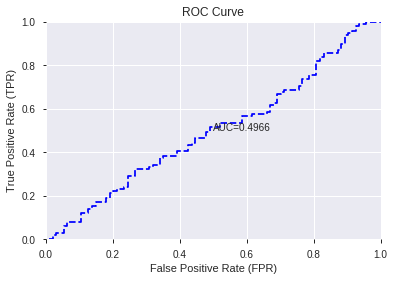

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


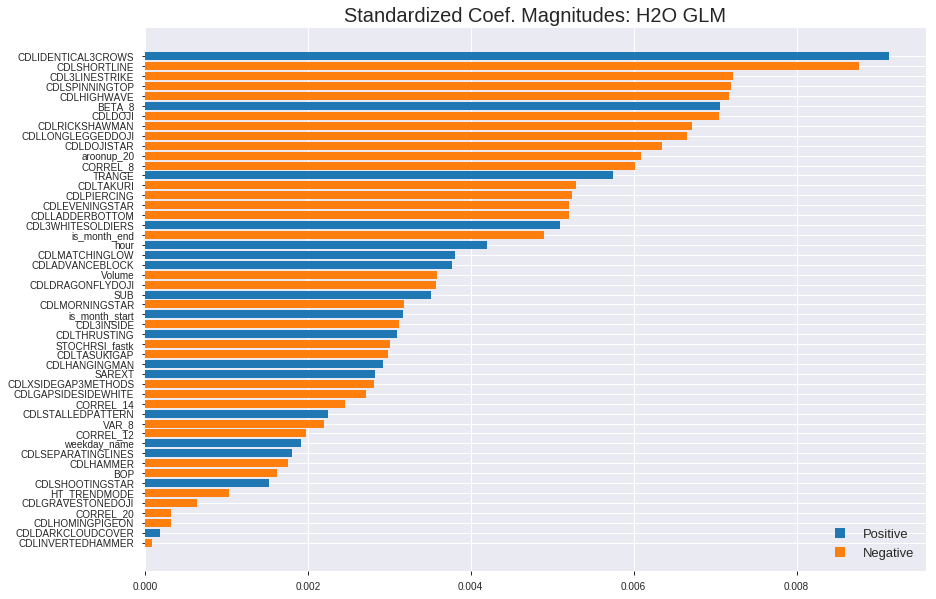

'log_likelihood'
--2019-08-25 12:52:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_125252_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_125252_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLIDENTICAL3CROWS',
 'CDLSHORTLINE',
 'CDL3LINESTRIKE',
 'CDLSPINNINGTOP',
 'CDLHIGHWAVE',
 'BETA_8',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJISTAR',
 'aroonup_20',
 'CORREL_8',
 'TRANGE',
 'CDLTAKURI',
 'CDLPIERCING',
 'CDLEVENINGSTAR',
 'CDLLADDERBOTTOM',
 'CDL3WHITESOLDIERS',
 'is_month_end',
 'hour',
 'CDLMATCHINGLOW',
 'CDLADVANCEBLOCK',
 'Volume',
 'CDLDRAGONFLYDOJI',
 'SUB',
 'CDLMORNINGSTAR',
 'is_month_start',
 'CDL3INSIDE',
 'CDLTHRUSTING',
 'STOCHRSI_fastk',
 'CDLTASUKIGAP',
 'CDLHANGINGMAN',
 'SAREXT',
 'CDLXSIDEGAP3METHODS',
 'CDLGAPSIDESIDEWHITE',
 'CORREL_14',
 'CDLSTALLEDPATTERN',
 'VAR_8',
 'CORREL_12',
 'weekday_name',
 'CDLSEPARATINGLINES',
 'CDLHAMMER',
 'BOP',
 'CDLSHOOTINGSTAR',
 'HT_TRENDMODE',
 'CDLGRAVESTONEDOJI',
 'CORREL_20',
 'CDLHOMINGPIGEON',
 'CDLDARKCLOUDCOVER',
 'CDLINVERTEDHAMMER']

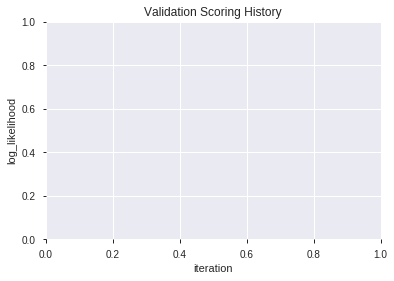

In [0]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_125303_model_7  0.522136  0.713072              0.500000  0.509157  0.259241
1  XGBoost_grid_1_AutoML_20190825_125303_model_5  0.516226  0.732773              0.500000  0.516228  0.266491
2  XGBoost_grid_1_AutoML_20190825_125303_model_6  0.507952  0.702080              0.478723  0.504284  0.254303
3               XGBoost_3_AutoML_20190825_125303  0.503654  0.700547              0.489362  0.503653  0.253667
4  XGBoost_grid_1_AutoML_20190825_125303_model_3  0.500107  0.706210              0.494681  0.506314  0.256354
5  XGBoost_grid_1_AutoML_20190825_125303_model_2  0.492156  0.702449              0.500000  0.504501  0.254521
6               XGBoost_1_AutoML_20190825_125303  0.491726  0.714495              0.494681  0.509957  0.260056
7  XGBoost_grid_1_AutoML_20190825_125303_model_1  0.490329  0.704608              0.494681  0.505555  0.255585
8               XGBoost_2_AutoML_20190825_125303  0.484634  0.712184              0.472598  0.509128  0.259211
9  XGBoost_grid_1_AutoML_20190825_125303_model_4  0.471739  0.710342              0.500000  0.508357  0.258427

variable  relative_importance  scaled_importance  percentage
0              SAREXT           541.196411           1.000000    0.095287
1                 BOP           535.449097           0.989380    0.094275
2              Volume           527.156677           0.974058    0.092815
3           CORREL_20           475.010315           0.877704    0.083634
4           CORREL_14           468.597473           0.865855    0.082505
5              BETA_8           466.705658           0.862359    0.082172
6               VAR_8           397.749023           0.734944    0.070031
7           CORREL_12           390.474060           0.721502    0.068750
8              TRANGE           375.509583           0.693851    0.066115
9            CORREL_8           343.059906           0.633892    0.060402
10         aroonup_20           272.591492           0.503683    0.047995
11     STOCHRSI_fastk           253.937088           0.469214    0.044710
12                SUB           235.031128           0.434281    0.041381
13               hour           172.158066           0.318106    0.030311
14       weekday_name            81.084274           0.149824    0.014276
15       CDLSHORTLINE            44.475197           0.082179    0.007831
16     CDLSPINNINGTOP            42.618362           0.078748    0.007504
17       HT_TRENDMODE            41.708897           0.077068    0.007344
18        CDLHIGHWAVE             7.693110           0.014215    0.001355
19            CDLDOJI             4.991632           0.009223    0.000879
20  CDLLONGLEGGEDDOJI             2.437842           0.004505    0.000429

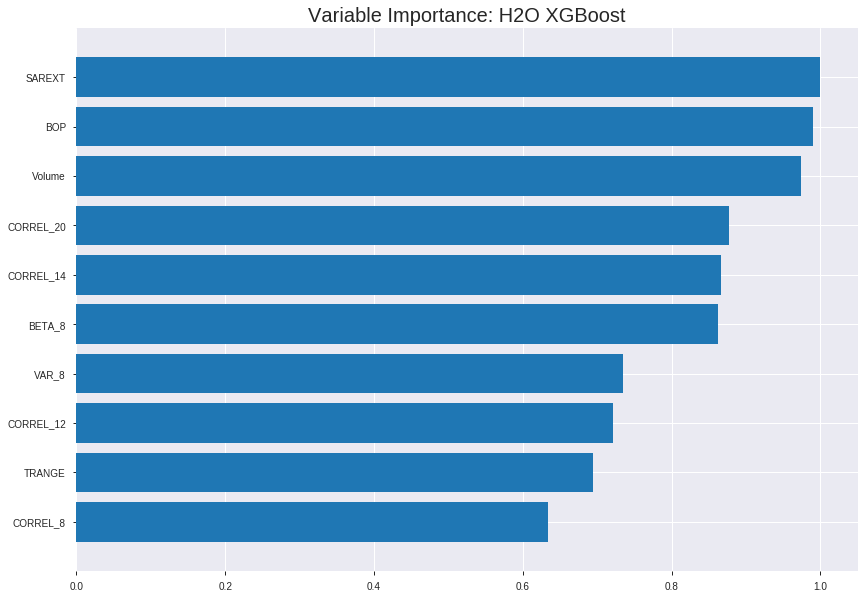

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_125303_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.16243183341907808
RMSE: 0.4030283283084181
LogLoss: 0.5108577498594498
Mean Per-Class Error: 0.11723914751976339
AUC: 0.9476027570660274
pr_auc: 0.9470181772861839
Gini: 0.8952055141320547
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4978675127029419: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      579  90   0.1345   (90.0/669.0)
1      69   610  0.1016   (69.0/679.0)
Total  648  700  0.118    (159.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497868     0.884699  201
max f2                       0.432437     0.913889  250
max f0point5                 0.544704     0.892917  163
max accuracy                 0.505361     0.882789  195
max precision                0.815398     1         0
max recall                   0.295017     1         352
max specificity              0.815398     1         0
max absolute_mcc             0.50172      0.765656  198
max min_per_class_accuracy   0.507159     0.878924  194
max mean_per_class_accuracy  0.505361     0.882761  195

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.21 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.760681           1.98527    1.98527            1                0.777007  1                           0.777007            0.0206186       0.0206186                  98.5272   98.5272
    2        0.0200297                   0.746276           1.98527    1.98527            1                0.753499  1                           0.765688            0.0191458       0.0397644                  98.5272   98.5272
    3        0.0304154                   0.730451           1.98527    1.98527            1                0.738671  1                           0.756463            0.0206186       0.0603829                  98.5272   98.5272
    4        0.0400593                   0.721032           1.98527    1.98527            1                0.725703  1                           0.749058            0.0191458       0.0795287                  98.5272   98.5272
    5        0.0504451                   0.714644           1.98527    1.98527            1                0.717522  1                           0.742565            0.0206186       0.100147                   98.5272   98.5272
    6        0.100148                    0.68419            1.95564    1.97057            0.985075         0.69901   0.992593                    0.720949            0.0972018       0.197349                   95.5642   97.0567
    7        0.150593                    0.65946            1.95608    1.96571            0.985294         0.672276  0.990148                    0.704645            0.0986745       0.296024                   95.6077   96.5713
    8        0.200297                    0.633958           1.92601    1.95586            0.970149         0.645747  0.985185                    0.690029            0.095729        0.391753                   92.6011   95.5861
    9        0.300445                    0.598513           1.83822    1.91665            0.925926         0.616127  0.965432                    0.665395            0.184094        0.575847                   83.8215   91.6646
    10       0.399852                    0.556929           1.65933    1.85268            0.835821         0.578085  0.93321                     0.643689            0.164948        0.740795                   65.9332   85.2675
    11       0.5                         0.510146           1.32351    1.74669            0.666667         0.533479  0.879822                    0.621615            0.132548        0.873343                   32.3515   74.6686
    12       0.600148                    0.46016            0.72058    1.57546            0.362963         0.483835  0.793572                    0.598623            0.0721649       0.945508                   -27.942   57.5457
    13       0.699555                    0.406487           0.370387   1.40422            0.186567         0.434541  0.707317                    0.575307            0.0368189       0.982327                   -62.9613  40.4217
    14       0.799703                    0.36491            0.147057   1.24678            0.0740741        0.384947  0.628015                    0.551468            0.0147275       0.997054                   -85.2943  24.6781
    15       0.899852                    0.311091           0.0147057  1.10966            0.00740741       0.338928  0.558945                    0.527813            0.00147275      0.998527                   -98.5294  10.9658
    16       1                           0.165841           0.0147057  1                  0.00740741       0.271476  0.503709                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.265921062000992
RMSE: 0.5156753455430966
LogLoss: 0.7274503264333063
Mean Per-Class Error: 0.4719828164854343
AUC: 0.483527990334273
pr_auc: 0.49121043767612665
Gini: -0.032944019331453966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22475853562355042: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    191  1        (191.0/191.0)
1      0    195  0        (0.0/195.0)
Total  0    386  0.4948   (191.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.224759     0.671256  385
max f2                       0.224759     0.836192  385
max f0point5                 0.224759     0.560667  385
max accuracy                 0.548918     0.528497  210
max precision                0.724735     0.75      11
max recall                   0.224759     1         385
max specificity              0.766847     0.994764  0
max absolute_mcc             0.633971     0.11138   71
max min_per_class_accuracy   0.560061     0.507853  193
max mean_per_class_accuracy  0.548918     0.528017  210

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 54.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.728638           0.989744  0.989744           0.5              0.748797  0.5                         0.748797            0.0102564       0.0102564                  -1.02564  -1.02564
    2        0.0207254                   0.726056           1.48462   1.23718            0.75             0.72736   0.625                       0.738079            0.0153846       0.025641                   48.4615   23.7179
    3        0.0310881                   0.723559           1.97949   1.48462            1                0.725373  0.75                        0.733843            0.0205128       0.0461538                  97.9487   48.4615
    4        0.0414508                   0.707101           0         1.11346            0                0.71359   0.5625                      0.72878             0               0.0461538                  -100      11.3462
    5        0.0518135                   0.696389           0.494872  0.989744           0.25             0.701423  0.5                         0.723309            0.00512821      0.0512821                  -50.5128  -1.02564
    6        0.101036                    0.670965           0.833468  0.913609           0.421053         0.679554  0.461538                    0.701992            0.0410256       0.0923077                  -16.6532  -8.63905
    7        0.150259                    0.647229           0.625101  0.819098           0.315789         0.656063  0.413793                    0.686946            0.0307692       0.123077                   -37.4899  -18.0902
    8        0.202073                    0.632171           0.791795  0.812097           0.4              0.637983  0.410256                    0.674392            0.0410256       0.164103                   -20.8205  -18.7903
    9        0.300518                    0.606995           1.09393   0.904421           0.552632         0.62059   0.456897                    0.656767            0.107692        0.271795                   9.39271   -9.55791
    10       0.401554                    0.58566            1.11663   0.957816           0.564103         0.59576   0.483871                    0.641417            0.112821        0.384615                   11.6634   -4.21836
    11       0.5                         0.560203           1.2502    1.01538            0.631579         0.571211  0.512953                    0.627594            0.123077        0.507692                   25.0202   1.53846
    12       0.601036                    0.530505           0.913609  0.998276           0.461538         0.545782  0.50431                     0.613841            0.0923077       0.6                        -8.63905  -0.172414
    13       0.699482                    0.500641           1.04184   1.00441            0.526316         0.515181  0.507407                    0.599955            0.102564        0.702564                   4.18354   0.440646
    14       0.800518                    0.459811           0.964366  0.999353           0.487179         0.482362  0.504854                    0.585114            0.0974359       0.8                        -3.56345  -0.0647249
    15       0.898964                    0.399546           0.833468  0.981187           0.421053         0.430452  0.495677                    0.568177            0.0820513       0.882051                   -16.6532  -1.88133
    16       1                           0.224759           1.16739   1                  0.589744         0.340515  0.505181                    0.5


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:53:11  5.365 sec   0                  0.5              0.693147            0.5             0                  1                0.496291                         0.5                0.693147              0.5               0                    1                  0.494819
    2019-08-25 12:53:11  5.448 sec   5                  0.4862           0.665857            0.782663        0.778069           1.98527          0.281899                         0.502098           0.697363              0.465727          0.484707             0.989744           0.492228
    2019-08-25 12:53:11  5.497 sec   10                 0.473714         0.641623            0.834981        0.82302            1.98527          0.253709                         0.50378            0.700786              0.475983          0.49873              1.48462            0.494819
    2019-08-25 12:53:11  5.548 sec   15                 0.463247         0.62158             0.859323        0.851124           1.98527          0.227003                         0.502091           0.697349              0.509491          0.539245             1.97949            0.494819
    2019-08-25 12:53:12  5.604 sec   20                 0.45311          0.602417            0.883137        0.876242           1.98527          0.209199                         0.502897           0.699157              0.523909          0.521669             1.48462            0.494819
    2019-08-25 12:53:12  5.659 sec   25                 0.443744         0.584832            0.895789        0.893952           1.98527          0.175816                         0.505333           0.704325              0.518351          0.516194             1.48462            0.494819
    2019-08-25 12:53:12  5.711 sec   30                 0.434841         0.56836             0.910366        0.911397           1.98527          0.158012                         0.508082           0.710141              0.504121          0.508647             0.494872           0.492228
    2019-08-25 12:53:12  5.768 sec   35                 0.426455         0.552994            0.92224         0.923869           1.98527          0.145401                         0.510227           0.714908              0.496469          0.503636             0.494872           0.494819
    2019-08-25 12:53:12  5.824 sec   40                 0.418582         0.538766            0.935992        0.937232           1.98527          0.129822                         0.513265           0.721559              0.480843          0.48884              0.494872           0.494819
    2019-08-25 12:53:12  5.891 sec   45                 0.410596         0.524346            0.94109         0.940398           1.98527          0.12908                          0.514154           0.723919              0.484401          0.489062             0.494872           0.494819
    2019-08-25 12:53:12  5.953 sec   50                 0.403028         0.510858            0.947603        0.947018           1.98527          0.117953                         0.515675           0.72745               0.483528          0.49121              0.989744           0.494819

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ----------------------
SAREXT             541.1964111328125      1.0                  0.0952871766302227
BOP                535.4490966796875      0.9893803537220527   0.09427526051958544
Volume             527.1566772460938      0.9740579693473368   0.09281523377327572
CORREL_20          475.01031494140625     0.8777041110585565   0.08363394665950927
CORREL_14          468.59747314453125     0.8658547313048144   0.08250485271795586
---                ---                    ---                  ---
CDLSPINNINGTOP     42.61836242675781      0.07874842025938535  0.007503714630607059
HT_TRENDMODE       41.70889663696289      0.0770679475676111   0.0073435871324037
CDLHIGHWAVE        7.693110466003418      0.01421500643343233  0.0013545078288222183
CDLDOJI            4.991631507873535      0.00922332706794052  0.0008788647954411623
CDLLONGLEGGEDDOJI  2.4378418922424316     0.00450454186704533  0.00042922507652338153


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5492227979274611)

('F1', 0.678082191780822)

('auc', 0.5221362561788094)

('logloss', 0.7130722134567529)

('mean_per_class_error', 0.44987105093488067)

('rmse', 0.5091573772733319)

('mse', 0.25924123483185796)

xgboost prediction progress: |████████████████████████████████████████████| 100%


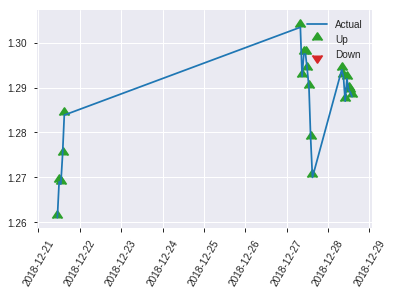


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25924123483185796
RMSE: 0.5091573772733319
LogLoss: 0.7130722134567529
Mean Per-Class Error: 0.44987105093488067
AUC: 0.5221362561788094
pr_auc: 0.5342238440920778
Gini: 0.044272512357618865
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2812137007713318: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      0    94   1        (94.0/94.0)
1      0    99   0        (0.0/99.0)
Total  0    193  0.487    (94.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281214     0.678082  192
max f2                       0.281214     0.840407  192
max f0point5                 0.281214     0.568312  192
max accuracy                 0.552879     0.549223  89
max precision                0.684354     0.666667  17
max recall                   0.281214     1         192
max specificity              0.749787     0.989362  0
max absolute_mcc             0.716644     0.102108  4
max min_per_class_accuracy   0.546396     0.535354  94
max mean_per_class_accuracy  0.552879     0.550129  89

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 54.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.735655           0.974747  0.974747           0.5              0.746248  0.5                         0.746248            0.010101        0.010101                   -2.52525  -2.52525
    2        0.0207254                   0.718346           0         0.487374           0                0.731164  0.25                        0.738706            0               0.010101                   -100      -51.2626
    3        0.0310881                   0.708548           0.974747  0.649832           0.5              0.713227  0.333333                    0.730213            0.010101        0.020202                   -2.52525  -35.0168
    4        0.0414508                   0.703119           1.94949   0.974747           1                0.706987  0.5                         0.724406            0.020202        0.040404                   94.9495   -2.52525
    5        0.0518135                   0.696283           1.94949   1.1697             1                0.699696  0.6                         0.719464            0.020202        0.0606061                  94.9495   16.9697
    6        0.103627                    0.677942           1.36465   1.26717            0.7              0.6869    0.65                        0.703182            0.0707071       0.131313                   36.4646   26.7172
    7        0.150259                    0.645581           0.866442  1.14281            0.444444         0.66271   0.586207                    0.690622            0.040404        0.171717                   -13.3558  14.2807
    8        0.202073                    0.621833           0.779798  1.04973            0.4              0.638428  0.538462                    0.677239            0.040404        0.212121                   -22.0202  4.9728
    9        0.300518                    0.599817           1.12865   1.07558            0.578947         0.611253  0.551724                    0.655623            0.111111        0.323232                   12.8655   7.55834
    10       0.398964                    0.576259           1.12865   1.08868            0.578947         0.587704  0.558442                    0.638864            0.111111        0.434343                   12.8655   8.8679
    11       0.502591                    0.545339           0.974747  1.06519            0.5              0.558284  0.546392                    0.622249            0.10101         0.535354                   -2.52525  6.5188
    12       0.601036                    0.516705           0.923445  1.04197            0.473684         0.533159  0.534483                    0.607657            0.0909091       0.626263                   -7.6555   4.19714
    13       0.699482                    0.493067           0.82084   1.01085            0.421053         0.505283  0.518519                    0.593249            0.0808081       0.707071                   -17.916   1.08492
    14       0.797927                    0.468063           0.718235  0.974747           0.368421         0.479232  0.5                         0.579182            0.0707071       0.777778                   -28.1765  -2.52525
    15       0.896373                    0.4083             1.12865   0.991651           0.578947         0.439047  0.508671                    0.563791            0.111111        0.888889                   12.8655   -0.834939
    16       1                           0.281214           1.07222   1                  0.55             0.352665  0.512953                    0.541913     

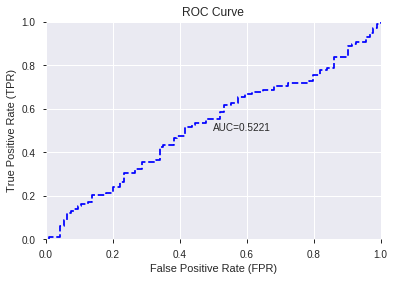

This function is available for GLM models only


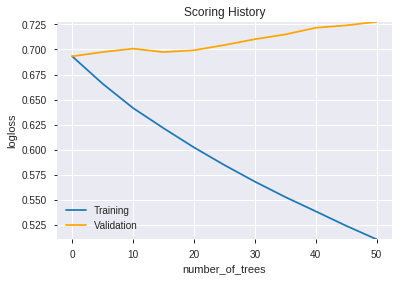

--2019-08-25 12:53:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.128.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.128.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_125303_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_125303_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['SAREXT',
 'BOP',
 'Volume',
 'CORREL_20',
 'CORREL_14',
 'BETA_8',
 'VAR_8',
 'CORREL_12',
 'TRANGE',
 'CORREL_8',
 'aroonup_20',
 'STOCHRSI_fastk',
 'SUB',
 'hour',
 'weekday_name',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'HT_TRENDMODE',
 'CDLHIGHWAVE',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI']

In [0]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 903] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_125322_model_1  0.537395  1.626577              0.483774  0.617701  0.381554
1  DeepLearning_grid_1_AutoML_20190825_125322_model_4  0.520847  1.187851              0.440146  0.608328  0.370063
2  DeepLearning_grid_1_AutoML_20190825_125322_model_3  0.518698  0.742063              0.473404  0.520890  0.271326
3               DeepLearning_1_AutoML_20190825_125322  0.515689  0.888415              0.484043  0.574609  0.330176
4  DeepLearning_grid_1_AutoML_20190825_125322_model_6  0.511176  0.693316              0.500000  0.500084  0.250084
5  DeepLearning_grid_1_AutoML_20190825_125322_model_9  0.500000  0.692830              0.500000  0.499841  0.249841
6  DeepLearning_grid_1_AutoML_20190825_125322_model_5  0.500000  0.693532              0.500000  0.500193  0.250193
7  DeepLearning_grid_1_AutoML_20190825_125322_model_7  0.500000  0.695697              0.500000  0.501265  0.251266
8  DeepLearning_grid_1_AutoML_20190825_125322_model_8  0.500000  0.692814              0.500000  0.499833  0.249833
9  DeepLearning_grid_1_AutoML_20190825_125322_model_2  0.482270  0.792159              0.473136  0.540689  0.292345

variable  relative_importance  scaled_importance  percentage
0                       CMO_14             1.000000           1.000000    0.001045
1      BBANDS_lowerband_12_4_2             0.997645           0.997645    0.001042
2                    MAVP_20_5             0.995585           0.995585    0.001040
3     BBANDS_middleband_30_0_2             0.994900           0.994900    0.001040
4                       EMA_12             0.993714           0.993714    0.001038
...                        ...                  ...                ...         ...
1027  BBANDS_middleband_14_1_5             0.862197           0.862197    0.000901
1028   BBANDS_lowerband_30_0_5             0.861794           0.861794    0.000901
1029                   MA_14_0             0.860458           0.860458    0.000899
1030   BBANDS_lowerband_24_1_4             0.859437           0.859437    0.000898
1031                 MAVP_12_7             0.858489           0.858489    0.000897

[1032 rows x 4 columns]

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_125322_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.385345198479211
RMSE: 0.6207617888362741
LogLoss: 2.177154820903366
Mean Per-Class Error: 0.4328091737827765
AUC: 0.5830928275336763
pr_auc: 0.46716907558607607
Gini: 0.1661856550673526
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0011687442993404333: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      44   625   0.9342   (625.0/669.0)
1      16   663   0.0236   (16.0/679.0)
Total  60   1288  0.4755   (641.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00116874   0.674123  397
max f2                       0.000120019  0.835384  399
max f0point5                 0.309617     0.583683  258
max accuracy                 0.621134     0.568249  181
max precision                0.9998       0.617925  1
max recall                   0.000120019  1         399
max specificity              0.999966     0.896861  0
max absolute_mcc             0.309617     0.144092  258
max min_per_class_accuracy   0.938365     0.55157   68
max mean_per_class_accuracy  0.621134     0.567191  181

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 66.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   1                  1.70166   1.70166            0.857143         1           0.857143                    1                   0.017673        0.017673                   70.1662   70.1662
    2        0.0200297                   1                  1.22171   1.47057            0.615385         1           0.740741                    1                   0.011782        0.0294551                  22.1706   47.0572
    3        0.0304154                   0.999999           1.41805   1.45264            0.714286         0.999999    0.731707                    1                   0.0147275       0.0441826                  41.8052   45.2638
    4        0.0400593                   0.999996           1.22171   1.39704            0.615385         0.999998    0.703704                    0.999999            0.011782        0.0559647                  22.1706   39.7044
    5        0.0504451                   0.999994           1.13444   1.34298            0.571429         0.999995    0.676471                    0.999998            0.011782        0.0677467                  13.4441   34.2978
    6        0.100148                    0.999948           1.18524   1.26469            0.597015         0.999973    0.637037                    0.999986            0.0589102       0.126657                   18.5237   26.4692
    7        0.150593                    0.999779           1.197     1.24202            0.602941         0.999876    0.625616                    0.999949            0.0603829       0.18704                    19.7003   24.2018
    8        0.200297                    0.999173           1.00745   1.18381            0.507463         0.999563    0.596296                    0.999853            0.0500736       0.237113                   0.74517   18.3811
    9        0.300445                    0.996173           1.05881   1.14214            0.533333         0.998032    0.575309                    0.999246            0.106038        0.343152                   5.8812    14.2144
    10       0.399852                    0.985002           1.09634   1.13076            0.552239         0.992214    0.569573                    0.997498            0.108984        0.452135                   9.63445   13.0758
    11       0.5                         0.938295           0.985283  1.10162            0.496296         0.967616    0.554896                    0.991513            0.0986745       0.55081                    -1.47166  10.162
    12       0.600148                    0.791888           1.07352   1.09693            0.540741         0.874936    0.552534                    0.972059            0.107511        0.658321                   7.35177   9.69305
    13       0.699555                    0.359026           1.06671   1.09264            0.537313         0.582888    0.550371                    0.916758            0.106038        0.764359                   6.67136   9.26367
    14       0.799703                    0.0765866          0.808815  1.05709            0.407407         0.196951    0.532468                    0.826615            0.0810015       0.845361                   -19.1185  5.70931
    15       0.899852                    0.00876502         0.808815  1.02946            0.407407         0.0336293   0.518549                    0.738361            0.0810015       0.926362                   -19.1185  2.94612
    16       1                           1.08982e-07        0.735286  1                  0.37037          0.00245421  0.503709  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.4465889559405096
RMSE: 0.668273114782055
LogLoss: 2.3877359374570073
Mean Per-Class Error: 0.49759699288495096
AUC: 0.46357900389314005
pr_auc: 0.47282199627357924
Gini: -0.0728419922137199
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.9382180709175273e-08: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    191  1        (191.0/191.0)
1      0    195  0        (0.0/195.0)
Total  0    386  0.4948   (191.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.93822e-08  0.671256  385
max f2                       1.93822e-08  0.836192  385
max f0point5                 1.93822e-08  0.560667  385
max accuracy                 1.93822e-08  0.505181  385
max precision                0.999984     0.571429  6
max recall                   1.93822e-08  1         385
max specificity              1            0.994764  0
max absolute_mcc             1.50249e-06  0.113376  380
max min_per_class_accuracy   0.569897     0.486911  192
max mean_per_class_accuracy  0.999984     0.502403  6

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.99999            0.494872  0.494872           0.25             0.999997     0.25                        0.999997            0.00512821      0.00512821                 -50.5128  -50.5128
    2        0.0207254                   0.999969           1.48462   0.989744           0.75             0.999982     0.5                         0.999989            0.0153846       0.0205128                  48.4615   -1.02564
    3        0.0310881                   0.999899           0.989744  0.989744           0.5              0.999945     0.5                         0.999975            0.0102564       0.0307692                  -1.02564  -1.02564
    4        0.0414508                   0.999814           0         0.742308           0                0.999844     0.375                       0.999942            0               0.0307692                  -100      -25.7692
    5        0.0518135                   0.999678           0.494872  0.692821           0.25             0.999743     0.35                        0.999902            0.00512821      0.0358974                  -50.5128  -30.7179
    6        0.101036                    0.998423           0.937652  0.812097           0.473684         0.999119     0.410256                    0.999521            0.0461538       0.0820513                  -6.23482  -18.7903
    7        0.150259                    0.990043           1.14602   0.921485           0.578947         0.995059     0.465517                    0.998059            0.0564103       0.138462                   14.6019   -7.85146
    8        0.202073                    0.981522           0.692821  0.862853           0.35             0.985859     0.435897                    0.994931            0.0358974       0.174359                   -30.7179  -13.7147
    9        0.300518                    0.92133            1.19811   0.972679           0.605263         0.957459     0.491379                    0.982656            0.117949        0.292308                   19.8111   -2.7321
    10       0.401554                    0.79866            0.862853  0.945045           0.435897         0.865586     0.477419                    0.9532              0.0871795       0.379487                   -13.7147  -5.49545
    11       0.5                         0.563512           1.09393   0.974359           0.552632         0.68003      0.492228                    0.899415            0.107692        0.487179                   9.39271   -2.5641
    12       0.601036                    0.21173            0.913609  0.964147           0.461538         0.366454     0.487069                    0.809822            0.0923077       0.579487                   -8.63905  -3.58532
    13       0.699482                    0.0666882          1.04184   0.975081           0.526316         0.124378     0.492593                    0.713352            0.102564        0.682051                   4.18354   -2.49193
    14       0.800518                    0.0165458          1.01512   0.980134           0.512821         0.0400734    0.495146                    0.628375            0.102564        0.784615                   1.51216   -1.98656
    15       0.898964                    0.00120227         0.989744  0.981187           0.5              0.00673717   0.495677                    0.5603              0.0974359       0.882051                   -1.02564  -1.88133
    16       1                           1.93822e-08        1.16739   1                  0.589744


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:53:25  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:53:29  5.556 sec         196 obs/sec       0.60905   1             821        0.668073         4.49136             -0.785383      0.522635        0.342816           0.992636         0.496291                         0.70336            7.46805               -0.979076        0.48381           0.334397             0.494872           0.494819
    2019-08-25 12:53:42  18.716 sec        206 obs/sec       2.4911    4             3358       0.620762         2.17715             -0.541466      0.583093        0.467169           1.70166          0.475519                         0.668273           2.38774               -0.786548        0.463579          0.472822             0.494872           0.494819
    2019-08-25 12:53:55  31.527 sec        211 obs/sec       4.39985   7             5931       0.638609         4.43164             -0.631376      0.619219        0.299628           1.55986          0.450297                         0.703422           14.8204               -0.979425        0.47162           0.0508973            0.963698           0.492228
    2019-08-25 12:54:07  43.870 sec        215 obs/sec       6.27448   10            8458       0.653875         4.63634             -0.710306      0.546965        0.361643           1.55986          0.496291                         0.705378           5.554                 -0.990446        0.451228          0.463595             0.494872           0.492228
    2019-08-25 12:54:20  55.998 sec        217 obs/sec       8.13427   13            10965      0.625661         3.17079             -0.565891      0.597738        0.447349           1.84347          0.496291                         0.704338           11.9763               -0.984582        0.433763          0.159379             0.989744           0.492228
    2019-08-25 12:54:32  1 min  8.289 sec  219 obs/sec       10.0015   16            13482      0.630427         3.87383             -0.589839      0.60048         0.613319           1.70166          0.496291                         0.710939           9.78153               -1.02195         0.487985          0.485974             0.989744           0.494819
    2019-08-25 12:54:44  1 min 20.622 sec  220 obs/sec       11.8739   19            16006      0.603839         2.99762             -0.458567      0.646896        0.326939           1.84347          0.396884                         0.710786           10.0128               -1.02108         0.418432          0.241891             0.989744           0.492228
    2019-08-25 12:54:45  1 min 21.748 sec  220 obs/sec       11.8739   19            16006      0.620762         2.17715             -0.541466      0.583093        0.467169           1.70166          0.475519                         0.668273           2.38774               -0.786548        0.463579          0.472822             0.494872           0.494819

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CMO_14                    1.0                    1.0                  0.0010449295333754508
BBANDS_lowerband_12_4_2   0.9976451396942139     0.9976451396942139   0.0010424688702949615
MAVP_20_5                 0.9955849647521973     0.9955849647521973   0.0010403161326541282
BBANDS_middleband_30_0_2  0.9948999881744385     0.9948999881744385   0.0010396003803983577
EMA_12                    0.9937136173248291     0.9937136173248291   0.001038360706460065
---                       ---                    ---                  ---
BBANDS_middleband_14_1_5  0.8621973991394043     0.8621973991394043   0.0009009355259602651
BBANDS_lowerband_30_0_5   0.8617939949035645     0.8617939949035645   0.0009005139969603473
MA_14_0                   0.860458493232727      0.860458493232727    0.000899118491822617
BBANDS_lowerband_24_1_4   0.8594368696212769     0.8594368696212769   0.000898050967139019
MAVP_12_7                 0.8584885001182556     0.8584885001182556   0.0008970599878367595


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5492227979274611)

('F1', 0.6829268292682926)

('auc', 0.5373952288845906)

('logloss', 1.626576598686307)

('mean_per_class_error', 0.45148291424887166)

('rmse', 0.6177008174219836)

('mse', 0.38155429984378675)

deeplearning prediction progress: |███████████████████████████████████████| 100%


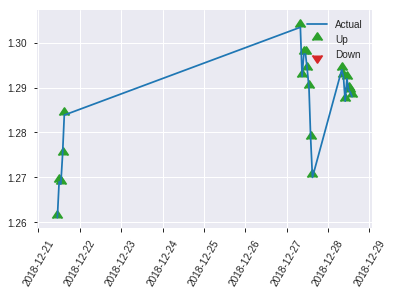


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.38155429984378675
RMSE: 0.6177008174219836
LogLoss: 1.626576598686307
Mean Per-Class Error: 0.45148291424887166
AUC: 0.5373952288845906
pr_auc: 0.5354839232011667
Gini: 0.07479045776918114
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0005608984195855234: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      4    90   0.9574   (90.0/94.0)
1      1    98   0.0101   (1.0/99.0)
Total  5    188  0.4715   (91.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000560898  0.682927  187
max f2                       0.000115907  0.841837  191
max f0point5                 0.0071737    0.581977  174
max accuracy                 0.50085      0.549223  101
max precision                0.999252     0.714286  6
max recall                   0.000115907  1         191
max specificity              0.99989      0.989362  0
max absolute_mcc             0.0071737    0.115252  174
max min_per_class_accuracy   0.618236     0.535354  95
max mean_per_class_accuracy  0.50085      0.548517  101

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 52.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.99985            0.974747  0.974747           0.5              0.999887    0.5                         0.999887            0.010101        0.010101                   -2.52525  -2.52525
    2        0.0207254                   0.999448           0.974747  0.974747           0.5              0.999769    0.5                         0.999828            0.010101        0.020202                   -2.52525  -2.52525
    3        0.0310881                   0.999265           1.94949   1.29966            1                0.999354    0.666667                    0.99967             0.020202        0.040404                   94.9495   29.9663
    4        0.0414508                   0.99917            0.974747  1.21843            0.5              0.99924     0.625                       0.999562            0.010101        0.0505051                  -2.52525  21.8434
    5        0.0518135                   0.998143           0.974747  1.1697             0.5              0.99869     0.6                         0.999388            0.010101        0.0606061                  -2.52525  16.9697
    6        0.103627                    0.995986           0.779798  0.974747           0.4              0.997346    0.5                         0.998367            0.040404        0.10101                    -22.0202  -2.52525
    7        0.150259                    0.993126           1.08305   1.00836            0.555556         0.994661    0.517241                    0.997217            0.0505051       0.151515                   8.30527   0.835946
    8        0.202073                    0.983665           0.974747  0.999741           0.5              0.987411    0.512821                    0.994703            0.0505051       0.20202                    -2.52525  -0.0259
    9        0.300518                    0.933357           1.33386   1.1092             0.684211         0.960665    0.568966                    0.983552            0.131313        0.333333                   33.3865   10.9195
    10       0.398964                    0.78488            0.82084   1.03804            0.421053         0.859472    0.532468                    0.952935            0.0808081       0.414141                   -17.916   3.80428
    11       0.502591                    0.598059           1.1697    1.06519            0.6              0.688321    0.546392                    0.898376            0.121212        0.535354                   16.9697   6.5188
    12       0.601036                    0.31357            1.02605   1.05878            0.526316         0.439896    0.543103                    0.82328             0.10101         0.636364                   2.605     5.87774
    13       0.699482                    0.173142           0.718235  1.01085            0.368421         0.235992    0.518519                    0.740624            0.0707071       0.707071                   -28.1765  1.08492
    14       0.797927                    0.0334842          1.12865   1.02538            0.578947         0.0904143   0.525974                    0.660404            0.111111        0.818182                   12.8655   2.53837
    15       0.896373                    0.00784924         1.12865   1.03673            0.578947         0.0235881   0.531792                    0.590464            0.111111        0.929293                   12.8655   3.67256
    16       1                           6.314e-08          0.682323  1                  0.35             0.00241145  0.5129

This function is available for GLM models only


--2019-08-25 13:20:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_125322_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_125322_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CMO_14',
 'BBANDS_lowerband_12_4_2',
 'MAVP_20_5',
 'BBANDS_middleband_30_0_2',
 'EMA_12',
 'BBANDS_middleband_14_2_2',
 'BBANDS_lowerband_24_6_3',
 'WILLR_24',
 'BBANDS_middleband_14_3_2',
 'MA_8_2',
 'BBANDS_lowerband_12_7_4',
 'BBANDS_upperband_24_6_5',
 'BBANDS_middleband_14_4_2',
 'BBANDS_middleband_14_1_2',
 'WILLR_12',
 'MINUS_DM_24',
 'MAVP_30_6',
 'CORREL_8',
 'CDLHARAMI',
 'MFI_14',
 'BBANDS_middleband_12_4_2',
 'ROCR100_24',
 'MA_8_0',
 'BBANDS_middleband_24_2_2',
 'aroondown_24',
 'BBANDS_lowerband_14_7_3',
 'SAR_0.24',
 'AROONOSC_30',
 'TSF_20',
 'BBANDS_upperband_20_2_5',
 'mama',
 'MINMAX_max_8',
 'BBANDS_middleband_8_5_5',
 'MACDFIX_signal_12',
 'MIDPOINT_12',
 'BBANDS_middleband_14_7_2',
 'BBANDS_upperband_14_6_2',
 'MEDPRICE',
 'CDLENGULFING',
 'NATR_20',
 'MA_14_2',
 'BBANDS_upperband_12_5_2',
 'CDLSPINNINGTOP',
 'ROCR_24',
 'LINEARREG_ANGLE_30',
 'MA_24_1',
 'MA_14_1',
 'MACD',
 'BBANDS_middleband_20_5_5',
 'BBANDS_lowerband_8_7_5',
 'DX_14',
 'TEMA_14',
 'aroondo

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_132106_model_1  0.525038  0.692655              0.478723  0.499759  0.249759

variable  relative_importance  scaled_importance    percentage
0                 aroondown_30         7.750798e-03           1.000000  1.170722e-02
1                 aroondown_24         7.542386e-03           0.973111  1.139243e-02
2           CDLIDENTICAL3CROWS         6.761977e-03           0.872423  1.021365e-02
3                 aroondown_14         6.540142e-03           0.843802  9.878582e-03
4                 CDLSHORTLINE         6.284007e-03           0.810756  9.491702e-03
...                        ...                  ...                ...           ...
1027   BBANDS_lowerband_20_1_2         5.966284e-07           0.000077  9.011796e-07
1028                     TSF_8         2.495429e-07           0.000032  3.769230e-07
1029   BBANDS_lowerband_20_2_2         2.096817e-07           0.000027  3.167145e-07
1030   BBANDS_lowerband_24_3_4         1.421810e-07           0.000018  2.147578e-07
1031  BBANDS_middleband_12_5_5         3.683928e-08           0.000005  5.564402e-08

[1032 rows x 4 columns]

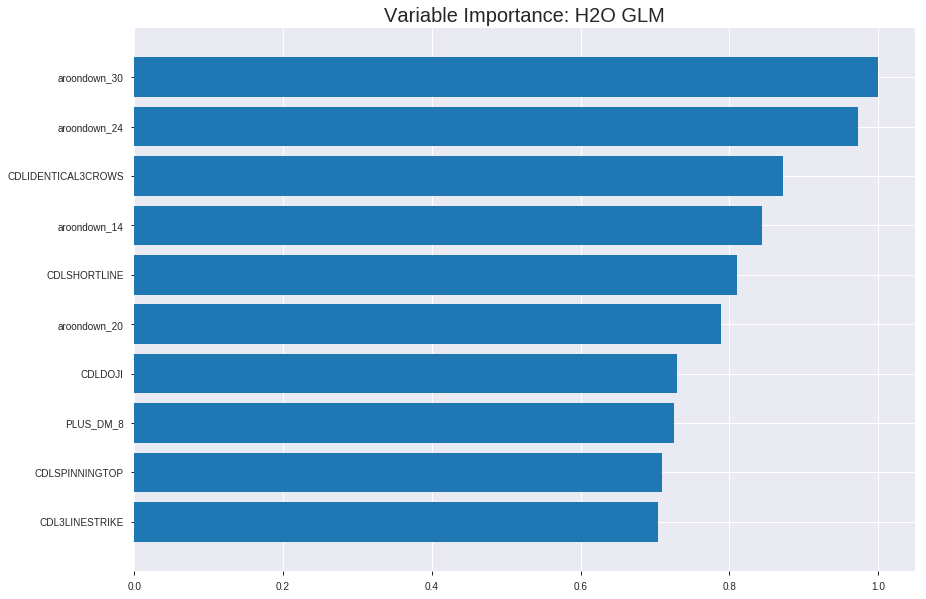

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_132106_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24654920646183154
RMSE: 0.4965372155859332
LogLoss: 0.6862239599125806
Null degrees of freedom: 1347
Residual degrees of freedom: 315
Null deviance: 1868.6506141329141
Residual deviance: 1850.059795924317
AIC: 3916.059795924317
AUC: 0.588271682395856
pr_auc: 0.580973185607464
Gini: 0.17654336479171207
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4321405619027035: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    661   0.988    (661.0/669.0)
1      0    679   0        (0.0/679.0)
Total  8    1340  0.4904   (661.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.432141     0.67261   391
max f2                       0.432141     0.837032  391
max f0point5                 0.503395     0.576644  204
max accuracy                 0.50381      0.573442  202
max precision                0.600765     1         0
max recall                   0.432141     1         391
max specificity              0.600765     1         0
max absolute_mcc             0.512784     0.150521  164
max min_per_class_accuracy   0.504234     0.571001  201
max mean_per_class_accuracy  0.50381      0.573413  202

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103858                   0.5649             1.41805   1.41805            0.714286         0.575959  0.714286                    0.575959            0.0147275       0.0147275                  41.8052    41.8052
    2        0.0200297                   0.559896           1.22171   1.32351            0.615385         0.562598  0.666667                    0.569526            0.011782        0.0265096                  22.1706    32.3515
    3        0.0304154                   0.553333           1.27625   1.30737            0.642857         0.556355  0.658537                    0.565029            0.0132548       0.0397644                  27.6247    30.7375
    4        0.0400593                   0.549442           1.52713   1.36028            0.769231         0.551533  0.685185                    0.56178             0.0147275       0.0544919                  52.7133    36.0279
    5        0.0504451                   0.547057           0.992636  1.28459            0.5              0.54846   0.647059                    0.559037            0.0103093       0.0648012                  -0.736377  28.4588
    6        0.100148                    0.536806           1.18524   1.23528            0.597015         0.540849  0.622222                    0.55001             0.0589102       0.123711                   18.5237    23.5281
    7        0.150593                    0.529108           1.197     1.22246            0.602941         0.532744  0.615764                    0.544226            0.0603829       0.184094                   19.7003    22.2458
    8        0.200297                    0.524356           1.2445    1.22793            0.626866         0.526841  0.618519                    0.539912            0.0618557       0.24595                    24.4499    22.7928
    9        0.300445                    0.5172             1.11763   1.19116            0.562963         0.520661  0.6                         0.533495            0.111929        0.357879                   11.7635    19.1163
    10       0.399852                    0.510368           1.02227   1.14917            0.514925         0.514157  0.57885                     0.528687            0.10162         0.459499                   2.22672    14.9174
    11       0.5                         0.504159           1.11763   1.14286            0.562963         0.507322  0.575668                    0.524408            0.111929        0.571429                   11.7635    14.2857
    12       0.600148                    0.498123           0.794109  1.08466            0.4              0.501151  0.546354                    0.520527            0.0795287       0.650957                   -20.5891   8.46606
    13       0.699555                    0.490766           0.963005  1.06737            0.485075         0.494376  0.537646                    0.516811            0.095729        0.746686                   -3.69947   6.73734
    14       0.799703                    0.482034           0.941166  1.05157            0.474074         0.486621  0.529685                    0.51303             0.0942563       0.840943                   -5.88338   5.15683
    15       0.899852                    0.470586           0.82352   1.02619            0.414815         0.476689  0.5169                      0.508986            0.0824742       0.923417                   -17.648    2.61878
    16       1                           0.407641           0.764698  1                  0.385185         0.456298  0.503709                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25674600182558605
RMSE: 0.506701097122935
LogLoss: 0.7068059231443103
Null degrees of freedom: 385
Residual degrees of freedom: -647
Null deviance: 535.0715182997042
Residual deviance: 545.6541726674076
AIC: 2611.6541726674077
AUC: 0.45743052758759567
pr_auc: 0.4769594354994049
Gini: -0.08513894482480866
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4233826876994885: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    190  0.9948   (190.0/191.0)
1      0    195  0        (0.0/195.0)
Total  1    385  0.4922   (190.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.423383     0.672414  384
max f2                       0.423383     0.83691   384
max f0point5                 0.423383     0.56196   384
max accuracy                 0.425809     0.507772  382
max precision                0.649048     1         0
max recall                   0.423383     1         384
max specificity              0.649048     1         0
max absolute_mcc             0.556336     0.103169  179
max min_per_class_accuracy   0.553082     0.465969  192
max mean_per_class_accuracy  0.595253     0.506779  36

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 54.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.622715           0.989744  0.989744           0.5              0.631367  0.5                         0.631367            0.0102564       0.0102564                  -1.02564  -1.02564
    2        0.0207254                   0.616092           0.494872  0.742308           0.25             0.619178  0.375                       0.625273            0.00512821      0.0153846                  -50.5128  -25.7692
    3        0.0310881                   0.610266           1.48462   0.989744           0.75             0.612857  0.5                         0.621134            0.0153846       0.0307692                  48.4615   -1.02564
    4        0.0414508                   0.605644           0         0.742308           0                0.60737   0.375                       0.617693            0               0.0307692                  -100      -25.7692
    5        0.0518135                   0.601419           0.494872  0.692821           0.25             0.602642  0.35                        0.614683            0.00512821      0.0358974                  -50.5128  -30.7179
    6        0.101036                    0.593819           1.45857   1.06588            0.736842         0.597354  0.538462                    0.606241            0.0717949       0.107692                   45.857    6.58777
    7        0.150259                    0.588042           0.833468  0.989744           0.421053         0.590667  0.5                         0.601139            0.0410256       0.148718                   -16.6532  -1.02564
    8        0.202073                    0.581067           0.890769  0.964366           0.45             0.584382  0.487179                    0.596842            0.0461538       0.194872                   -10.9231  -3.56345
    9        0.300518                    0.569546           0.88556   0.93855            0.447368         0.575065  0.474138                    0.589708            0.0871795       0.282051                   -11.444   -6.145
    10       0.401554                    0.562193           0.812097  0.906733           0.410256         0.56597   0.458065                    0.583735            0.0820513       0.364103                   -18.7903  -9.32672
    11       0.5                         0.552763           1.04184   0.933333           0.526316         0.557182  0.471503                    0.578507            0.102564        0.466667                   4.18354   -6.66667
    12       0.601036                    0.544464           0.913609  0.930018           0.461538         0.548759  0.469828                    0.573506            0.0923077       0.558974                   -8.63905  -6.99823
    13       0.699482                    0.533365           1.09393   0.953086           0.552632         0.538338  0.481481                    0.568557            0.107692        0.666667                   9.39271   -4.69136
    14       0.800518                    0.519102           1.16739   0.980134           0.589744         0.526548  0.495146                    0.563255            0.117949        0.784615                   16.739    -1.98656
    15       0.898964                    0.486214           0.989744  0.981187           0.5              0.506595  0.495677                    0.55705             0.0974359       0.882051                   -1.02564  -1.88133
    16       1                           0.422377           1.16739   1                  0.589744         0.455444  0.505181                    0.546


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 13:21:08  0.000 sec   2            3.4       1033          1.37245           1.41361
    2019-08-25 13:21:09  1.578 sec   4            2.5       1033          1.36914           1.41894
    2019-08-25 13:21:11  3.225 sec   6            1.8       1033          1.36515           1.42582
    2019-08-25 13:21:13  4.777 sec   8            1.3       1033          1.36049           1.43456
    2019-08-25 13:21:14  6.325 sec   10           0.95      1033          1.35518           1.44543

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5440414507772021)

('F1', 0.6875000000000001)

('auc', 0.5250376101439932)

('logloss', 0.6926554728262776)

('mean_per_class_error', 0.4572856221792392)

('rmse', 0.49975906450210766)

('mse', 0.2497591225520218)

glm prediction progress: |████████████████████████████████████████████████| 100%


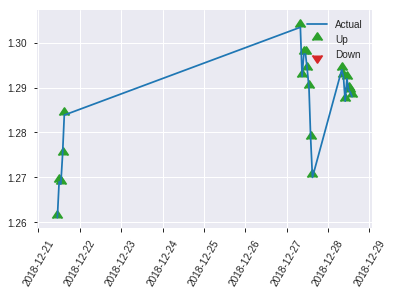


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2497591225520218
RMSE: 0.49975906450210766
LogLoss: 0.6926554728262776
Null degrees of freedom: 192
Residual degrees of freedom: -840
Null deviance: 267.49124794756074
Residual deviance: 267.3650125109431
AIC: 2333.365012510943
AUC: 0.5250376101439932
pr_auc: 0.5422210836153192
Gini: 0.05007522028798639
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47221685347368736: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      4    90   0.9574   (90.0/94.0)
1      0    99   0        (0.0/99.0)
Total  4    189  0.4663   (90.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.472217     0.6875    188
max f2                       0.472217     0.846154  188
max f0point5                 0.472217     0.578947  188
max accuracy                 0.529492     0.544041  148
max precision                0.620025     1         0
max recall                   0.472217     1         188
max specificity              0.620025     1         0
max absolute_mcc             0.587295     0.165041  11
max min_per_class_accuracy   0.548833     0.505051  94
max mean_per_class_accuracy  0.557667     0.542714  67

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 54.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.607768           0.974747  0.974747           0.5              0.614526  0.5                         0.614526            0.010101        0.010101                   -2.52525  -2.52525
    2        0.0207254                   0.600715           0.974747  0.974747           0.5              0.604872  0.5                         0.609699            0.010101        0.020202                   -2.52525  -2.52525
    3        0.0310881                   0.594676           1.94949   1.29966            1                0.599455  0.666667                    0.606284            0.020202        0.040404                   94.9495   29.9663
    4        0.0414508                   0.590953           1.94949   1.46212            1                0.592535  0.75                        0.602847            0.020202        0.0606061                  94.9495   46.2121
    5        0.0518135                   0.58845            1.94949   1.5596             1                0.590001  0.8                         0.600278            0.020202        0.0808081                  94.9495   55.9596
    6        0.103627                    0.57631            0.779798  1.1697             0.4              0.582324  0.6                         0.591301            0.040404        0.121212                   -22.0202  16.9697
    7        0.150259                    0.57068            0.866442  1.07558            0.444444         0.573485  0.551724                    0.585772            0.040404        0.161616                   -13.3558  7.55834
    8        0.202073                    0.568004           0.974747  1.04973            0.5              0.56929   0.538462                    0.581546            0.0505051       0.212121                   -2.52525  4.9728
    9        0.300518                    0.562001           0.923445  1.00836            0.473684         0.564649  0.517241                    0.57601             0.0909091       0.30303                    -7.6555   0.835946
    10       0.398964                    0.55385            1.33386   1.08868            0.684211         0.557369  0.558442                    0.571411            0.131313        0.434343                   33.3865   8.8679
    11       0.502591                    0.548699           0.682323  1.00489            0.35             0.551475  0.515464                    0.5673              0.0707071       0.505051                   -31.7677  0.48943
    12       0.601036                    0.54311            0.923445  0.991553           0.473684         0.54565   0.508621                    0.563754            0.0909091       0.59596                    -7.6555   -0.844653
    13       0.699482                    0.535483           1.12865   1.01085            0.578947         0.540195  0.518519                    0.560438            0.111111        0.707071                   12.8655   1.08492
    14       0.797927                    0.526972           1.12865   1.02538            0.578947         0.531188  0.525974                    0.556829            0.111111        0.818182                   12.8655   2.53837
    15       0.896373                    0.509806           0.923445  1.01419            0.473684         0.519912  0.520231                    0.552775            0.0909091       0.909091                   -7.6555   1.41881
    16       1                           0.457519           0.877273  1                  0.45             0.484242  0.512953                    0.545673      

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


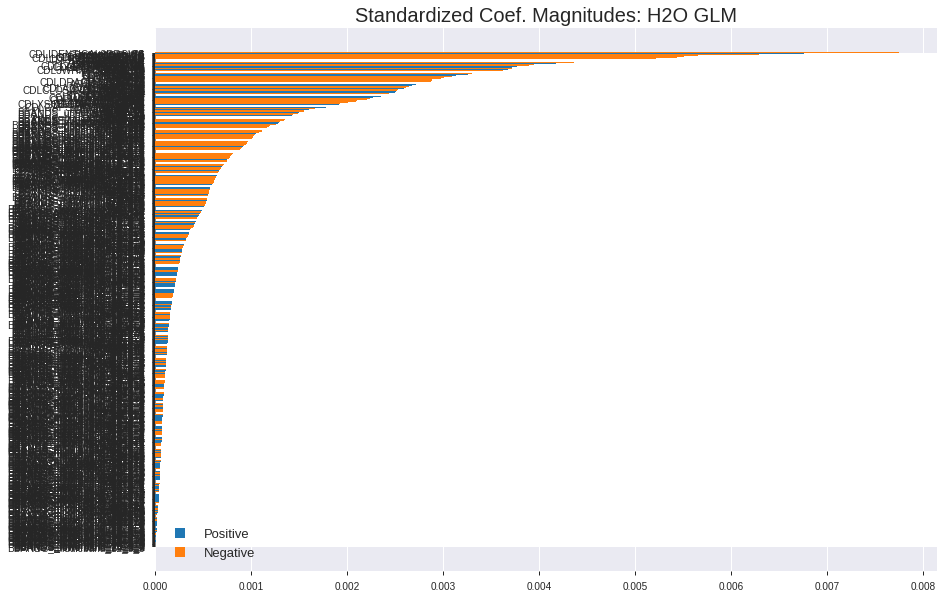

'log_likelihood'
--2019-08-25 13:21:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.4
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.4|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_132106_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_132106_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['aroondown_30',
 'aroondown_24',
 'CDLIDENTICAL3CROWS',
 'aroondown_14',
 'CDLSHORTLINE',
 'aroondown_20',
 'CDLDOJI',
 'PLUS_DM_8',
 'CDLSPINNINGTOP',
 'CDL3LINESTRIKE',
 'CDLHIGHWAVE',
 'CDLLONGLEGGEDDOJI',
 'CDLRICKSHAWMAN',
 'BETA_12',
 'CDLBELTHOLD',
 'SAREXT',
 'CDLDOJISTAR',
 'PLUS_DM_12',
 'BETA_8',
 'aroondown_12',
 'STDDEV_8',
 'PLUS_DM_14',
 'AROONOSC_24',
 'TRANGE',
 'AROONOSC_30',
 'CDLTAKURI',
 'CDLPIERCING',
 'CDLLADDERBOTTOM',
 'CDLEVENINGSTAR',
 'CDLENGULFING',
 'ADOSC',
 'BETA_20',
 'STDDEV_12',
 'CORREL_8',
 'CDL3OUTSIDE',
 'DX_30',
 'CDL3WHITESOLDIERS',
 'Volume',
 'MOM_12',
 'PLUS_DM_20',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'is_month_end',
 'PLUS_DI_8',
 'CDLHIKKAKE',
 'MFI_8',
 'hour',
 'CEIL',
 'FLOOR',
 'PLUS_DI_12',
 'DX_8',
 'CORREL_30',
 'VAR_12',
 'ROC_8',
 'ROCP_8',
 'PLUS_DI_14',
 'ROCR_8',
 'ROCR100_8',
 'CDLDRAGONFLYDOJI',
 'PLUS_DM_24',
 'AROONOSC_14',
 'DX_24',
 'aroondown_8',
 'TAN',
 'MOM_8',
 'BETA_30',
 'aroonup_8',
 'dayofweek',
 '

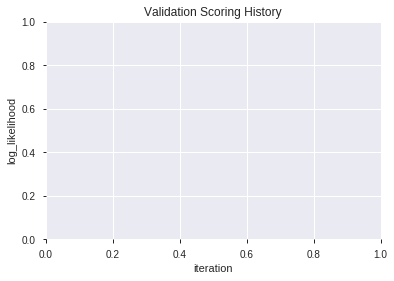

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_132235_model_3  0.577369  0.692206              0.461691  0.499344  0.249345
1  XGBoost_grid_1_AutoML_20190825_132235_model_5  0.559209  0.713667              0.483774  0.507829  0.257890
2               XGBoost_3_AutoML_20190825_132235  0.534386  0.704219              0.467548  0.505071  0.255096
3  XGBoost_grid_1_AutoML_20190825_132235_model_1  0.520954  0.712884              0.484043  0.509283  0.259369
4  XGBoost_grid_1_AutoML_20190825_132235_model_7  0.513325  0.726775              0.472867  0.514928  0.265151
5  XGBoost_grid_1_AutoML_20190825_132235_model_2  0.513110  0.697086              0.473404  0.501934  0.251938
6  XGBoost_grid_1_AutoML_20190825_132235_model_6  0.506985  0.714377              0.433484  0.509703  0.259797
7  XGBoost_grid_1_AutoML_20190825_132235_model_4  0.503116  0.703746              0.500000  0.505021  0.255047
8               XGBoost_1_AutoML_20190825_132235  0.501397  0.723890              0.494681  0.513862  0.264054
9               XGBoost_2_AutoML_20190825_132235  0.497099  0.708408              0.456641  0.507185  0.257237

variable  relative_importance  scaled_importance  percentage
0                     MFI_20            89.739517           1.000000    0.018524
1                     BETA_8            88.959320           0.991306    0.018363
2                     Volume            76.194641           0.849065    0.015728
3                        BOP            75.482704           0.841131    0.015582
4                     TRANGE            62.407150           0.695426    0.012882
..                       ...                  ...                ...         ...
284                 SAR_0.08             1.390309           0.015493    0.000287
285                 TRIMA_20             1.320559           0.014715    0.000273
286  BBANDS_lowerband_12_7_3             1.313707           0.014639    0.000271
287               MACDFIX_12             1.172425           0.013065    0.000242
288                ROCR100_8             0.388048           0.004324    0.000080

[289 rows x 4 columns]

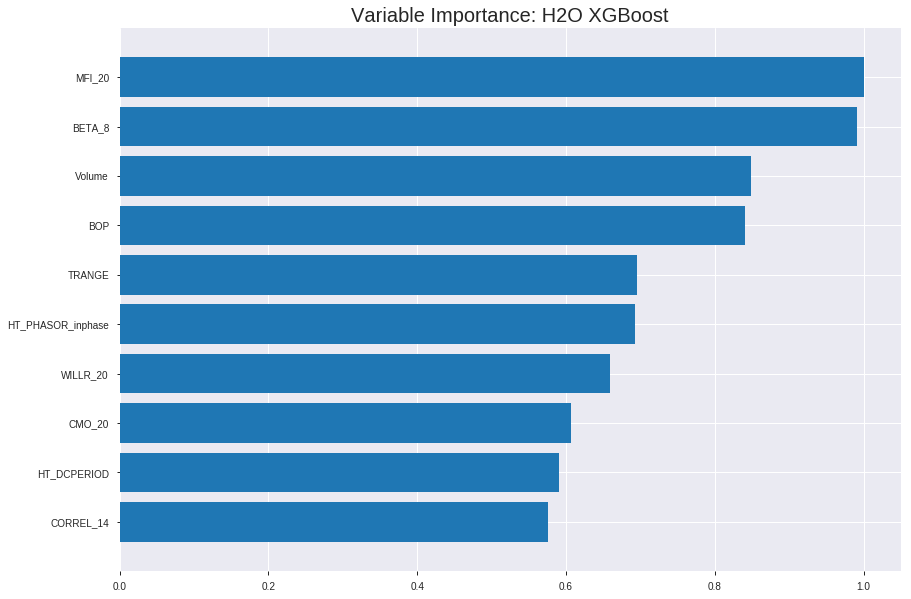

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_132235_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17250351818996118
RMSE: 0.4153354285273063
LogLoss: 0.5328787179580039
Mean Per-Class Error: 0.12255889365130734
AUC: 0.945753559155621
pr_auc: 0.9477741262193567
Gini: 0.891507118311242
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48966074734926224: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      573  96   0.1435   (96.0/669.0)
1      69   610  0.1016   (69.0/679.0)
Total  642  706  0.1224   (165.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489661     0.880866  209
max f2                       0.447419     0.911248  248
max f0point5                 0.534273     0.902896  172
max accuracy                 0.489661     0.877596  209
max precision                0.798599     1         0
max recall                   0.304738     1         362
max specificity              0.798599     1         0
max absolute_mcc             0.489661     0.755714  209
max min_per_class_accuracy   0.50009      0.875934  201
max mean_per_class_accuracy  0.489661     0.877441  209

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103858                   0.758706           1.98527    1.98527            1                0.776746  1                           0.776746            0.0206186       0.0206186                  98.5272   98.5272
    2        0.0200297                   0.73414            1.98527    1.98527            1                0.74366   1                           0.760816            0.0191458       0.0397644                  98.5272   98.5272
    3        0.0304154                   0.720806           1.98527    1.98527            1                0.726063  1                           0.748949            0.0206186       0.0603829                  98.5272   98.5272
    4        0.0400593                   0.709444           1.98527    1.98527            1                0.714389  1                           0.740629            0.0191458       0.0795287                  98.5272   98.5272
    5        0.0504451                   0.698243           1.98527    1.98527            1                0.704435  1                           0.733177            0.0206186       0.100147                   98.5272   98.5272
    6        0.100148                    0.668555           1.98527    1.98527            1                0.682045  1                           0.707801            0.0986745       0.198822                   98.5272   98.5272
    7        0.150593                    0.642523           1.98527    1.98527            1                0.654527  1                           0.689955            0.100147        0.298969                   98.5272   98.5272
    8        0.200297                    0.620798           1.83712    1.94851            0.925373         0.630145  0.981481                    0.675114            0.0913108       0.39028                    83.7118   94.8508
    9        0.300445                    0.580832           1.88233    1.92645            0.948148         0.599545  0.97037                     0.649924            0.188513        0.578792                   88.2332   92.645
    10       0.399852                    0.542698           1.71859    1.87477            0.865672         0.562321  0.944341                    0.628145            0.170839        0.749632                   71.8594   87.4775
    11       0.5                         0.501666           1.22057    1.74374            0.614815         0.522219  0.878338                    0.606929            0.122239        0.87187                    22.0575   74.3741
    12       0.600148                    0.464789           0.691169   1.5681             0.348148         0.481448  0.789864                    0.585989            0.0692194       0.94109                    -30.8831  56.8095
    13       0.699555                    0.426262           0.32594    1.39159            0.164179         0.44488   0.700954                    0.565938            0.0324006       0.97349                    -67.406   39.1585
    14       0.799703                    0.390088           0.191174   1.24126            0.0962963        0.408966  0.625232                    0.54628             0.0191458       0.992636                   -80.8826  24.1256
    15       0.899852                    0.341462           0.0588229  1.10966            0.0296296        0.369981  0.558945                    0.526659            0.00589102      0.998527                   -94.1177  10.9658
    16       1                           0.18882            0.0147057  1                  0.00740741       0.296924  0.503709                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2659187031992469
RMSE: 0.5156730584384324
LogLoss: 0.727550351066277
Mean Per-Class Error: 0.46568666935159087
AUC: 0.5094106591488791
pr_auc: 0.5065744356815092
Gini: 0.018821318297758127
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38094836473464966: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    188  0.9843   (188.0/191.0)
1      0    195  0        (0.0/195.0)
Total  3    383  0.487    (188.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.380948     0.67474    382
max f2                       0.380948     0.838349   382
max f0point5                 0.425569     0.565319   377
max accuracy                 0.579023     0.536269   265
max precision                0.74308      0.666667   8
max recall                   0.380948     1          382
max specificity              0.765986     0.994764   0
max absolute_mcc             0.380948     0.0894256  382
max min_per_class_accuracy   0.61846      0.502618   193
max mean_per_class_accuracy  0.579023     0.534313   265

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 60.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.760971           0.989744  0.989744           0.5              0.763541  0.5                         0.763541            0.0102564       0.0102564                  -1.02564  -1.02564
    2        0.0207254                   0.74529            1.48462   1.23718            0.75             0.756395  0.625                       0.759968            0.0153846       0.025641                   48.4615   23.7179
    3        0.0310881                   0.734634           0.494872  0.989744           0.25             0.739029  0.5                         0.752988            0.00512821      0.0307692                  -50.5128  -1.02564
    4        0.0414508                   0.730147           0.494872  0.866026           0.25             0.732256  0.4375                      0.747805            0.00512821      0.0358974                  -50.5128  -13.3974
    5        0.0518135                   0.724163           0.989744  0.890769           0.5              0.727221  0.45                        0.743688            0.0102564       0.0461538                  -1.02564  -10.9231
    6        0.101036                    0.704447           0.937652  0.913609           0.473684         0.714708  0.461538                    0.72957             0.0461538       0.0923077                  -6.23482  -8.63905
    7        0.150259                    0.686335           1.35439   1.058              0.684211         0.694625  0.534483                    0.718122            0.0666667       0.158974                   35.4386   5.80018
    8        0.202073                    0.67916            1.28667   1.11663            0.65             0.682906  0.564103                    0.709093            0.0666667       0.225641                   28.6667   11.6634
    9        0.300518                    0.656219           0.729285  0.989744           0.368421         0.668736  0.5                         0.695872            0.0717949       0.297436                   -27.0715  -1.02564
    10       0.401554                    0.638664           0.964366  0.983358           0.487179         0.646274  0.496774                    0.683393            0.0974359       0.394872                   -3.56345  -1.66419
    11       0.5                         0.618593           1.09393   1.00513            0.552632         0.626956  0.507772                    0.672281            0.107692        0.502564                   9.39271   0.512821
    12       0.601036                    0.600709           1.16739   1.0324             0.589744         0.609349  0.521552                    0.661702            0.117949        0.620513                   16.739    3.2405
    13       0.699482                    0.574279           1.09393   1.04106            0.552632         0.587566  0.525926                    0.651268            0.107692        0.728205                   9.39271   4.10636
    14       0.800518                    0.534862           0.761341  1.00576            0.384615         0.556953  0.508091                    0.639364            0.0769231       0.805128                   -23.8659  0.575886
    15       0.898964                    0.482609           0.937652  0.9983             0.473684         0.508207  0.504323                    0.625001            0.0923077       0.897436                   -6.23482  -0.169955
    16       1                           0.361493           1.01512   1                  0.512821         0.439965  0.505181                    0.60630


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:22:51  4.684 sec   0                  0.5              0.693147            0.5             0                  1                0.496291                         0.5                0.693147              0.5               0                    1                  0.494819
    2019-08-25 13:22:52  5.245 sec   5                  0.489165         0.671668            0.757395        0.746593           1.58822          0.339763                         0.501236           0.695639              0.496845          0.494233             0.395897           0.489637
    2019-08-25 13:22:52  5.466 sec   10                 0.481046         0.655771            0.796366        0.798386           1.84347          0.307122                         0.502873           0.698987              0.482561          0.47875              0.989744           0.487047
    2019-08-25 13:22:52  5.723 sec   15                 0.468917         0.632368            0.856194        0.863173           1.98527          0.217359                         0.50228            0.697873              0.508847          0.500901             0                  0.479275
    2019-08-25 13:22:53  5.975 sec   20                 0.462067         0.619203            0.869204        0.872416           1.98527          0.209199                         0.503715           0.700958              0.520217          0.510595             0.494872           0.476684
    2019-08-25 13:22:53  6.299 sec   25                 0.451827         0.599957            0.896837        0.898228           1.98527          0.190653                         0.507909           0.70991               0.518566          0.517939             0.494872           0.494819
    2019-08-25 13:22:53  6.555 sec   30                 0.443468         0.584356            0.910293        0.910978           1.98527          0.169881                         0.50903            0.712395              0.523292          0.521972             0.494872           0.494819
    2019-08-25 13:22:53  6.835 sec   35                 0.435891         0.570281            0.920366        0.924587           1.98527          0.167656                         0.511725           0.718406              0.510968          0.508428             0.494872           0.481865
    2019-08-25 13:22:54  7.096 sec   40                 0.428535         0.55678             0.92956         0.931844           1.98527          0.151335                         0.512354           0.719809              0.508793          0.507269             0                  0.479275
    2019-08-25 13:22:54  7.370 sec   45                 0.42096          0.543087            0.939313        0.942632           1.98527          0.132047                         0.516112           0.728399              0.497919          0.50081              1.48462            0.479275
    2019-08-25 13:22:54  7.636 sec   50                 0.415335         0.532879            0.945754        0.947774           1.98527          0.122404                         0.515673           0.72755               0.509411          0.506574             0.989744           0.487047

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
MFI_20                   89.73951721191406      1.0                    0.01852448112835692
BETA_8                   88.95932006835938      0.9913059801546257     0.018363428921801726
Volume                   76.19464111328125      0.8490645312181982     0.015728479885308733
BOP                      75.48270416259766      0.8411311594684662     0.01558151829004658
TRANGE                   62.40715026855469      0.6954255182940671     0.012882396889816277
---                      ---                    ---                    ---
SAR_0.08                 1.3903093338012695     0.015492721345025114   0.0002869946241828102
TRIMA_20                 1.3205585479736328     0.014715463031244299   0.000272596317217319
BBANDS_lowerband_12_7_3  1.313706636428833      0.014639109694858285   0.00027118191127834917
MACDFIX_12               1.1724252700805664     0.013064760169279271   0.00024201790320232304
ROCR100_8                0.3880481719970703     0.0043241615739999986  8.010284947352914e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5751295336787565)

('F1', 0.6859205776173284)

('auc', 0.5773694390715668)

('logloss', 0.6922056731000686)

('mean_per_class_error', 0.4235439501396948)

('rmse', 0.4993440722679279)

('mse', 0.24934450250911758)

xgboost prediction progress: |████████████████████████████████████████████| 100%


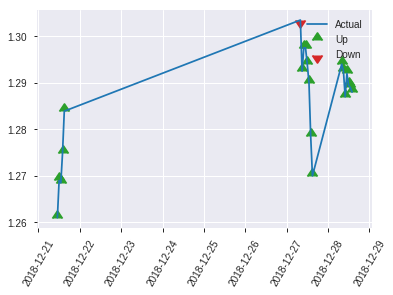


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24934450250911758
RMSE: 0.4993440722679279
LogLoss: 0.6922056731000686
Mean Per-Class Error: 0.4235439501396948
AUC: 0.5773694390715668
pr_auc: 0.5747992808805179
Gini: 0.15473887814313358
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4543774724006653: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      11   83   0.883    (83.0/94.0)
1      4    95   0.0404   (4.0/99.0)
Total  15   178  0.4508   (87.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.454377     0.685921  177
max f2                       0.406292     0.84471   189
max f0point5                 0.518665     0.596798  146
max accuracy                 0.597222     0.57513   86
max precision                0.683225     0.727273  21
max recall                   0.406292     1         189
max specificity              0.75565      0.989362  0
max absolute_mcc             0.631885     0.160792  50
max min_per_class_accuracy   0.588158     0.56383   96
max mean_per_class_accuracy  0.597222     0.576456  86

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 58.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.739387           0.974747  0.974747           0.5              0.754557  0.5                         0.754557            0.010101        0.010101                   -2.52525  -2.52525
    2        0.0207254                   0.736255           0.974747  0.974747           0.5              0.737787  0.5                         0.746172            0.010101        0.020202                   -2.52525  -2.52525
    3        0.0310881                   0.726267           0.974747  0.974747           0.5              0.734234  0.5                         0.742193            0.010101        0.030303                   -2.52525  -2.52525
    4        0.0414508                   0.722026           1.94949   1.21843            1                0.723762  0.625                       0.737585            0.020202        0.0505051                  94.9495   21.8434
    5        0.0518135                   0.712424           0.974747  1.1697             0.5              0.718542  0.6                         0.733776            0.010101        0.0606061                  -2.52525  16.9697
    6        0.103627                    0.690997           1.5596    1.36465            0.8              0.700286  0.7                         0.717031            0.0808081       0.141414                   55.9596   36.4646
    7        0.150259                    0.669774           0.866442  1.21003            0.444444         0.676246  0.62069                     0.704374            0.040404        0.181818                   -13.3558  21.0031
    8        0.202073                    0.655829           1.36465   1.24968            0.7              0.663727  0.641026                    0.693951            0.0707071       0.252525                   36.4646   24.9676
    9        0.300518                    0.625771           0.923445  1.14281            0.473684         0.637106  0.586207                    0.675329            0.0909091       0.343434                   -7.6555   14.2807
    10       0.398964                    0.607235           1.02605   1.114              0.526316         0.61844   0.571429                    0.661292            0.10101         0.444444                   2.605     11.3997
    11       0.502591                    0.588158           1.1697    1.12548            0.6              0.597435  0.57732                     0.648125            0.121212        0.565657                   16.9697   12.5482
    12       0.601036                    0.568439           0.82084   1.07558            0.421053         0.580661  0.551724                    0.637075            0.0808081       0.646465                   -17.916   7.55834
    13       0.699482                    0.543677           0.923445  1.05417            0.473684         0.555077  0.540741                    0.625535            0.0909091       0.737374                   -7.6555   5.41713
    14       0.797927                    0.505372           1.02605   1.0507             0.526316         0.525462  0.538961                    0.613188            0.10101         0.838384                   2.605     5.07018
    15       0.896373                    0.458723           0.82084   1.02546            0.421053         0.476946  0.526012                    0.598225            0.0808081       0.919192                   -17.916   2.54569
    16       1                           0.362424           0.779798  1                  0.4              0.43166   0.512953                    0.580964      

This function is available for GLM models only


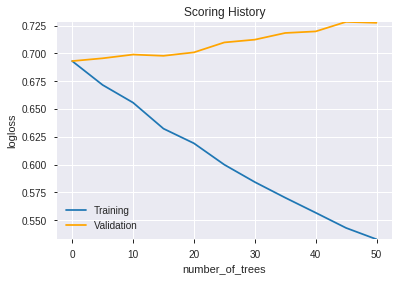

--2019-08-25 13:23:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmod

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_132235_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_132235_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['MFI_20',
 'BETA_8',
 'Volume',
 'BOP',
 'TRANGE',
 'HT_PHASOR_inphase',
 'WILLR_20',
 'CMO_20',
 'HT_DCPERIOD',
 'CORREL_14',
 'DX_20',
 'STDDEV_30',
 'MFI_24',
 'CORREL_24',
 'SUB',
 'DX_8',
 'WILLR_12',
 'PLUS_DM_8',
 'aroonup_20',
 'OBV',
 'CORREL_8',
 'MFI_30',
 'CORREL_20',
 'WILLR_8',
 'ATR_20',
 'DX_12',
 'STOCH_slowk',
 'LINEARREG_ANGLE_8',
 'BETA_30',
 'BETA_24',
 'STDDEV_24',
 'CMO_8',
 'MFI_12',
 'PLUS_DM_30',
 'MINUS_DM_24',
 'HT_PHASOR_quadrature',
 'ROC_24',
 'AROONOSC_30',
 'STOCHF_fastk',
 'LINEARREG_SLOPE_8',
 'CORREL_12',
 'STDDEV_20',
 'WILLR_14',
 'STOCHRSI_fastd',
 'PLUS_DM_14',
 'MINUS_DM_30',
 'MOM_8',
 'RSI_8',
 'SAREXT',
 'VAR_30',
 'ADXR_8',
 'PLUS_DI_8',
 'MFI_8',
 'CDLHIGHWAVE',
 'CORREL_30',
 'AD',
 'DX_30',
 'MACDFIX_hist_8',
 'MINUS_DI_30',
 'AROONOSC_24',
 'DX_24',
 'TRIMA_12',
 'WILLR_30',
 'CCI_14',
 'CDLSPINNINGTOP',
 'CCI_12',
 'MINUS_DI_8',
 'ADXR_14',
 'VAR_8',
 'CCI_24',
 'PLUS_DM_12',
 'NATR_8',
 'DX_14',
 'MACDFIX_hist_24',
 'LINEARREG_ANGLE_2

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

77

['BBANDS_upperband_14_7_2',
 'BBANDS_upperband_14_7_3',
 'BBANDS_upperband_20_0_2',
 'BBANDS_lowerband_20_0_5',
 'BBANDS_upperband_20_5_2',
 'BBANDS_upperband_20_5_3',
 'BBANDS_middleband_20_5_3',
 'BBANDS_middleband_20_6_2',
 'BBANDS_lowerband_20_6_4',
 'BBANDS_upperband_24_2_4',
 'BBANDS_lowerband_24_6_3',
 'BBANDS_upperband_24_7_3',
 'aroonup_8',
 'CCI_8',
 'CMO_8',
 'DX_8',
 'MFI_8',
 'ROCP_8',
 'TRIX_8',
 'WILLR_8',
 'PLUS_DI_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'WILLR_12',
 'aroondown_14',
 'aroonup_14',
 'CCI_14',
 'DX_14',
 'MFI_14',
 'PLUS_DI_14',
 'ROCP_14',
 'RSI_14',
 'DX_20',
 'MACDFIX_signal_20',
 'MACDFIX_hist_20',
 'MFI_20',
 'ROCP_20',
 'ROCR_20',
 'aroondown_24',
 'aroonup_24',
 'AROONOSC_24',
 'CCI_24',
 'CMO_24',
 'MFI_24',
 'ROC_24',
 'ROCP_24',
 'ROCR_24',
 'RSI_24',
 'aroonup_30',
 'CCI_30',
 'DX_30',
 'MINUS_DI_30',
 'PLUS_DI_30',
 'ROCP_30',
 'ROCR_30',
 'MACD_hist',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'AD',
 'ADOSC',
 '

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_132506_model_8  0.538577  0.688752              0.494681  0.497815  0.247820
1  DeepLearning_grid_1_AutoML_20190825_132506_model_1  0.522351  2.019973              0.494681  0.650090  0.422617
2  DeepLearning_grid_1_AutoML_20190825_132506_model_7  0.521814  0.737566              0.472867  0.519126  0.269492
3  DeepLearning_grid_1_AutoML_20190825_132506_model_2  0.513432  1.253316              0.467279  0.608107  0.369794
4  DeepLearning_grid_1_AutoML_20190825_132506_model_6  0.512143  0.706055              0.494681  0.506225  0.256264
5  DeepLearning_grid_1_AutoML_20190825_132506_model_4  0.502579  0.933747              0.489362  0.570386  0.325341
6  DeepLearning_grid_1_AutoML_20190825_132506_model_5  0.499033  0.702604              0.484043  0.504525  0.254546
7  DeepLearning_grid_1_AutoML_20190825_132506_model_9  0.492478  0.693870              0.484043  0.500357  0.250357
8  DeepLearning_grid_1_AutoML_20190825_132506_model_3  0.490221  1.005421              0.489362  0.587822  0.345535
9               DeepLearning_1_AutoML_20190825_132506  0.478186  1.093381              0.466742  0.607676  0.369271

variable  relative_importance  scaled_importance  percentage
0   aroondown_24             1.000000           1.000000    0.018470
1   aroondown_14             0.903582           0.903582    0.016689
2         BETA_8             0.843641           0.843641    0.015582
3           DX_8             0.840598           0.840598    0.015526
4     aroonup_30             0.812807           0.812807    0.015012
..           ...                  ...                ...         ...
72        RSI_24             0.633901           0.633901    0.011708
73     MACD_hist             0.631052           0.631052    0.011655
74        CCI_30             0.629703           0.629703    0.011630
75        RSI_14             0.627614           0.627614    0.011592
76        TRIX_8             0.621723           0.621723    0.011483

[77 rows x 4 columns]

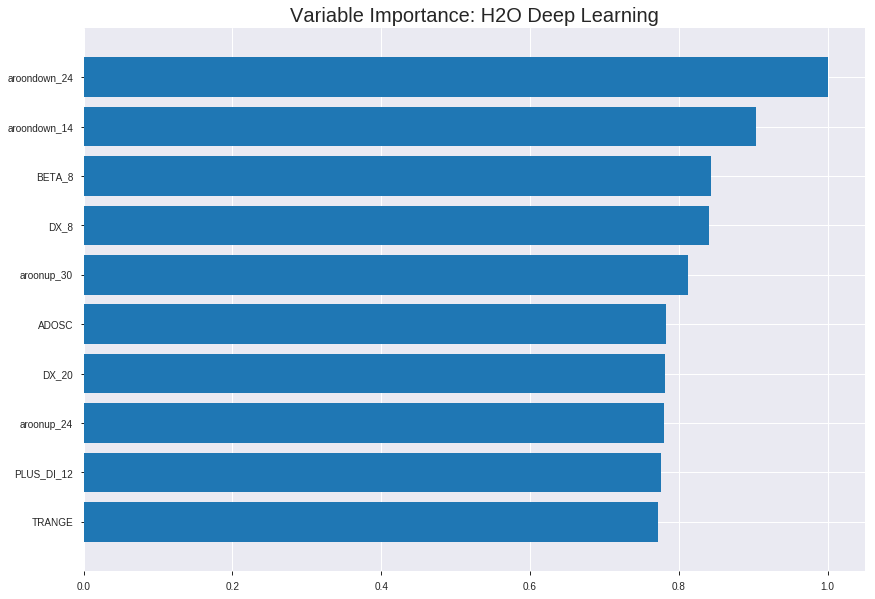

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_132506_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24941077814059157
RMSE: 0.49941043054845335
LogLoss: 0.6919629764875902
Mean Per-Class Error: 0.4683401907755844
AUC: 0.5413328754367079
pr_auc: 0.5787571566021598
Gini: 0.08266575087341588
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4509027262723642: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    668   0.9985   (668.0/669.0)
1      0    679   0        (0.0/679.0)
Total  1    1347  0.4955   (668.0/1348.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.450903     0.670286  398
max f2                       0.450903     0.835589  398
max f0point5                 0.456483     0.560294  381
max accuracy                 0.480798     0.531157  86
max precision                0.595771     1         0
max recall                   0.450903     1         398
max specificity              0.595771     1         0
max absolute_mcc             0.482881     0.117947  70
max min_per_class_accuracy   0.478855     0.5243    116
max mean_per_class_accuracy  0.480798     0.53166   86

Gains/Lift Table: Avg response rate: 50.37 %, avg score: 47.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain         cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -----------  -----------------
    1        0.0103858                   0.547121           1.84347   1.84347            0.928571         0.565616  0.928571                    0.565616            0.0191458       0.0191458                  84.3467      84.3467
    2        0.0200297                   0.526068           1.22171   1.5441             0.615385         0.535312  0.777778                    0.551025            0.011782        0.0309278                  22.1706      54.4101
    3        0.0304154                   0.508089           1.55986   1.54948            0.785714         0.515726  0.780488                    0.538972            0.0162003       0.0471281                  55.9857      54.9481
    4        0.0400593                   0.49265            1.06899   1.43381            0.538462         0.499358  0.722222                    0.529435            0.0103093       0.0574374                  6.89929      43.3808
    5        0.0504451                   0.485663           1.41805   1.43056            0.714286         0.489461  0.720588                    0.521205            0.0147275       0.0721649                  41.8052      43.0564
    6        0.410979                    0.481551           1.02123   1.07147            0.514403         0.481585  0.539711                    0.486448            0.368189        0.440353                   2.12307      7.14738
    7        0.5                         0.478786           0.943004  1.0486             0.475            0.480031  0.52819                     0.485305            0.083947        0.5243                     -5.69956     4.86009
    8        0.600148                    0.476075           0.999989  1.04049            0.503704         0.477506  0.524104                    0.484004            0.100147        0.624448                   -0.00109093  4.04889
    9        0.699555                    0.472109           0.963005  1.02948            0.485075         0.47422   0.518558                    0.482614            0.095729        0.720177                   -3.69947     2.94785
    10       0.799703                    0.468097           0.911755  1.01474            0.459259         0.470194  0.511132                    0.481058            0.0913108       0.811487                   -8.82452     1.47357
    11       0.899852                    0.462801           0.985283  1.01146            0.496296         0.465422  0.509481                    0.479318            0.0986745       0.910162                   -1.47166     1.14579
    12       1                           0.450647           0.897049  1                  0.451852         0.459169  0.503709                    0.4773              0.089838        1                          -10.2951     0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2518101430025969
RMSE: 0.5018068781937897
LogLoss: 0.6968037632850174
Mean Per-Class Error: 0.47171432407034497
AUC: 0.4962276815679957
pr_auc: 0.5014003232379395
Gini: -0.007544636864008636
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4518449820365072: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    191  1        (191.0/191.0)
1      0    195  0        (0.0/195.0)
Total  0    386  0.4948   (191.0/386.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451845     0.671256  385
max f2                       0.451845     0.836192  385
max f0point5                 0.457351     0.561798  373
max accuracy                 0.484842     0.528497  200
max precision                0.631587     1         0
max recall                   0.451845     1         385
max specificity              0.631587     1         0
max absolute_mcc             0.453317     0.101274  381
max min_per_class_accuracy   0.488038     0.512821  192
max mean_per_class_accuracy  0.484842     0.528286  200

Gains/Lift Table: Avg response rate: 50.52 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.611751           1.48462   1.48462            0.75             0.623286  0.75                        0.623286            0.0153846       0.0153846                  48.4615   48.4615
    2        0.0207254                   0.603971           0.989744  1.23718            0.5              0.608063  0.625                       0.615675            0.0102564       0.025641                   -1.02564  23.7179
    3        0.0310881                   0.596019           0.989744  1.1547             0.5              0.600432  0.583333                    0.610594            0.0102564       0.0358974                  -1.02564  15.4701
    4        0.0414508                   0.588842           0.989744  1.11346            0.5              0.592522  0.5625                      0.606076            0.0102564       0.0461538                  -1.02564  11.3462
    5        0.0518135                   0.582405           0         0.890769           0                0.586613  0.45                        0.602183            0               0.0461538                  -100      -10.9231
    6        0.101036                    0.566422           0.937652  0.913609           0.473684         0.574385  0.461538                    0.588641            0.0461538       0.0923077                  -6.23482  -8.63905
    7        0.150259                    0.553328           1.04184   0.955615           0.526316         0.559303  0.482759                    0.57903             0.0512821       0.14359                    4.18354   -4.43855
    8        0.202073                    0.539899           1.08872   0.989744           0.55             0.546734  0.5                         0.570749            0.0564103       0.2                        8.87179   -1.02564
    9        0.300518                    0.521068           1.09393   1.02387            0.552632         0.528973  0.517241                    0.557064            0.107692        0.307692                   9.39271   2.38727
    10       0.401554                    0.503098           0.812097  0.970587           0.410256         0.511998  0.490323                    0.545725            0.0820513       0.389744                   -18.7903  -2.94127
    11       0.5                         0.487983           1.2502    1.02564            0.631579         0.495663  0.518135                    0.535868            0.123077        0.512821                   25.0202   2.5641
    12       0.601036                    0.474553           0.913609  1.00681            0.461538         0.479648  0.508621                    0.526417            0.0923077       0.605128                   -8.63905  0.680813
    13       0.699482                    0.471331           0.625101  0.953086           0.315789         0.472848  0.481481                    0.518878            0.0615385       0.666667                   -37.4899  -4.69136
    14       0.800518                    0.468877           1.42117   1.01216            0.717949         0.470113  0.511327                    0.512723            0.14359         0.810256                   42.117    1.2165
    15       0.898964                    0.463124           0.833468  0.992596           0.421053         0.466246  0.501441                    0.507633            0.0820513       0.892308                   -16.6532  -0.740412
    16       1                           0.451845           1.06588   1                  0.538462         0.458753  0.505181                    0.502695  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:30:51  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 13:30:53  1 min 13.504 sec  581 obs/sec       0.937685  1             1264       0.51591          0.728493            -0.0647107     0.497914        0.505583           0.850831         0.496291                         0.535506           0.778374              -0.147191        0.517277          0.514729             0.494872           0.487047
    2019-08-25 13:31:06  1 min 25.854 sec  857 obs/sec       8.49258   9             11448      0.502613         0.698407            -0.0105366     0.47708         0.480195           0.709026         0.495549                         0.501976           0.697121              -0.00802759      0.505504          0.504802             0.494872           0.479275
    2019-08-25 13:31:18  1 min 38.232 sec  984 obs/sec       17.9458   19            24191      0.49941          0.691963            0.00230198     0.541333        0.578757           1.84347          0.495549                         0.501807           0.696804              -0.00734875      0.496228          0.5014               1.48462            0.494819
    2019-08-25 13:31:30  1 min 50.581 sec  1074 obs/sec      28.3175   30            38172      0.489894         0.67213             0.0399643      0.606085        0.627053           1.98527          0.454006                         0.50804            0.711336              -0.0325305       0.509464          0.524098             1.48462            0.494819
    2019-08-25 13:31:44  2 min  4.454 sec  1133 obs/sec      40.5497   43            54661      0.473116         0.631426            0.104596       0.651558        0.674797           1.98527          0.436202                         0.552195           0.894912              -0.219807        0.523238          0.531527             1.48462            0.494819
    2019-08-25 13:31:56  2 min 16.476 sec  1182 obs/sec      51.8227   55            69857      0.464866         0.610742            0.135551       0.671164        0.719455           1.98527          0.425816                         0.52509            0.774139              -0.102996        0.514942          0.539598             1.48462            0.494819
    2019-08-25 13:32:08  2 min 28.497 sec  1216 obs/sec      63.1387   67            85111      0.455494         0.585437            0.170057       0.692566        0.736761           1.98527          0.403561                         0.54865            0.903474              -0.204199        0.512337          0.528983             1.48462            0.492228
    2019-08-25 13:32:09  2 min 29.688 sec  1216 obs/sec      63.1387   67            85111      0.49941          0.691963            0.00230198     0.541333        0.578757           1.84347          0.495549                         0.501807           0.696804              -0.00734875      0.496228          0.5014               1.48462            0.494819

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
aroondown_24  1.0                    1.0                  0.018469587904301622
aroondown_14  0.9035820364952087     0.9035820364952087   0.016688787851796134
BETA_8        0.8436408638954163     0.8436408638954163   0.015581699095377353
DX_8          0.8405981063842773     0.8405981063842773   0.015525500618053897
aroonup_30    0.8128069639205933     0.8128069639205933   0.015012209669359915
---           ---                    ---                  ---
RSI_24        0.633901059627533      0.633901059627533    0.011707891343420665
MACD_hist     0.6310522556304932     0.6310522556304932   0.011655275107575212
CCI_30        0.6297026872634888     0.6297026872634888   0.01163034913598796
RSI_14        0.6276137232780457     0.6276137232780457   0.011591766832029898
TRIX_8        0.6217225193977356     0.6217225193977356   0.011482958724100349


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5492227979274611)

('F1', 0.6804123711340206)

('auc', 0.5385772619815172)

('logloss', 0.6887519644634359)

('mean_per_class_error', 0.44793681495809157)

('rmse', 0.49781547997371717)

('mse', 0.2478202521014624)

deeplearning prediction progress: |███████████████████████████████████████| 100%


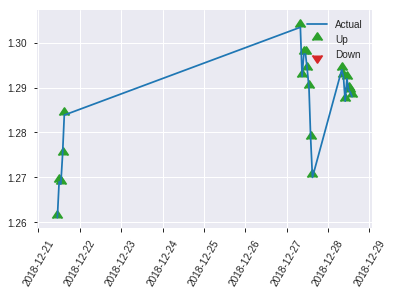


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2478202521014624
RMSE: 0.49781547997371717
LogLoss: 0.6887519644634359
Mean Per-Class Error: 0.44793681495809157
AUC: 0.5385772619815172
pr_auc: 0.5602599305791927
Gini: 0.07715452396303446
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4599664996648848: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      1    93   0.9894   (93.0/94.0)
1      0    99   0        (0.0/99.0)
Total  1    192  0.4819   (93.0/193.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459966     0.680412  191
max f2                       0.459966     0.841837  191
max f0point5                 0.464691     0.577157  180
max accuracy                 0.512944     0.549223  75
max precision                0.615099     1         0
max recall                   0.459966     1         191
max specificity              0.615099     1         0
max absolute_mcc             0.592612     0.141757  3
max min_per_class_accuracy   0.503328     0.531915  96
max mean_per_class_accuracy  0.539819     0.552063  36

Gains/Lift Table: Avg response rate: 51.30 %, avg score: 50.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103627                   0.5989             1.94949   1.94949            1                0.610318  1                           0.610318            0.020202        0.020202                   94.9495   94.9495
    2        0.0207254                   0.591333           1.94949   1.94949            1                0.595467  1                           0.602893            0.020202        0.040404                   94.9495   94.9495
    3        0.0310881                   0.586967           0         1.29966            0                0.589545  0.666667                    0.598443            0               0.040404                   -100      29.9663
    4        0.0414508                   0.576575           0.974747  1.21843            0.5              0.582657  0.625                       0.594497            0.010101        0.0505051                  -2.52525  21.8434
    5        0.0518135                   0.573796           0         0.974747           0                0.574917  0.5                         0.590581            0               0.0505051                  -100      -2.52525
    6        0.103627                    0.562928           1.5596    1.26717            0.8              0.569067  0.65                        0.579824            0.0808081       0.131313                   55.9596   26.7172
    7        0.150259                    0.544514           1.29966   1.27726            0.666667         0.55139   0.655172                    0.571               0.0606061       0.191919                   29.9663   27.7255
    8        0.202073                    0.539548           1.1697    1.24968            0.6              0.541906  0.641026                    0.56354             0.0606061       0.252525                   16.9697   24.9676
    9        0.300518                    0.527468           0.718235  1.07558            0.368421         0.531964  0.551724                    0.553196            0.0707071       0.323232                   -28.1765  7.55834
    10       0.398964                    0.512557           1.23126   1.114              0.631579         0.519973  0.571429                    0.544998            0.121212        0.444444                   23.126    11.3997
    11       0.502591                    0.503328           0.877273  1.06519            0.45             0.507939  0.546392                    0.537357            0.0909091       0.535354                   -12.2727  6.5188
    12       0.601036                    0.488464           0.923445  1.04197            0.473684         0.497274  0.534483                    0.530792            0.0909091       0.626263                   -7.6555   4.19714
    13       0.699482                    0.476344           0.718235  0.996409           0.368421         0.480175  0.511111                    0.523668            0.0707071       0.69697                    -28.1765  -0.359147
    14       0.797927                    0.471463           1.02605   1.00007            0.526316         0.473922  0.512987                    0.517531            0.10101         0.79798                    2.605     0.0065591
    15       0.896373                    0.46797            1.02605   1.00292            0.526316         0.46989   0.514451                    0.512298            0.10101         0.89899                    2.605     0.291937
    16       1                           0.459133           0.974747  1                  0.5              0.463908  0.512953                    0.507284    

This function is available for GLM models only


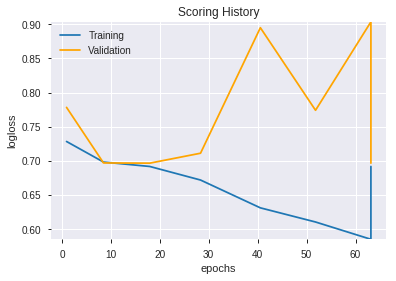

--2019-08-25 13:33:43--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.147.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.147.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_132506_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_132506_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_b06e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['aroondown_24',
 'aroondown_14',
 'BETA_8',
 'DX_8',
 'aroonup_30',
 'ADOSC',
 'DX_20',
 'aroonup_24',
 'PLUS_DI_12',
 'TRANGE',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastk',
 'DX_14',
 'AROONOSC_24',
 'MFI_20',
 'STOCHF_fastk',
 'DX_30',
 'MFI_8',
 'aroonup_14',
 'STOCH_slowk',
 'ATR_12',
 'WILLR_8',
 'PLUS_DI_30',
 'ROCR_12',
 'PLUS_DI_14',
 'MFI_14',
 'BBANDS_middleband_20_6_2',
 'STOCH_slowd',
 'BBANDS_middleband_20_5_3',
 'aroonup_8',
 'CORREL_12',
 'NATR_8',
 'AD',
 'HT_PHASOR_inphase',
 'ROCR100_12',
 'MFI_24',
 'WCLPRICE',
 'ROCP_20',
 'BBANDS_upperband_24_7_3',
 'ROCR_24',
 'ROCP_14',
 'HT_PHASOR_quadrature',
 'ROCP_24',
 'BBANDS_upperband_14_7_3',
 'BBANDS_upperband_24_2_4',
 'BBANDS_lowerband_24_6_3',
 'CCI_14',
 'LINEARREG_SLOPE_8',
 'BBANDS_upperband_14_7_2',
 'NATR_14',
 'MACDFIX_hist_20',
 'CDLHIKKAKE',
 'ROCP_8',
 'ROCP_30',
 'BBANDS_upperband_20_5_2',
 'BBANDS_upperband_20_0_2',
 'ROCR_30',
 'ROCP_12',
 'CCI_8',
 'ROCR_20',
 'CMO_24',
 'MINUS_DI_30',
 'BBANDS_lowerband_20_0_5

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

In [0]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

In [0]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.575
GLM             0.560
XGBoost         0.575
dtype: float64

DeepLearning    GLM  XGBoost
All          0.560  0.544    0.575
DLF          0.560  0.539    0.549
Fwe          0.549  0.544    0.575
RFE          0.549  0.560    0.560
XGBF         0.575  0.539    0.549





F1


DeepLearning    0.703
GLM             0.688
XGBoost         0.686
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.688    0.686
DLF          0.688  0.688    0.678
Fwe          0.683  0.688    0.686
RFE          0.680  0.685    0.680
XGBF         0.703  0.688    0.678





auc


DeepLearning    0.551
GLM             0.548
XGBoost         0.577
dtype: float64

DeepLearning    GLM  XGBoost
All          0.551  0.525    0.577
DLF          0.548  0.497    0.522
Fwe          0.537  0.525    0.577
RFE          0.539  0.548    0.525
XGBF         0.544  0.497    0.522





logloss


DeepLearning    1.627
GLM             0.693
XGBoost         0.717
dtype: float64

DeepLearning    GLM  XGBoost
All          0.923  0.693    0.692
DLF          0.808  0.693    0.713
Fwe          1.627  0.693    0.692
RFE          0.689  0.690    0.717
XGBF         1.040  0.693    0.713





mean_per_class_error


DeepLearning    0.451
GLM             0.471
XGBoost         0.450
dtype: float64

DeepLearning    GLM  XGBoost
All          0.445  0.457    0.424
DLF          0.445  0.471    0.450
Fwe          0.451  0.457    0.424
RFE          0.448  0.444    0.449
XGBF         0.435  0.471    0.450





rmse


DeepLearning    0.618
GLM             0.500
XGBoost         0.510
dtype: float64

DeepLearning    GLM  XGBoost
All          0.573  0.500    0.499
DLF          0.536  0.500    0.509
Fwe          0.618  0.500    0.499
RFE          0.498  0.499    0.510
XGBF         0.556  0.500    0.509





mse


DeepLearning    0.382
GLM             0.250
XGBoost         0.260
dtype: float64

DeepLearning    GLM  XGBoost
All          0.328  0.250    0.249
DLF          0.287  0.250    0.259
Fwe          0.382  0.250    0.249
RFE          0.248  0.249    0.260
XGBF         0.309  0.250    0.259

{'F1':       DeepLearning    GLM  XGBoost
 All          0.691    NaN      NaN
 DLF          0.688    NaN      NaN
 DLF            NaN  0.688      NaN
 DLF            NaN    NaN    0.678
 All            NaN  0.688      NaN
 All            NaN    NaN    0.686
 XGBF         0.703    NaN      NaN
 XGBF           NaN  0.688      NaN
 XGBF           NaN    NaN    0.678
 Fwe          0.683    NaN      NaN
 Fwe            NaN  0.688      NaN
 Fwe            NaN    NaN    0.686
 RFE          0.680    NaN      NaN
 RFE            NaN  0.685      NaN
 RFE            NaN    NaN    0.680,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.560    NaN      NaN
 DLF          0.560    NaN      NaN
 DLF            NaN  0.539      NaN
 DLF            NaN    NaN    0.549
 All            NaN  0.544      NaN
 All            NaN    NaN    0.575
 XGBF         0.575    NaN      NaN
 XGBF           NaN  0.539      NaN
 XGBF           NaN    NaN    0.549
 Fwe          0.549    NaN      NaN
 Fwe     

accuracy


DeepLearning    0.575
GLM             0.560
XGBoost         0.575
dtype: float64

DeepLearning    GLM  XGBoost
All          0.560  0.544    0.575
DLF          0.560  0.539    0.549
Fwe          0.549  0.544    0.575
RFE          0.549  0.560    0.560
XGBF         0.575  0.539    0.549





F1


DeepLearning    0.703
GLM             0.688
XGBoost         0.686
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.688    0.686
DLF          0.688  0.688    0.678
Fwe          0.683  0.688    0.686
RFE          0.680  0.685    0.680
XGBF         0.703  0.688    0.678





auc


DeepLearning    0.551
GLM             0.548
XGBoost         0.577
dtype: float64

DeepLearning    GLM  XGBoost
All          0.551  0.525    0.577
DLF          0.548  0.497    0.522
Fwe          0.537  0.525    0.577
RFE          0.539  0.548    0.525
XGBF         0.544  0.497    0.522





logloss


DeepLearning    1.627
GLM             0.693
XGBoost         0.717
dtype: float64

DeepLearning    GLM  XGBoost
All          0.923  0.693    0.692
DLF          0.808  0.693    0.713
Fwe          1.627  0.693    0.692
RFE          0.689  0.690    0.717
XGBF         1.040  0.693    0.713





mean_per_class_error


DeepLearning    0.451
GLM             0.471
XGBoost         0.450
dtype: float64

DeepLearning    GLM  XGBoost
All          0.445  0.457    0.424
DLF          0.445  0.471    0.450
Fwe          0.451  0.457    0.424
RFE          0.448  0.444    0.449
XGBF         0.435  0.471    0.450





rmse


DeepLearning    0.618
GLM             0.500
XGBoost         0.510
dtype: float64

DeepLearning    GLM  XGBoost
All          0.573  0.500    0.499
DLF          0.536  0.500    0.509
Fwe          0.618  0.500    0.499
RFE          0.498  0.499    0.510
XGBF         0.556  0.500    0.509





mse


DeepLearning    0.382
GLM             0.250
XGBoost         0.260
dtype: float64

DeepLearning    GLM  XGBoost
All          0.328  0.250    0.249
DLF          0.287  0.250    0.259
Fwe          0.382  0.250    0.249
RFE          0.248  0.249    0.260
XGBF         0.309  0.250    0.259

{'F1':       DeepLearning    GLM  XGBoost
 All          0.691    NaN      NaN
 DLF          0.688    NaN      NaN
 DLF            NaN  0.688      NaN
 DLF            NaN    NaN    0.678
 All            NaN  0.688      NaN
 All            NaN    NaN    0.686
 XGBF         0.703    NaN      NaN
 XGBF           NaN  0.688      NaN
 XGBF           NaN    NaN    0.678
 Fwe          0.683    NaN      NaN
 Fwe            NaN  0.688      NaN
 Fwe            NaN    NaN    0.686
 RFE          0.680    NaN      NaN
 RFE            NaN  0.685      NaN
 RFE            NaN    NaN    0.680,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.560    NaN      NaN
 DLF          0.560    NaN      NaN
 DLF            NaN  0.539      NaN
 DLF            NaN    NaN    0.549
 All            NaN  0.544      NaN
 All            NaN    NaN    0.575
 XGBF         0.575    NaN      NaN
 XGBF           NaN  0.539      NaN
 XGBF           NaN    NaN    0.549
 Fwe          0.549    NaN      NaN
 Fwe     

accuracy


DeepLearning    0.575
GLM             0.560
XGBoost         0.575
dtype: float64

DeepLearning    GLM  XGBoost
All          0.560  0.544    0.575
DLF          0.560  0.539    0.549
Fwe          0.549  0.544    0.575
RFE          0.549  0.560    0.560
XGBF         0.575  0.539    0.549





F1


DeepLearning    0.703
GLM             0.688
XGBoost         0.686
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.688    0.686
DLF          0.688  0.688    0.678
Fwe          0.683  0.688    0.686
RFE          0.680  0.685    0.680
XGBF         0.703  0.688    0.678





auc


DeepLearning    0.551
GLM             0.548
XGBoost         0.577
dtype: float64

DeepLearning    GLM  XGBoost
All          0.551  0.525    0.577
DLF          0.548  0.497    0.522
Fwe          0.537  0.525    0.577
RFE          0.539  0.548    0.525
XGBF         0.544  0.497    0.522





logloss


DeepLearning    1.627
GLM             0.693
XGBoost         0.717
dtype: float64

DeepLearning    GLM  XGBoost
All          0.923  0.693    0.692
DLF          0.808  0.693    0.713
Fwe          1.627  0.693    0.692
RFE          0.689  0.690    0.717
XGBF         1.040  0.693    0.713





mean_per_class_error


DeepLearning    0.451
GLM             0.471
XGBoost         0.450
dtype: float64

DeepLearning    GLM  XGBoost
All          0.445  0.457    0.424
DLF          0.445  0.471    0.450
Fwe          0.451  0.457    0.424
RFE          0.448  0.444    0.449
XGBF         0.435  0.471    0.450





rmse


DeepLearning    0.618
GLM             0.500
XGBoost         0.510
dtype: float64

DeepLearning    GLM  XGBoost
All          0.573  0.500    0.499
DLF          0.536  0.500    0.509
Fwe          0.618  0.500    0.499
RFE          0.498  0.499    0.510
XGBF         0.556  0.500    0.509





mse


DeepLearning    0.382
GLM             0.250
XGBoost         0.260
dtype: float64

DeepLearning    GLM  XGBoost
All          0.328  0.250    0.249
DLF          0.287  0.250    0.259
Fwe          0.382  0.250    0.249
RFE          0.248  0.249    0.260
XGBF         0.309  0.250    0.259

{'F1':       DeepLearning    GLM  XGBoost
 All          0.691    NaN      NaN
 DLF          0.688    NaN      NaN
 DLF            NaN  0.688      NaN
 DLF            NaN    NaN    0.678
 All            NaN  0.688      NaN
 All            NaN    NaN    0.686
 XGBF         0.703    NaN      NaN
 XGBF           NaN  0.688      NaN
 XGBF           NaN    NaN    0.678
 Fwe          0.683    NaN      NaN
 Fwe            NaN  0.688      NaN
 Fwe            NaN    NaN    0.686
 RFE          0.680    NaN      NaN
 RFE            NaN  0.685      NaN
 RFE            NaN    NaN    0.680,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.560    NaN      NaN
 DLF          0.560    NaN      NaN
 DLF            NaN  0.539      NaN
 DLF            NaN    NaN    0.549
 All            NaN  0.544      NaN
 All            NaN    NaN    0.575
 XGBF         0.575    NaN      NaN
 XGBF           NaN  0.539      NaN
 XGBF           NaN    NaN    0.549
 Fwe          0.549    NaN      NaN
 Fwe     

accuracy


DeepLearning    0.575
GLM             0.560
XGBoost         0.575
dtype: float64

DeepLearning    GLM  XGBoost
All          0.560  0.544    0.575
DLF          0.560  0.539    0.549
Fwe          0.549  0.544    0.575
RFE          0.549  0.560    0.560
XGBF         0.575  0.539    0.549





F1


DeepLearning    0.703
GLM             0.688
XGBoost         0.686
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.688    0.686
DLF          0.688  0.688    0.678
Fwe          0.683  0.688    0.686
RFE          0.680  0.685    0.680
XGBF         0.703  0.688    0.678





auc


DeepLearning    0.551
GLM             0.548
XGBoost         0.577
dtype: float64

DeepLearning    GLM  XGBoost
All          0.551  0.525    0.577
DLF          0.548  0.497    0.522
Fwe          0.537  0.525    0.577
RFE          0.539  0.548    0.525
XGBF         0.544  0.497    0.522





logloss


DeepLearning    1.627
GLM             0.693
XGBoost         0.717
dtype: float64

DeepLearning    GLM  XGBoost
All          0.923  0.693    0.692
DLF          0.808  0.693    0.713
Fwe          1.627  0.693    0.692
RFE          0.689  0.690    0.717
XGBF         1.040  0.693    0.713





mean_per_class_error


DeepLearning    0.451
GLM             0.471
XGBoost         0.450
dtype: float64

DeepLearning    GLM  XGBoost
All          0.445  0.457    0.424
DLF          0.445  0.471    0.450
Fwe          0.451  0.457    0.424
RFE          0.448  0.444    0.449
XGBF         0.435  0.471    0.450





rmse


DeepLearning    0.618
GLM             0.500
XGBoost         0.510
dtype: float64

DeepLearning    GLM  XGBoost
All          0.573  0.500    0.499
DLF          0.536  0.500    0.509
Fwe          0.618  0.500    0.499
RFE          0.498  0.499    0.510
XGBF         0.556  0.500    0.509





mse


DeepLearning    0.382
GLM             0.250
XGBoost         0.260
dtype: float64

DeepLearning    GLM  XGBoost
All          0.328  0.250    0.249
DLF          0.287  0.250    0.259
Fwe          0.382  0.250    0.249
RFE          0.248  0.249    0.260
XGBF         0.309  0.250    0.259

{'F1':       DeepLearning    GLM  XGBoost
 All          0.691    NaN      NaN
 DLF          0.688    NaN      NaN
 DLF            NaN  0.688      NaN
 DLF            NaN    NaN    0.678
 All            NaN  0.688      NaN
 All            NaN    NaN    0.686
 XGBF         0.703    NaN      NaN
 XGBF           NaN  0.688      NaN
 XGBF           NaN    NaN    0.678
 Fwe          0.683    NaN      NaN
 Fwe            NaN  0.688      NaN
 Fwe            NaN    NaN    0.686
 RFE          0.680    NaN      NaN
 RFE            NaN  0.685      NaN
 RFE            NaN    NaN    0.680,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.560    NaN      NaN
 DLF          0.560    NaN      NaN
 DLF            NaN  0.539      NaN
 DLF            NaN    NaN    0.549
 All            NaN  0.544      NaN
 All            NaN    NaN    0.575
 XGBF         0.575    NaN      NaN
 XGBF           NaN  0.539      NaN
 XGBF           NaN    NaN    0.549
 Fwe          0.549    NaN      NaN
 Fwe     